In [1]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-01-04 15:59:02.525919: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 15:59:02.562585: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 15:59:02.562611: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 15:59:02.562617: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 15:59:02.568517: I tensorflow/core/platform/cpu_feature_g

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
def train_val_generators(TEST_DIR):
  test_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=256,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))

  return test_generator

In [5]:
test_dir = 'pisang/pisang_artificial_ripen/Test'

In [6]:
# Test generators
test_generator = train_val_generators(test_dir)

Found 3633 images belonging to 12 classes.


In [7]:
class_labels = list(test_generator.class_indices.keys())

# Ensemble Averaging

## Pengujian 0(1) - SGD No Modif Fixed LR 0,0001

In [11]:
model_resnet = 'new_test/new-test-resnet-sgd-0,0001.h5'
model_mobile = 'new_test/new-test-mobile-sgd-0,0001-completed.h5'

### Load ResNet Model

In [12]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [13]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [14]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [15]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [16]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [17]:
pred1 = modelMob.predict(x)

2024-01-03 16:42:00.609912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-01-03 16:42:01.994230: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 16:42:02.321157: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


8/8 [==============================] - 6s 18ms/step


In [18]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 6s 148ms/step


In [19]:
ensemble_resmob = (pred1+pred2)/2.0

In [20]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [21]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 17ms/step


In [22]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [23]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 162ms/step


In [24]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [25]:
!pip install seaborn

In [26]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.77734375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

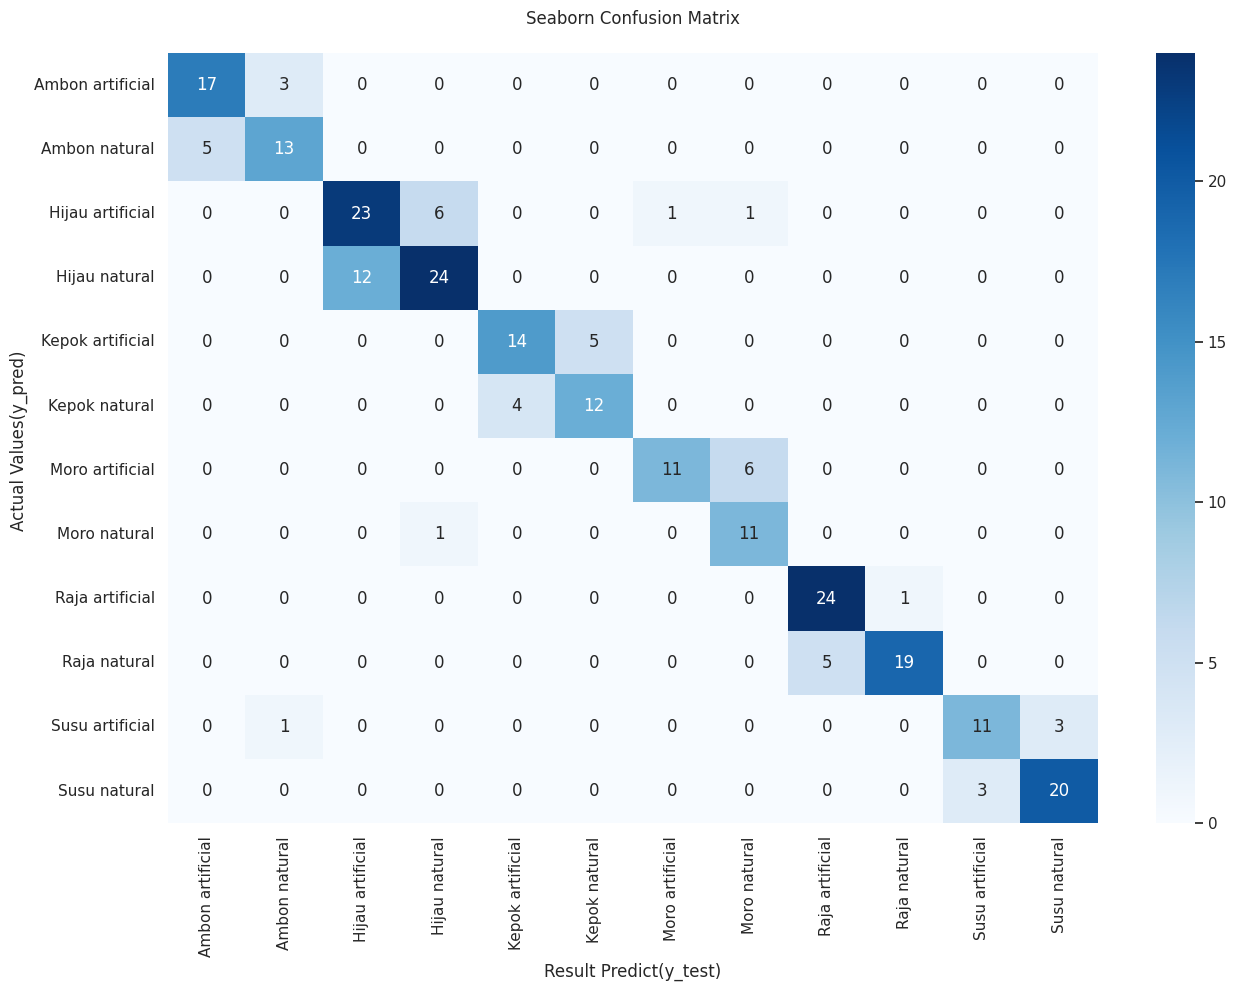

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [28]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.76      0.72      0.74        18
           2       0.66      0.74      0.70        31
           3       0.77      0.67      0.72        36
           4       0.78      0.74      0.76        19
           5       0.71      0.75      0.73        16
           6       0.92      0.65      0.76        17
           7       0.61      0.92      0.73        12
           8       0.83      0.96      0.89        25
           9       0.95      0.79      0.86        24
          10       0.79      0.73      0.76        15
          11       0.87      0.87      0.87        23

    accuracy                           0.78       256
   macro avg       0.78      0.78      0.78       256
weighted avg       0.79      0.78      0.78       256



### MobileNet Evaluation

In [29]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.390625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

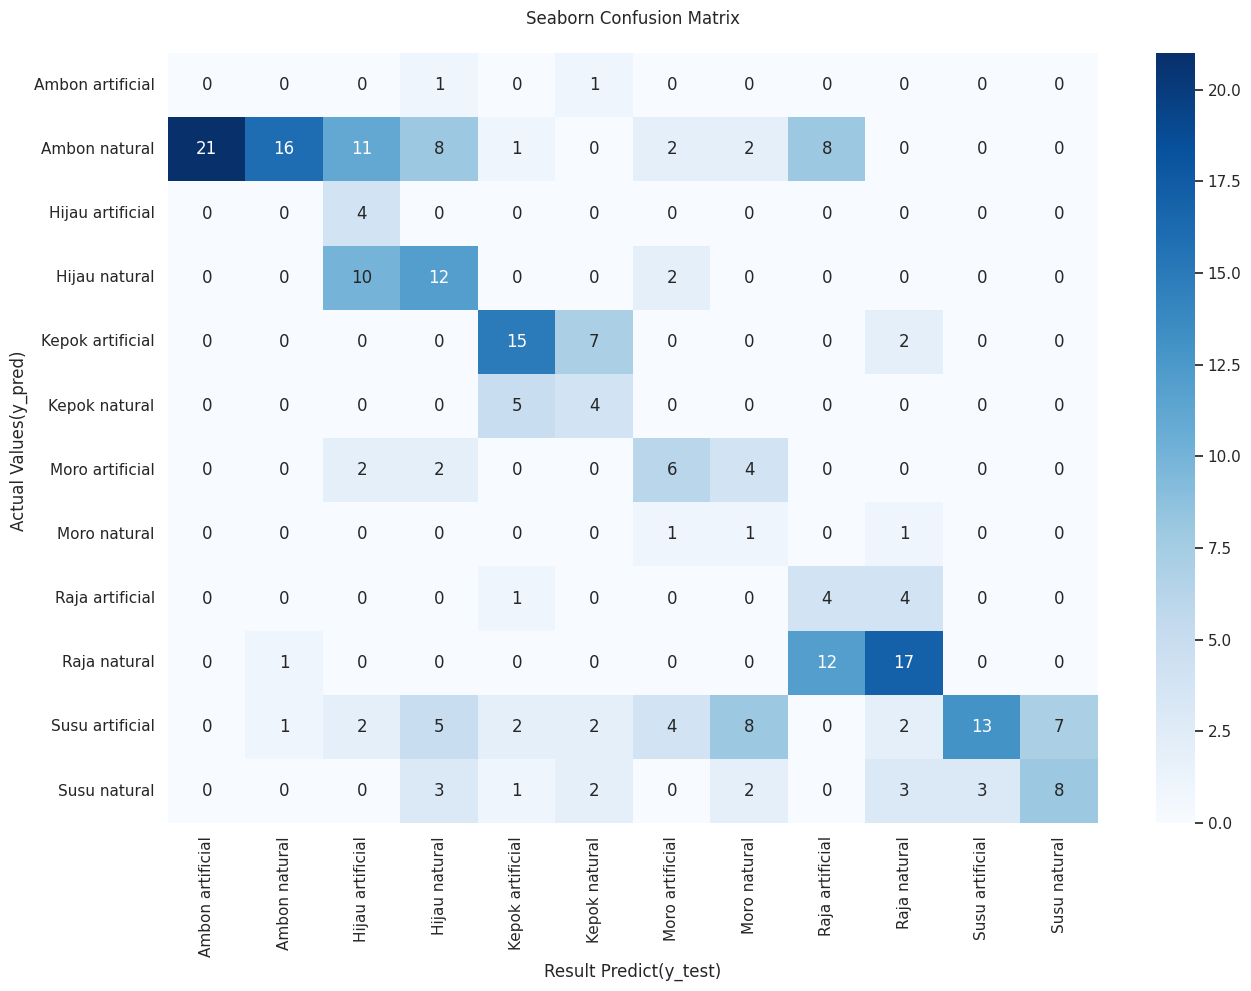

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [31]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.89      0.23      0.37        69
           2       0.14      1.00      0.24         4
           3       0.39      0.50      0.44        24
           4       0.60      0.62      0.61        24
           5       0.25      0.44      0.32         9
           6       0.40      0.43      0.41        14
           7       0.06      0.33      0.10         3
           8       0.17      0.44      0.24         9
           9       0.59      0.57      0.58        30
          10       0.81      0.28      0.42        46
          11       0.53      0.36      0.43        22

    accuracy                           0.39       256
   macro avg       0.40      0.44      0.35       256
weighted avg       0.63      0.39      0.42       256



### Ensemble Evaluation

In [32]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.7578125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

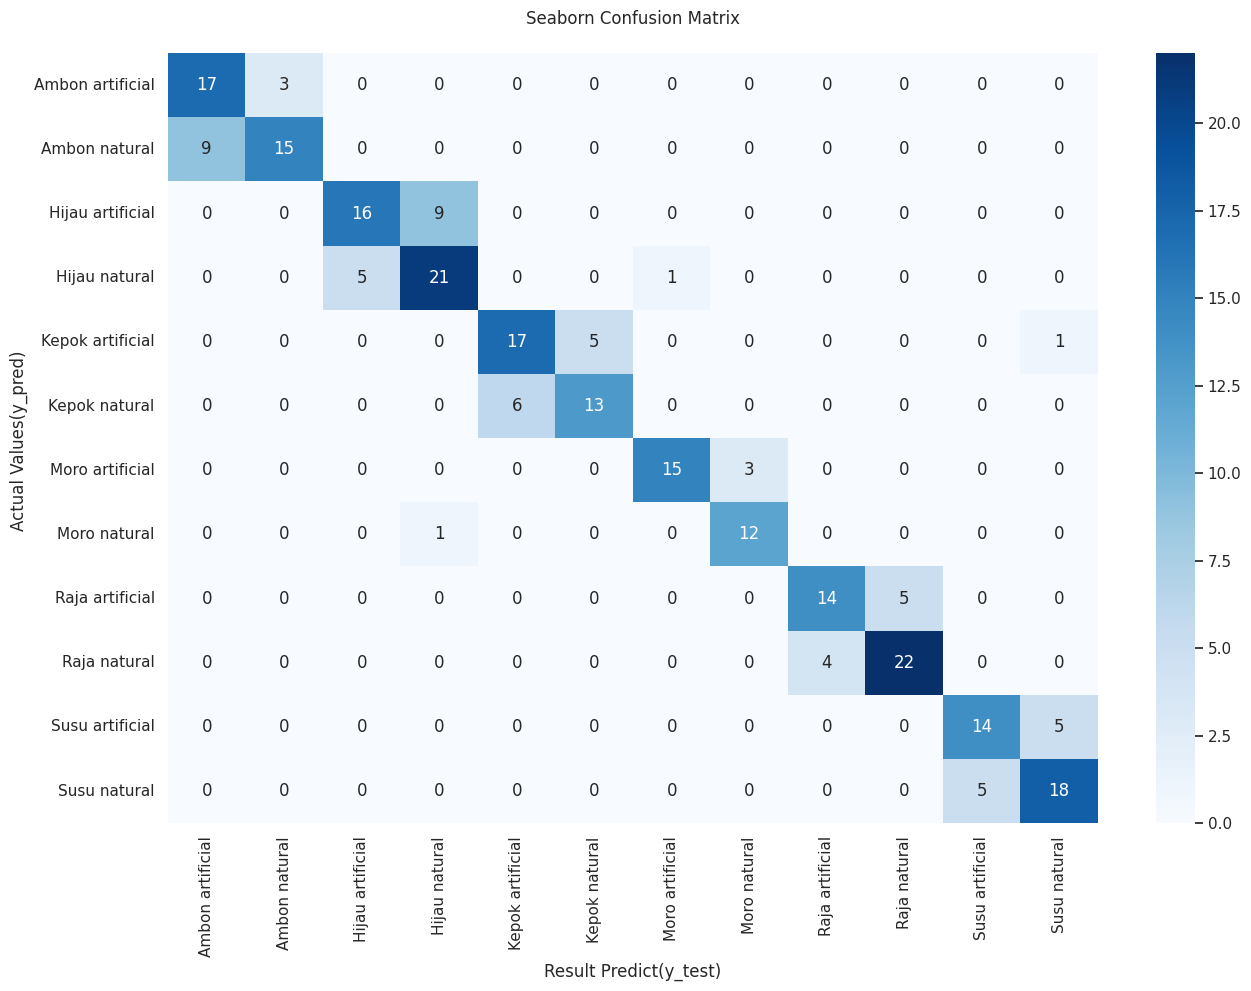

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [34]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.85      0.74        20
           1       0.83      0.62      0.71        24
           2       0.76      0.64      0.70        25
           3       0.68      0.78      0.72        27
           4       0.74      0.74      0.74        23
           5       0.72      0.68      0.70        19
           6       0.94      0.83      0.88        18
           7       0.80      0.92      0.86        13
           8       0.78      0.74      0.76        19
           9       0.81      0.85      0.83        26
          10       0.74      0.74      0.74        19
          11       0.75      0.78      0.77        23

    accuracy                           0.76       256
   macro avg       0.77      0.76      0.76       256
weighted avg       0.76      0.76      0.76       256



## Pengujian 0(2) - Adam No Modif Fixed LR 0,0001

In [35]:
model_resnet = 'new_test/new-test-resnet-adam-0,0001-completed.h5'
model_mobile = 'new_test/new-test-mobile-adam-0,0001-completed.h5'

### Load ResNet Model

In [36]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [37]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [38]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [39]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [40]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [41]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 18ms/step


In [42]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 165ms/step


In [43]:
ensemble_resmob = (pred1+pred2)/2.0

In [44]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [45]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 18ms/step


In [46]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [47]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 162ms/step


In [48]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [49]:
!pip install seaborn

In [50]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.8203125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

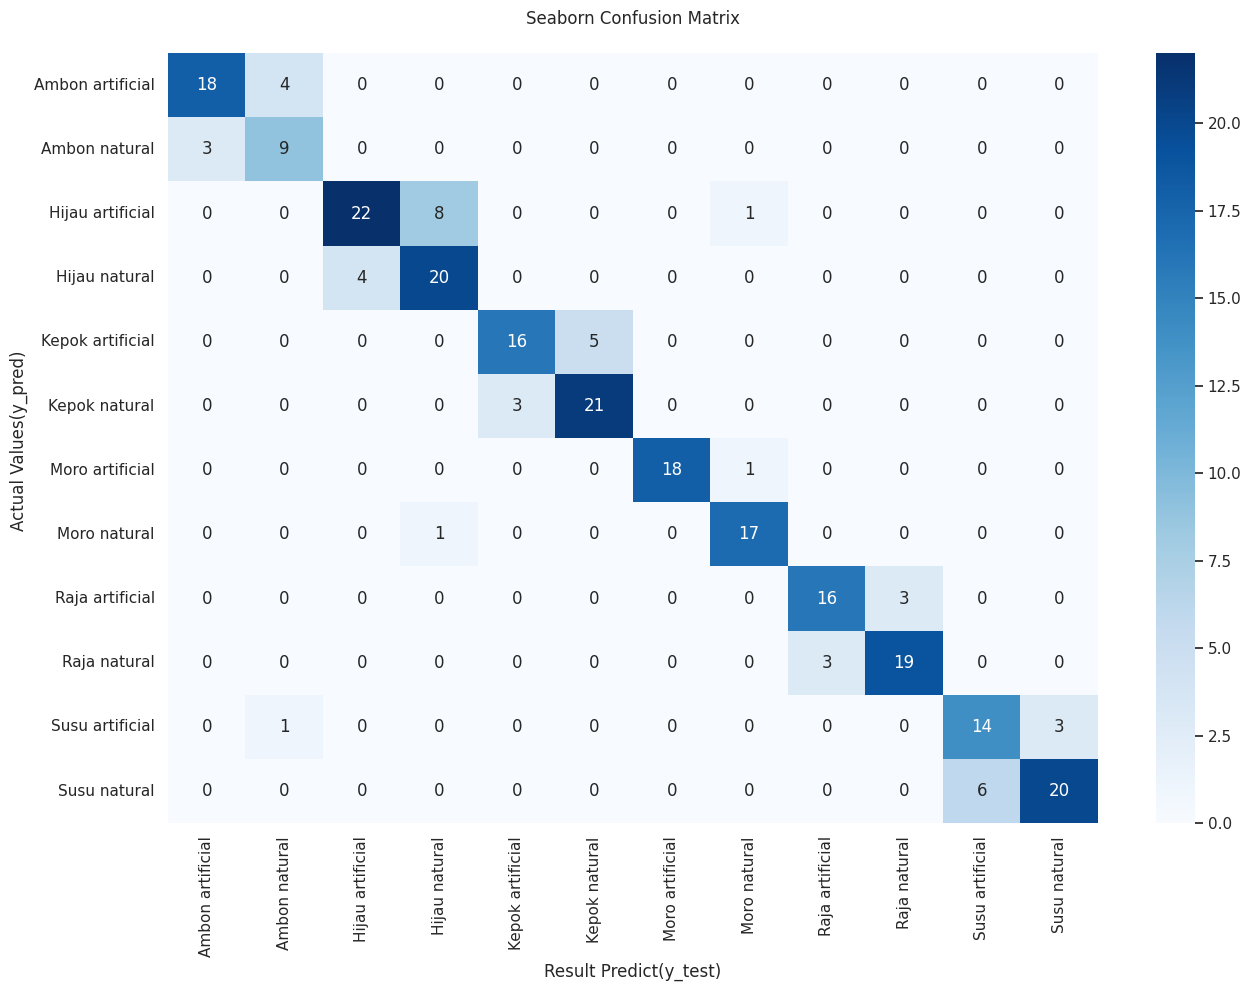

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [52]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        22
           1       0.64      0.75      0.69        12
           2       0.85      0.71      0.77        31
           3       0.69      0.83      0.75        24
           4       0.84      0.76      0.80        21
           5       0.81      0.88      0.84        24
           6       1.00      0.95      0.97        19
           7       0.89      0.94      0.92        18
           8       0.84      0.84      0.84        19
           9       0.86      0.86      0.86        22
          10       0.70      0.78      0.74        18
          11       0.87      0.77      0.82        26

    accuracy                           0.82       256
   macro avg       0.82      0.82      0.82       256
weighted avg       0.83      0.82      0.82       256



### MobileNet Evaluation

In [53]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.109375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

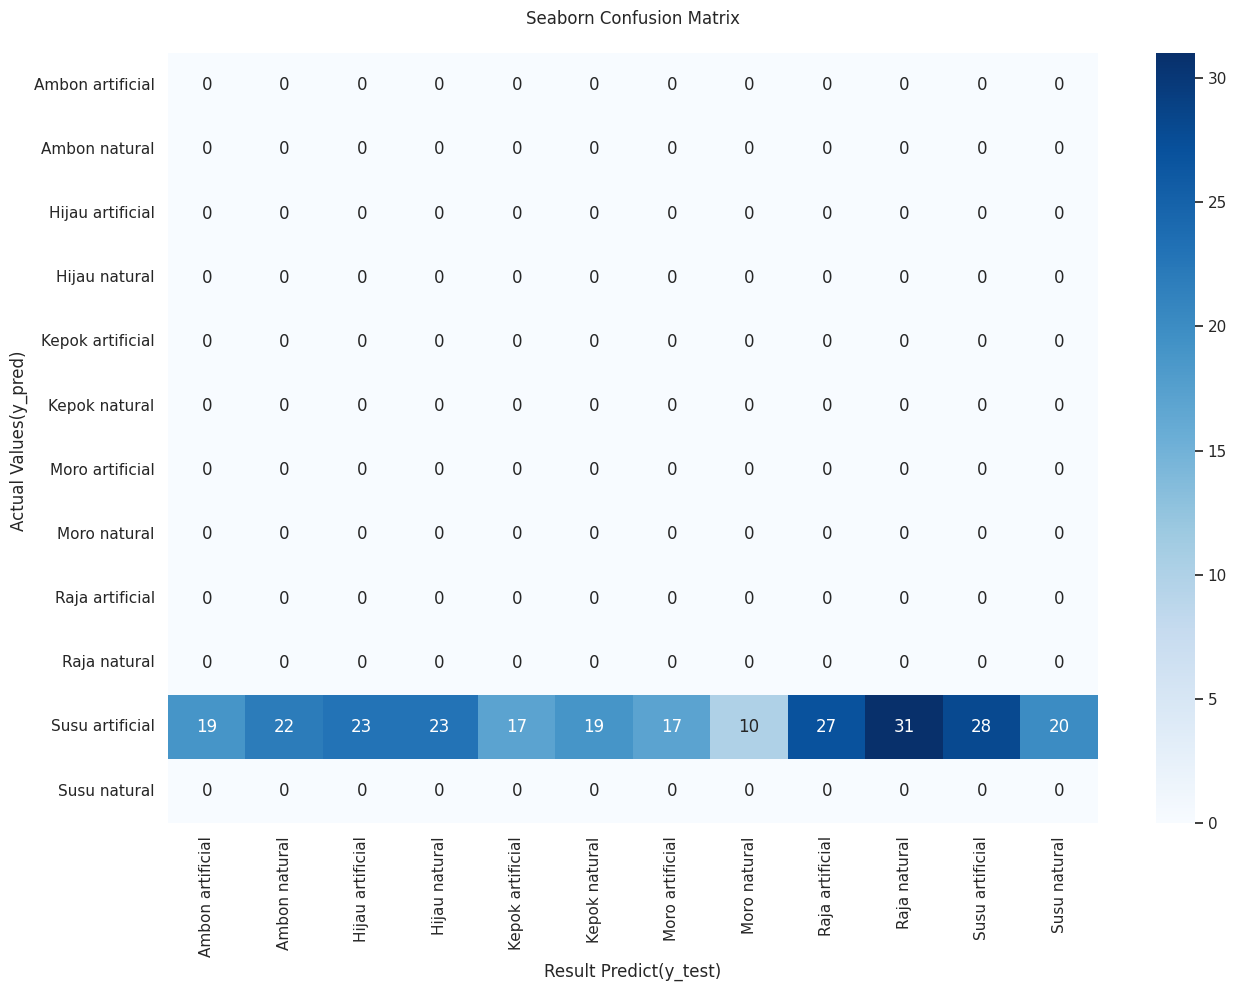

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [55]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       1.00      0.11      0.20       256
          11       0.00      0.00      0.00         0

    accuracy                           0.11       256
   macro avg       0.08      0.01      0.02       256
weighted avg       1.00      0.11      0.20       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Evaluation

In [56]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.07421875


Text(153.75, 0.5, 'Actual Values(y_pred) ')

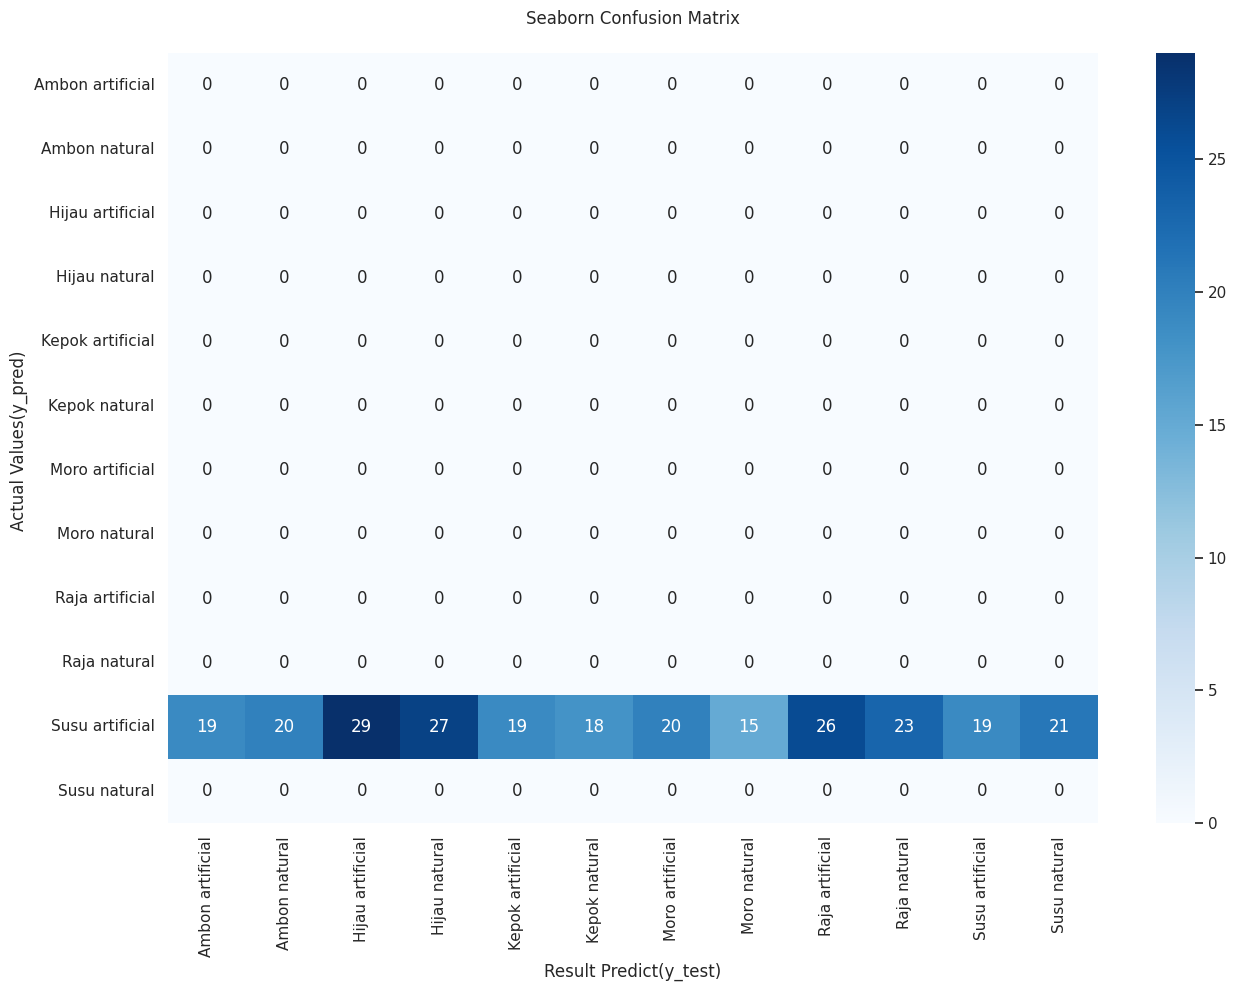

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [58]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       1.00      0.07      0.14       256
          11       0.00      0.00      0.00         0

    accuracy                           0.07       256
   macro avg       0.08      0.01      0.01       256
weighted avg       1.00      0.07      0.14       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Pengujian 1 - SGD No Modif

In [364]:
model_resnet = 'models/resnet-sgd-no-modif-0,1-0,0001.h5'
model_mobile = 'models/mobile-sgd-no-modif-0,1-0,0001.h5'

### Load ResNet Model

In [365]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [366]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [367]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [368]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [369]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [370]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 28ms/step


In [371]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 89ms/step


In [372]:
ensemble_resmob = (pred1+pred2)/2.0

In [373]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [374]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 14ms/step


In [375]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [376]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 146ms/step


In [377]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [378]:
!pip install seaborn

In [379]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.8828125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

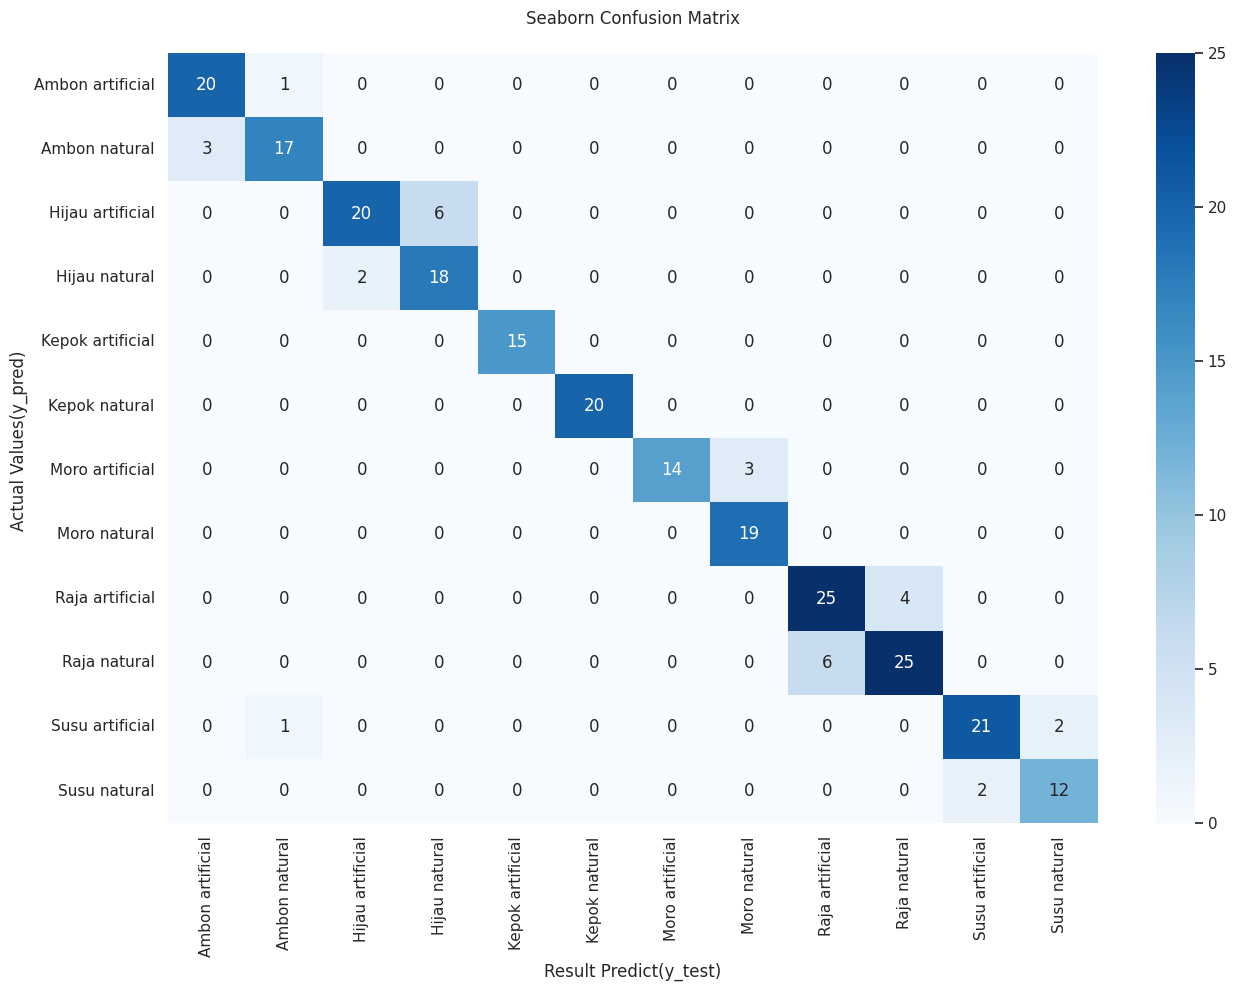

In [380]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [381]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.89      0.85      0.87        20
           2       0.91      0.77      0.83        26
           3       0.75      0.90      0.82        20
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        20
           6       1.00      0.82      0.90        17
           7       0.86      1.00      0.93        19
           8       0.81      0.86      0.83        29
           9       0.86      0.81      0.83        31
          10       0.91      0.88      0.89        24
          11       0.86      0.86      0.86        14

    accuracy                           0.88       256
   macro avg       0.89      0.89      0.89       256
weighted avg       0.89      0.88      0.88       256



### MobileNet Evaluation

In [382]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.875


Text(153.75, 0.5, 'Actual Values(y_pred) ')

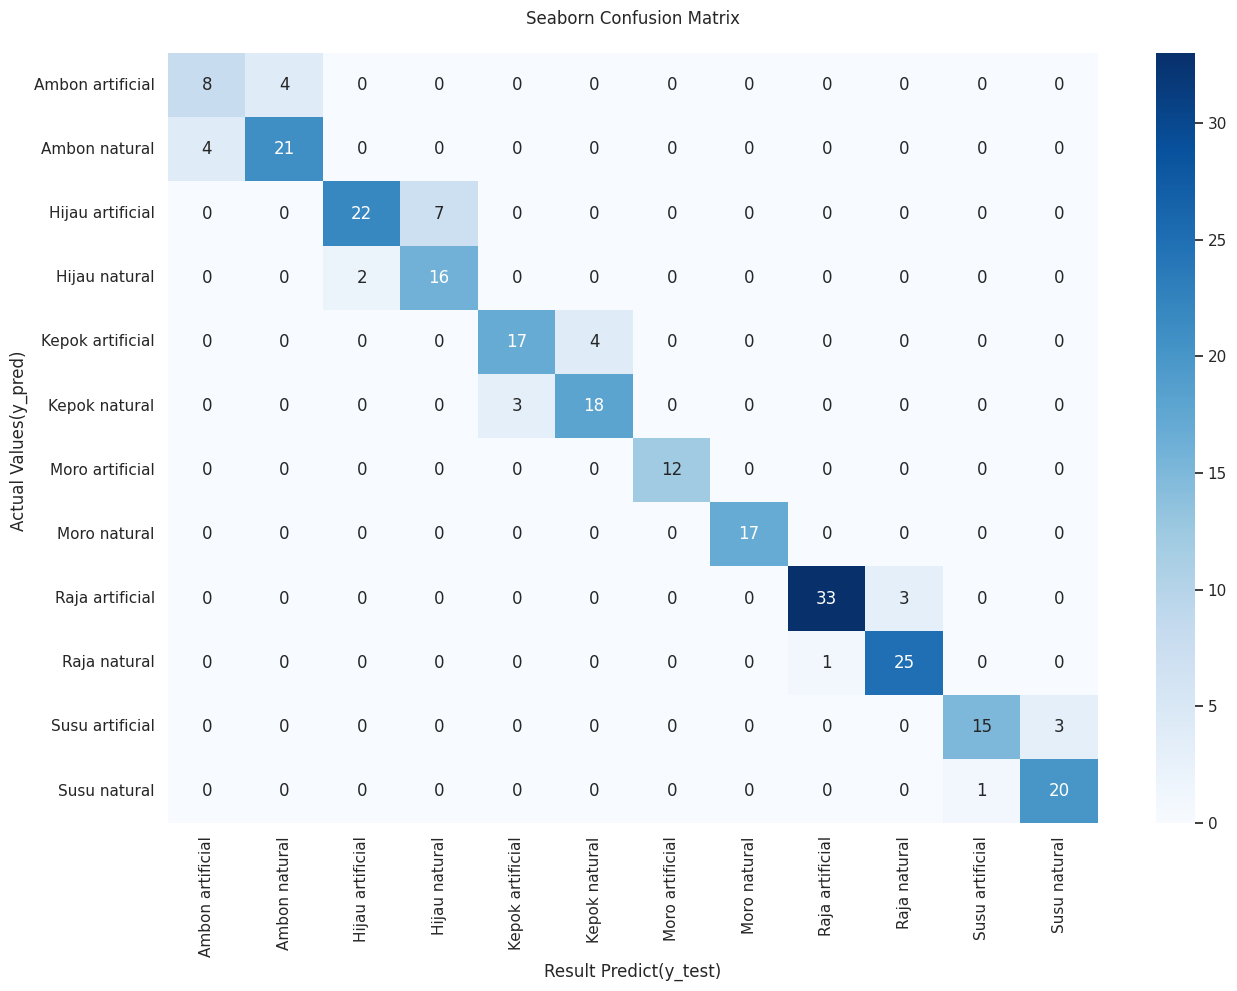

In [383]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [384]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.84      0.84      0.84        25
           2       0.92      0.76      0.83        29
           3       0.70      0.89      0.78        18
           4       0.85      0.81      0.83        21
           5       0.82      0.86      0.84        21
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        17
           8       0.97      0.92      0.94        36
           9       0.89      0.96      0.93        26
          10       0.94      0.83      0.88        18
          11       0.87      0.95      0.91        21

    accuracy                           0.88       256
   macro avg       0.87      0.87      0.87       256
weighted avg       0.88      0.88      0.88       256



### Ensemble Evaluation

In [385]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.90234375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

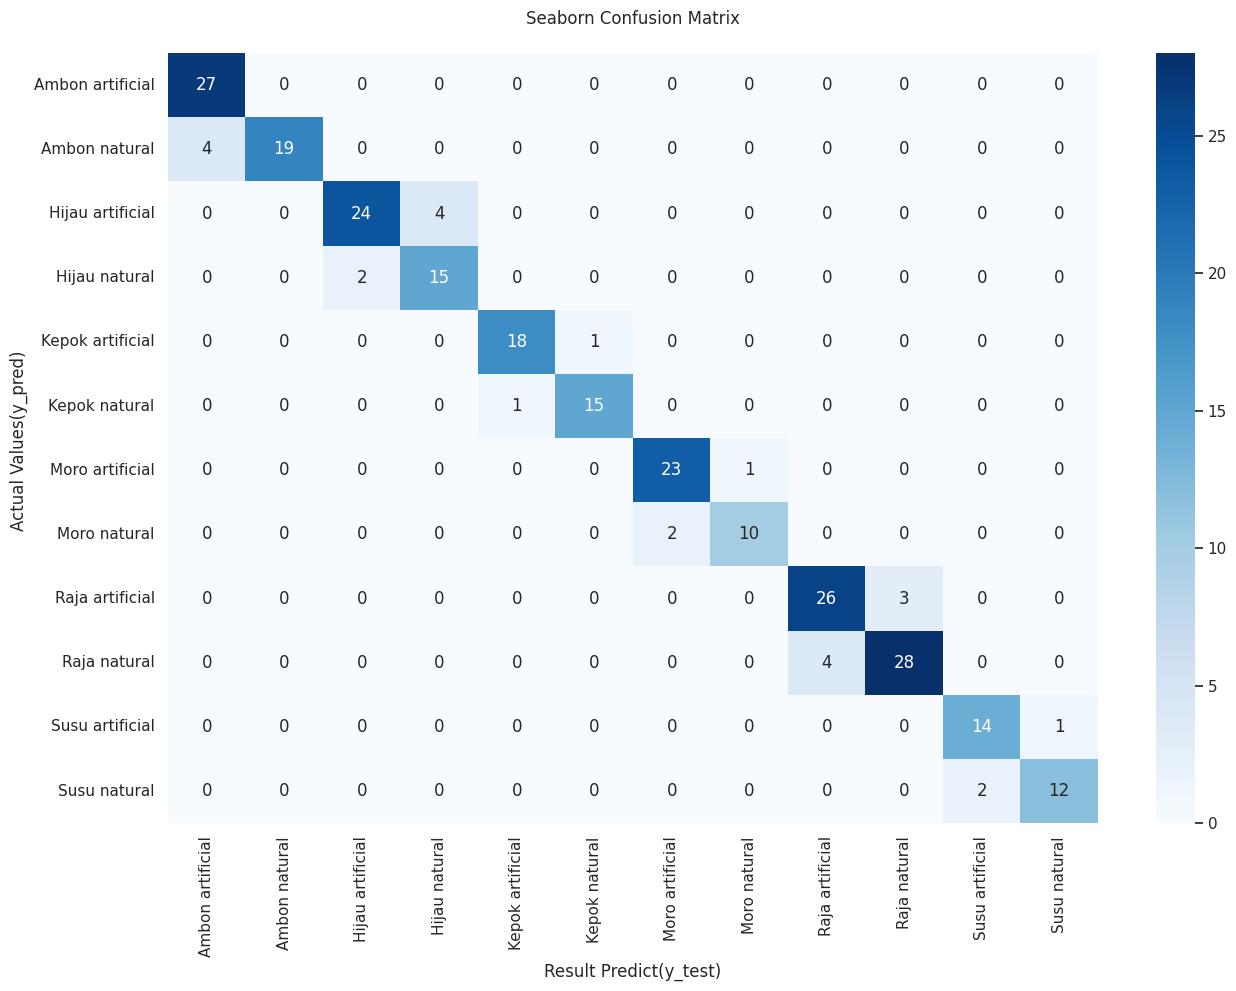

In [386]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [387]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        27
           1       1.00      0.83      0.90        23
           2       0.92      0.86      0.89        28
           3       0.79      0.88      0.83        17
           4       0.95      0.95      0.95        19
           5       0.94      0.94      0.94        16
           6       0.92      0.96      0.94        24
           7       0.91      0.83      0.87        12
           8       0.87      0.90      0.88        29
           9       0.90      0.88      0.89        32
          10       0.88      0.93      0.90        15
          11       0.92      0.86      0.89        14

    accuracy                           0.90       256
   macro avg       0.91      0.90      0.90       256
weighted avg       0.91      0.90      0.90       256



## Pengujian 2 - Adam No Modif

In [388]:
model_resnet = 'models/resnet-adam-no-modif-0,1-0,0001.h5'
model_mobile = 'models/mobile-adam-no-modif-0,1-0,0001.h5'

### Load ResNet Model

In [389]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [390]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [391]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [392]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [393]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [394]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 18ms/step


In [395]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 4s 240ms/step


In [396]:
ensemble_resmob = (pred1+pred2)/2.0

In [397]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [398]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 11ms/step


In [399]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [400]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 92ms/step


In [401]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [402]:
!pip install seaborn

In [403]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.609375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

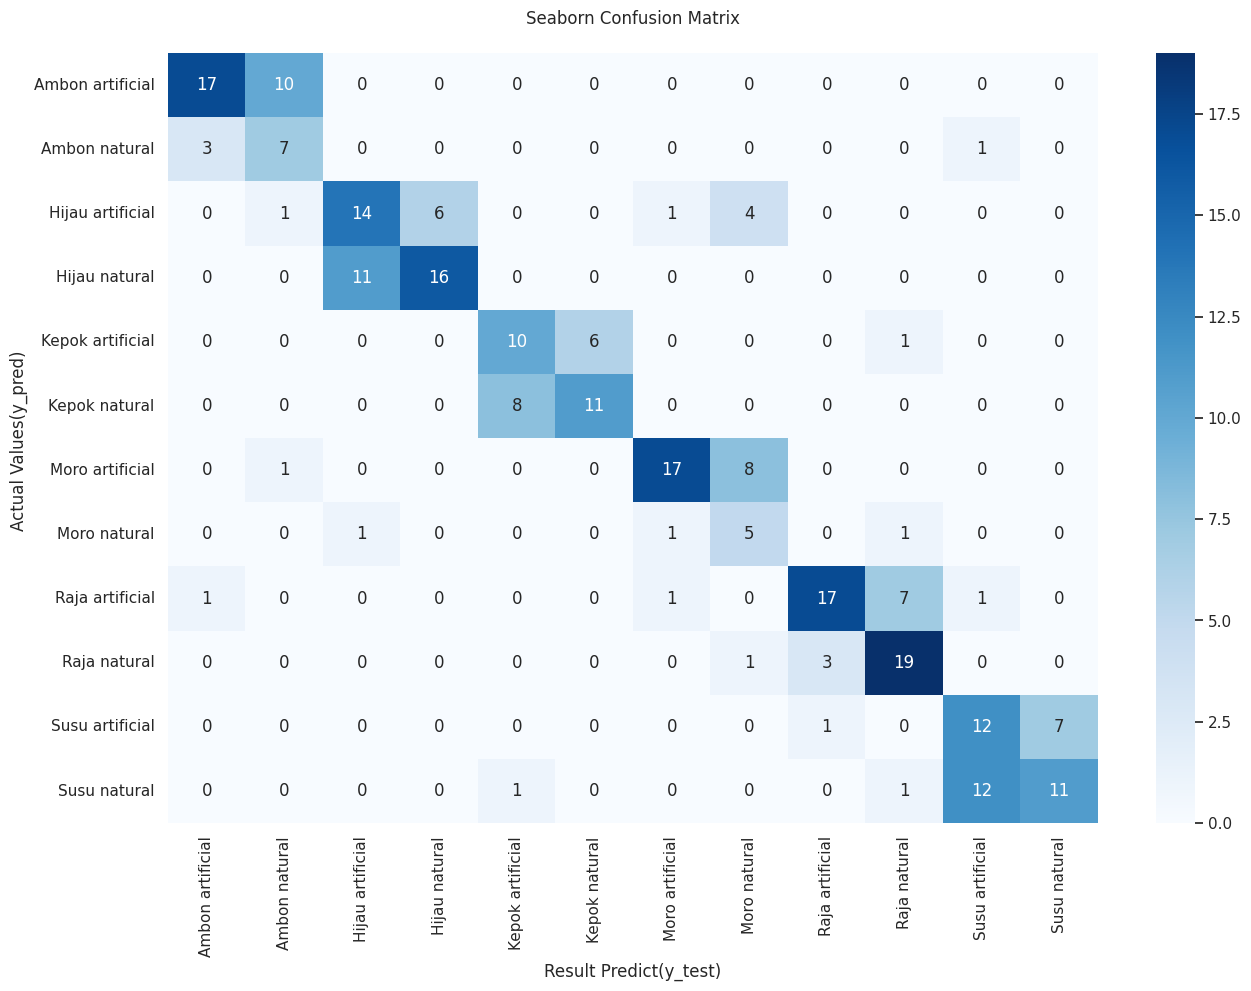

In [404]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [405]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.63      0.71        27
           1       0.37      0.64      0.47        11
           2       0.54      0.54      0.54        26
           3       0.73      0.59      0.65        27
           4       0.53      0.59      0.56        17
           5       0.65      0.58      0.61        19
           6       0.85      0.65      0.74        26
           7       0.28      0.62      0.38         8
           8       0.81      0.63      0.71        27
           9       0.66      0.83      0.73        23
          10       0.46      0.60      0.52        20
          11       0.61      0.44      0.51        25

    accuracy                           0.61       256
   macro avg       0.61      0.61      0.59       256
weighted avg       0.65      0.61      0.62       256



### MobileNet Evaluation

In [406]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.65234375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

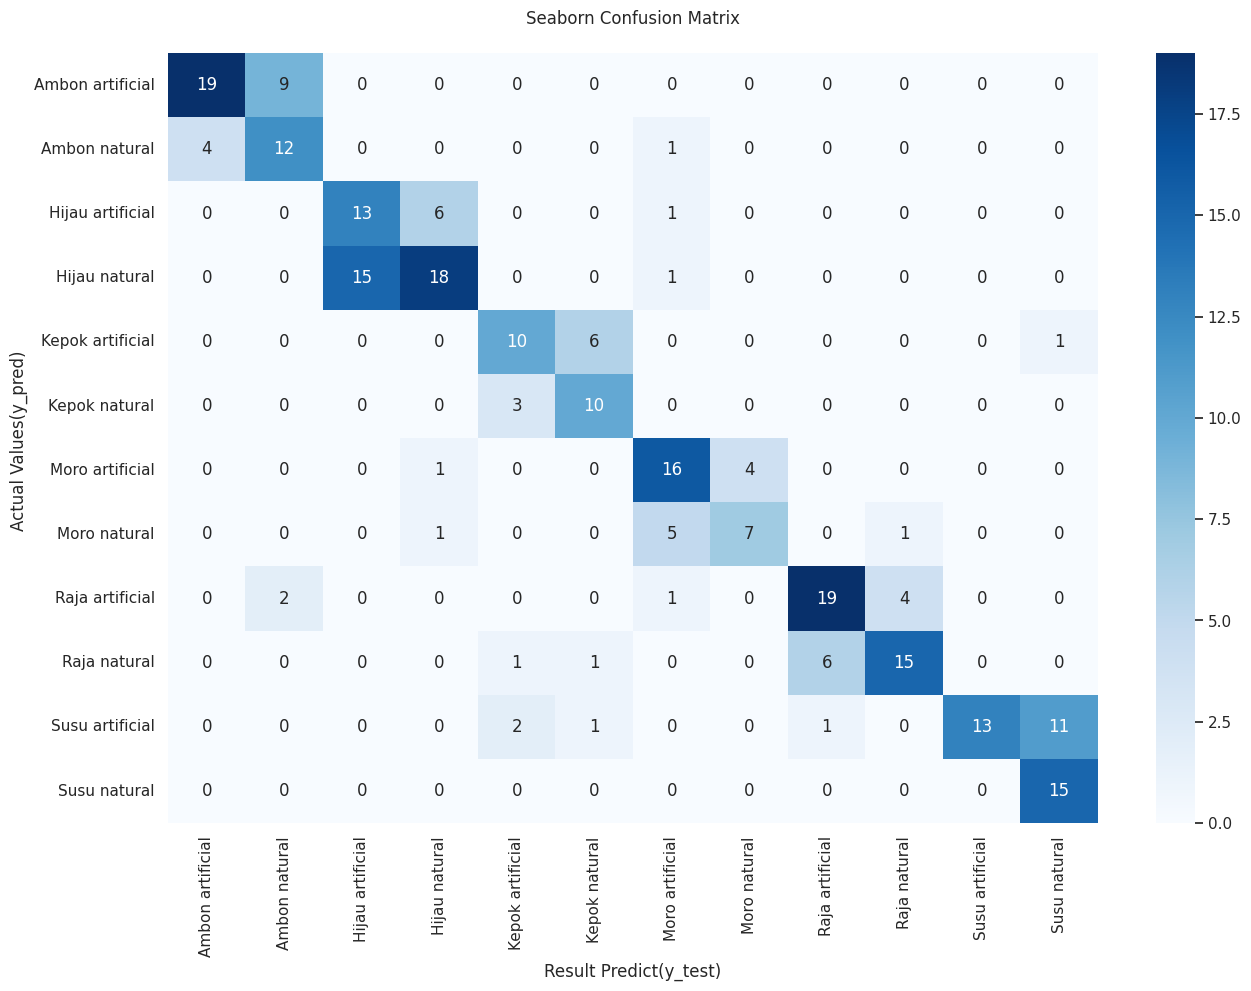

In [407]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [408]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.68      0.75        28
           1       0.52      0.71      0.60        17
           2       0.46      0.65      0.54        20
           3       0.69      0.53      0.60        34
           4       0.62      0.59      0.61        17
           5       0.56      0.77      0.65        13
           6       0.64      0.76      0.70        21
           7       0.64      0.50      0.56        14
           8       0.73      0.73      0.73        26
           9       0.75      0.65      0.70        23
          10       1.00      0.46      0.63        28
          11       0.56      1.00      0.71        15

    accuracy                           0.65       256
   macro avg       0.67      0.67      0.65       256
weighted avg       0.69      0.65      0.65       256



### Ensemble Evaluation

In [409]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.671875


Text(153.75, 0.5, 'Actual Values(y_pred) ')

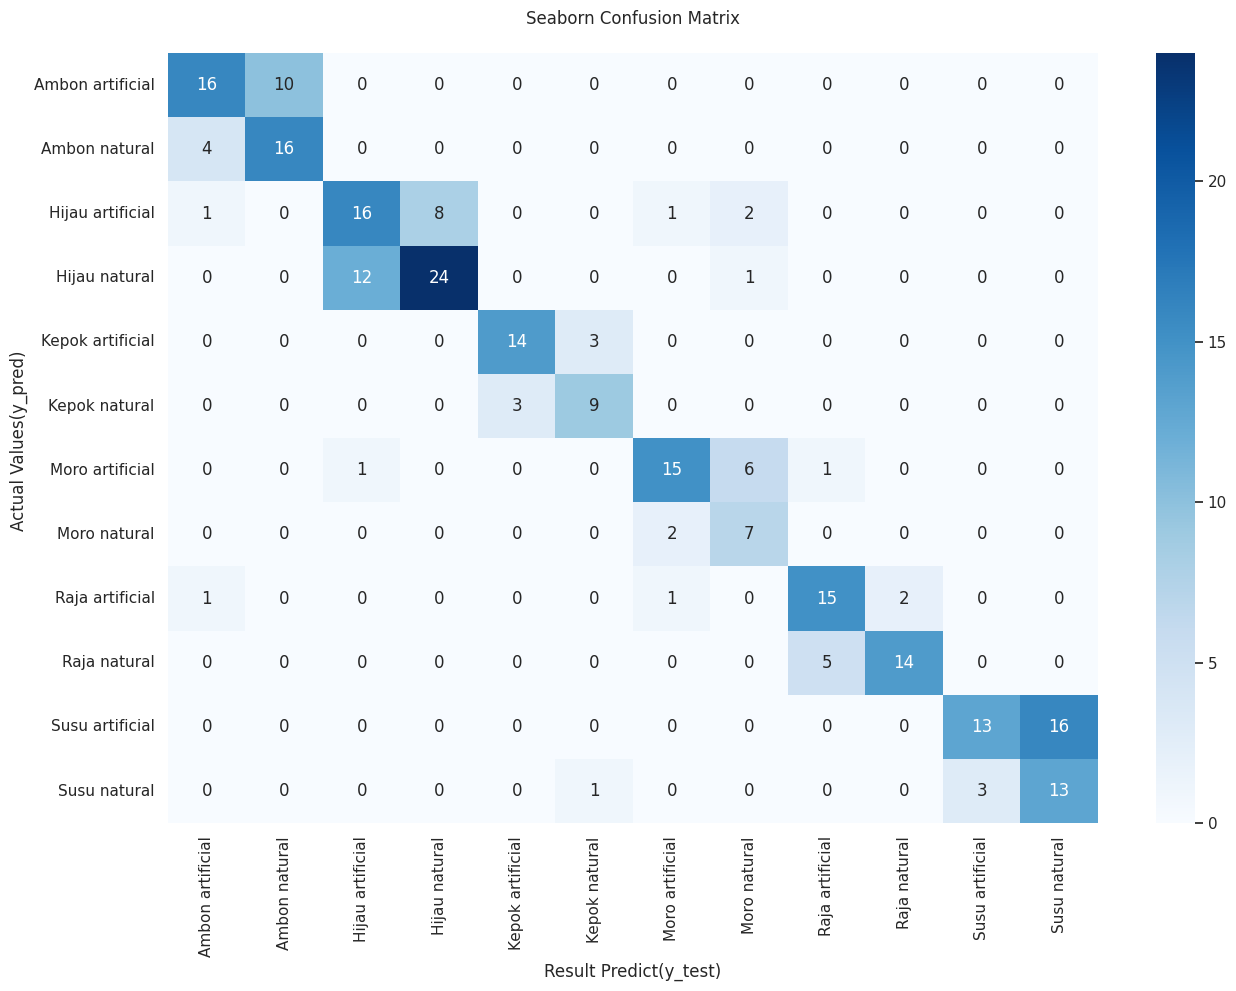

In [410]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [411]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.62      0.67        26
           1       0.62      0.80      0.70        20
           2       0.55      0.57      0.56        28
           3       0.75      0.65      0.70        37
           4       0.82      0.82      0.82        17
           5       0.69      0.75      0.72        12
           6       0.79      0.65      0.71        23
           7       0.44      0.78      0.56         9
           8       0.71      0.79      0.75        19
           9       0.88      0.74      0.80        19
          10       0.81      0.45      0.58        29
          11       0.45      0.76      0.57        17

    accuracy                           0.67       256
   macro avg       0.69      0.70      0.68       256
weighted avg       0.70      0.67      0.67       256



# Pengujian Dropout Reduce LR on Plateau

## Pengujian 3 - SGD Dropout 0,1

In [414]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,1-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-dropout-0,1-completed.h5'

### Load ResNet Model

In [415]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [416]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [417]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [418]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [419]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [420]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 11ms/step


In [421]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 4s 156ms/step


In [422]:
ensemble_resmob = (pred1+pred2)/2.0

In [423]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [424]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 13ms/step


In [425]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [426]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 137ms/step


In [427]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [428]:
!pip install seaborn

In [429]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.8125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

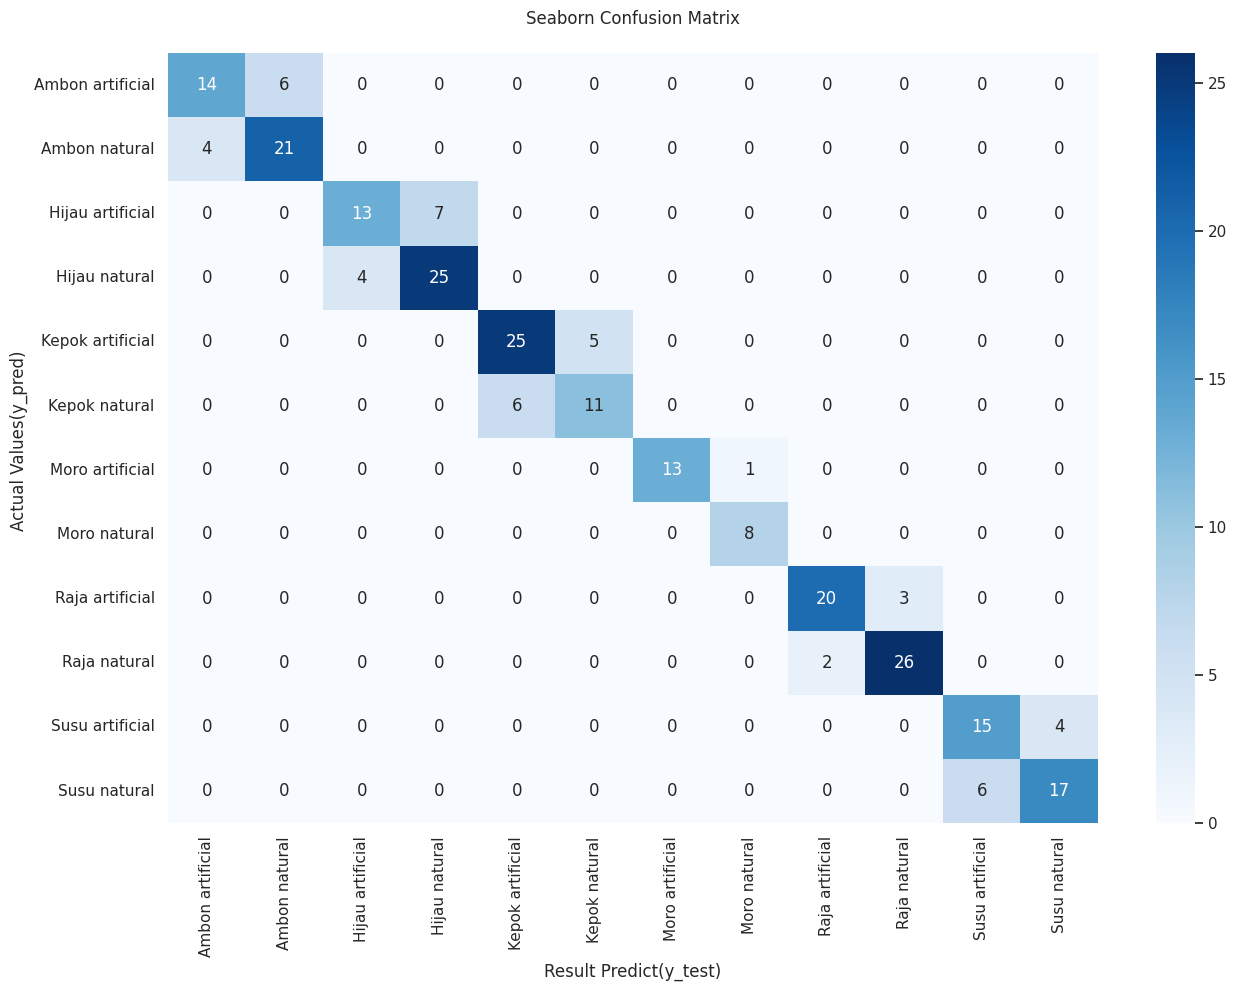

In [430]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [431]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       0.78      0.84      0.81        25
           2       0.76      0.65      0.70        20
           3       0.78      0.86      0.82        29
           4       0.81      0.83      0.82        30
           5       0.69      0.65      0.67        17
           6       1.00      0.93      0.96        14
           7       0.89      1.00      0.94         8
           8       0.91      0.87      0.89        23
           9       0.90      0.93      0.91        28
          10       0.71      0.79      0.75        19
          11       0.81      0.74      0.77        23

    accuracy                           0.81       256
   macro avg       0.82      0.82      0.82       256
weighted avg       0.81      0.81      0.81       256



### MobileNet Evaluation

In [432]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.859375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

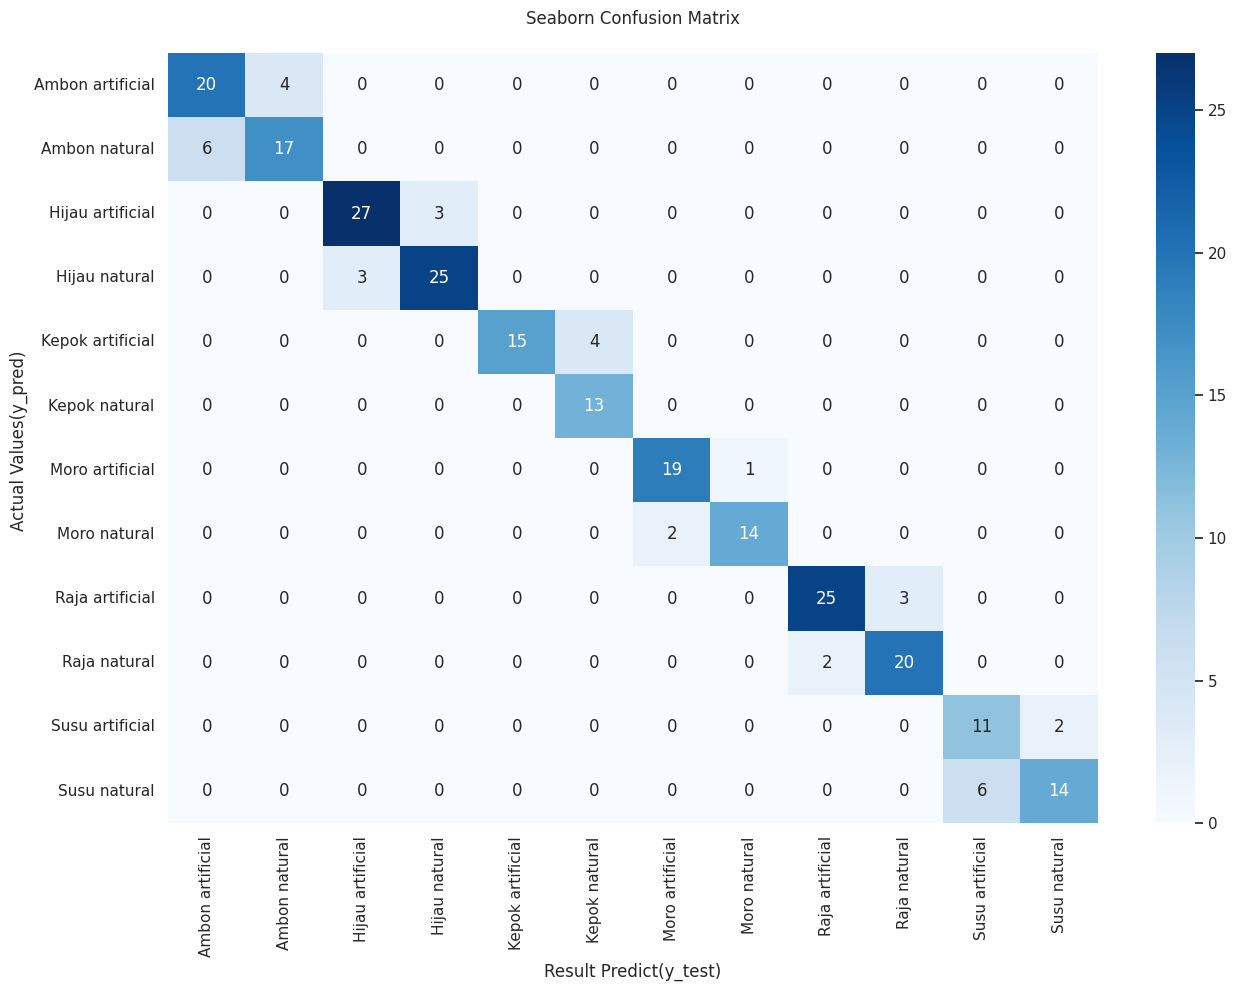

In [433]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [434]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        24
           1       0.81      0.74      0.77        23
           2       0.90      0.90      0.90        30
           3       0.89      0.89      0.89        28
           4       1.00      0.79      0.88        19
           5       0.76      1.00      0.87        13
           6       0.90      0.95      0.93        20
           7       0.93      0.88      0.90        16
           8       0.93      0.89      0.91        28
           9       0.87      0.91      0.89        22
          10       0.65      0.85      0.73        13
          11       0.88      0.70      0.78        20

    accuracy                           0.86       256
   macro avg       0.86      0.86      0.85       256
weighted avg       0.87      0.86      0.86       256



### Ensemble Evaluation

In [435]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.8828125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

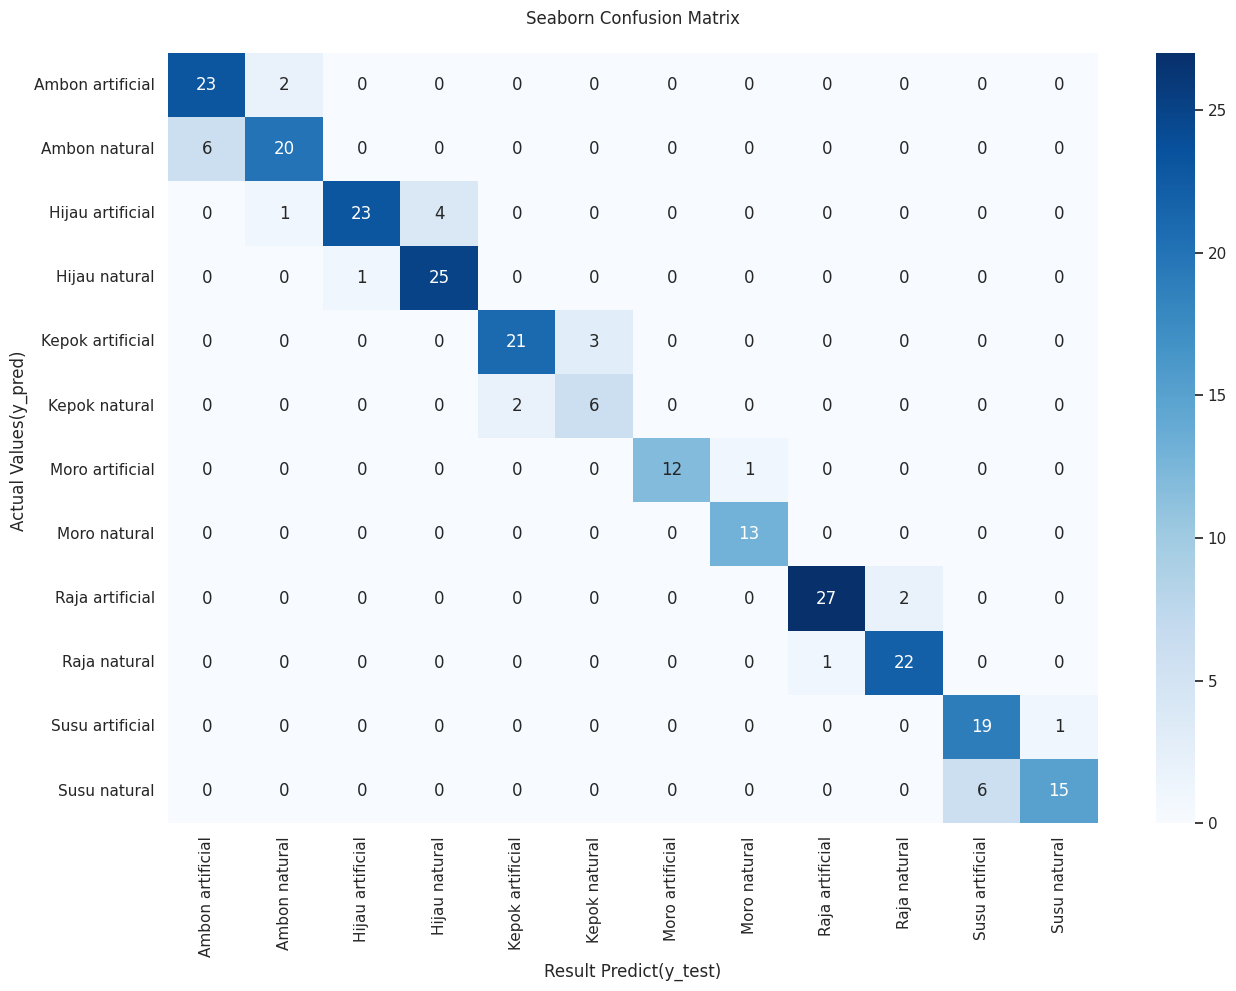

In [436]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [437]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        25
           1       0.87      0.77      0.82        26
           2       0.96      0.82      0.88        28
           3       0.86      0.96      0.91        26
           4       0.91      0.88      0.89        24
           5       0.67      0.75      0.71         8
           6       1.00      0.92      0.96        13
           7       0.93      1.00      0.96        13
           8       0.96      0.93      0.95        29
           9       0.92      0.96      0.94        23
          10       0.76      0.95      0.84        20
          11       0.94      0.71      0.81        21

    accuracy                           0.88       256
   macro avg       0.88      0.88      0.88       256
weighted avg       0.89      0.88      0.88       256



## Pengujian 4 - SGD Dropout 0,2

In [80]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,2-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-dropout-0,2-completed.h5'

### Load ResNet Model

In [81]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [82]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [83]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [84]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [85]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [86]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 11ms/step


In [87]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 4s 141ms/step


In [88]:
ensemble_resmob = (pred1+pred2)/2.0

In [89]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [90]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 11ms/step


In [91]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [92]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 87ms/step


In [93]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [94]:
!pip install seaborn

In [95]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.765625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

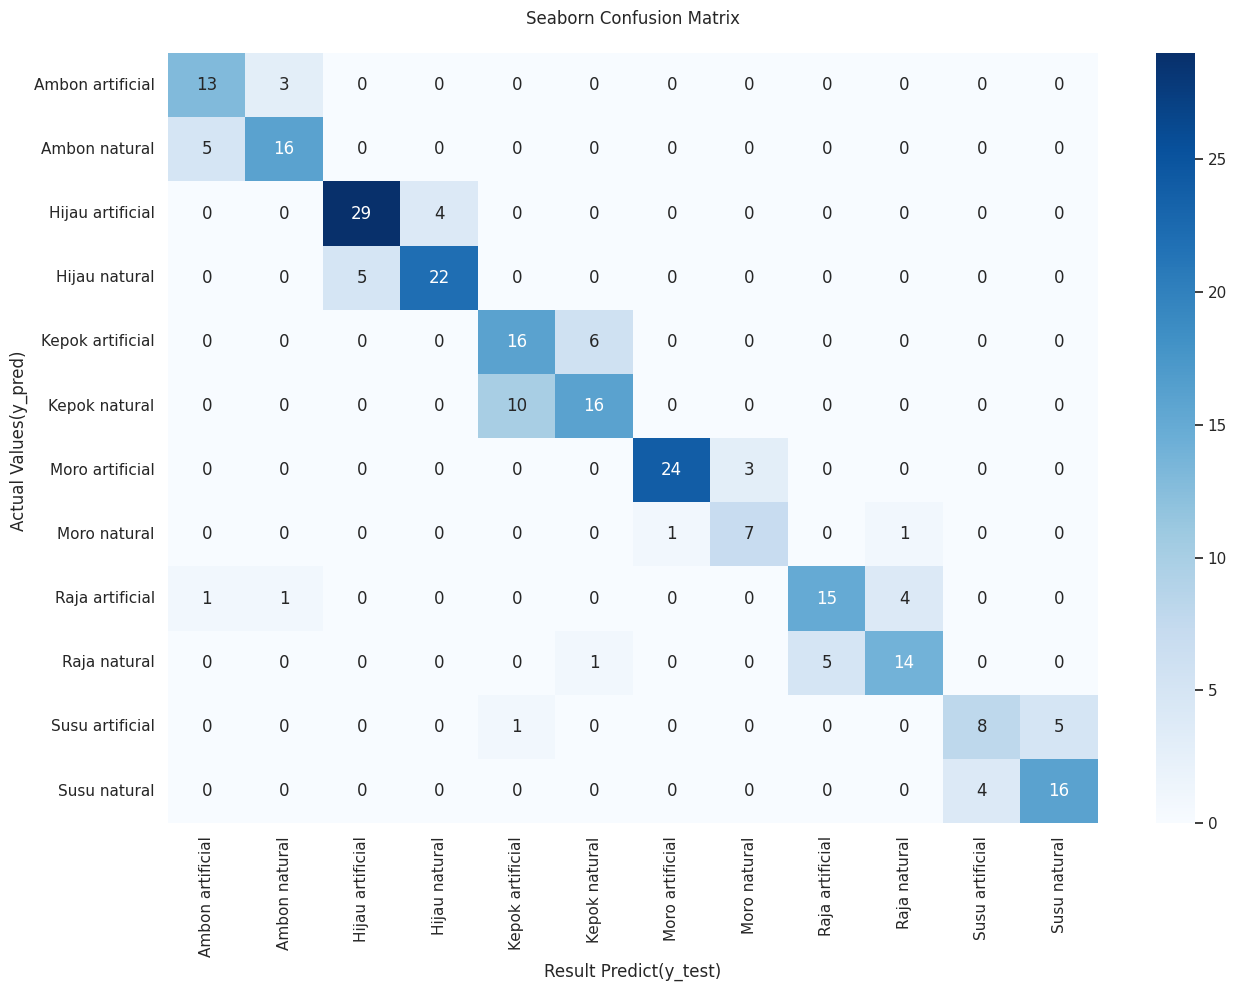

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [97]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.81      0.74        16
           1       0.80      0.76      0.78        21
           2       0.85      0.88      0.87        33
           3       0.85      0.81      0.83        27
           4       0.59      0.73      0.65        22
           5       0.70      0.62      0.65        26
           6       0.96      0.89      0.92        27
           7       0.70      0.78      0.74         9
           8       0.75      0.71      0.73        21
           9       0.74      0.70      0.72        20
          10       0.67      0.57      0.62        14
          11       0.76      0.80      0.78        20

    accuracy                           0.77       256
   macro avg       0.75      0.76      0.75       256
weighted avg       0.77      0.77      0.77       256



### MobileNet Evaluation

In [98]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.82421875


Text(153.75, 0.5, 'Actual Values(y_pred) ')

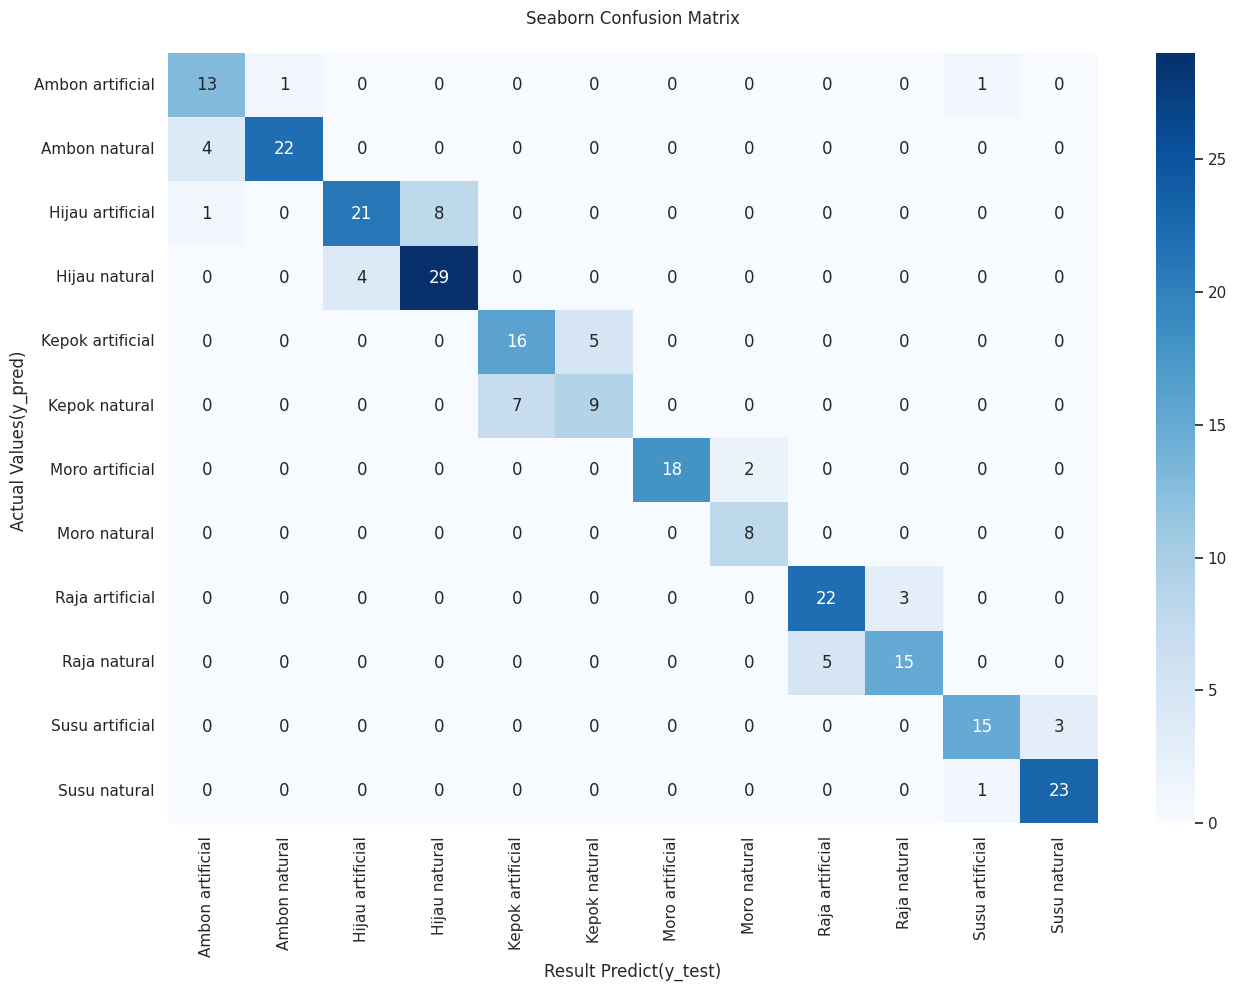

In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [100]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.96      0.85      0.90        26
           2       0.84      0.70      0.76        30
           3       0.78      0.88      0.83        33
           4       0.70      0.76      0.73        21
           5       0.64      0.56      0.60        16
           6       1.00      0.90      0.95        20
           7       0.80      1.00      0.89         8
           8       0.81      0.88      0.85        25
           9       0.83      0.75      0.79        20
          10       0.88      0.83      0.86        18
          11       0.88      0.96      0.92        24

    accuracy                           0.82       256
   macro avg       0.82      0.83      0.82       256
weighted avg       0.83      0.82      0.82       256



### Ensemble Evaluation

In [101]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.8828125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

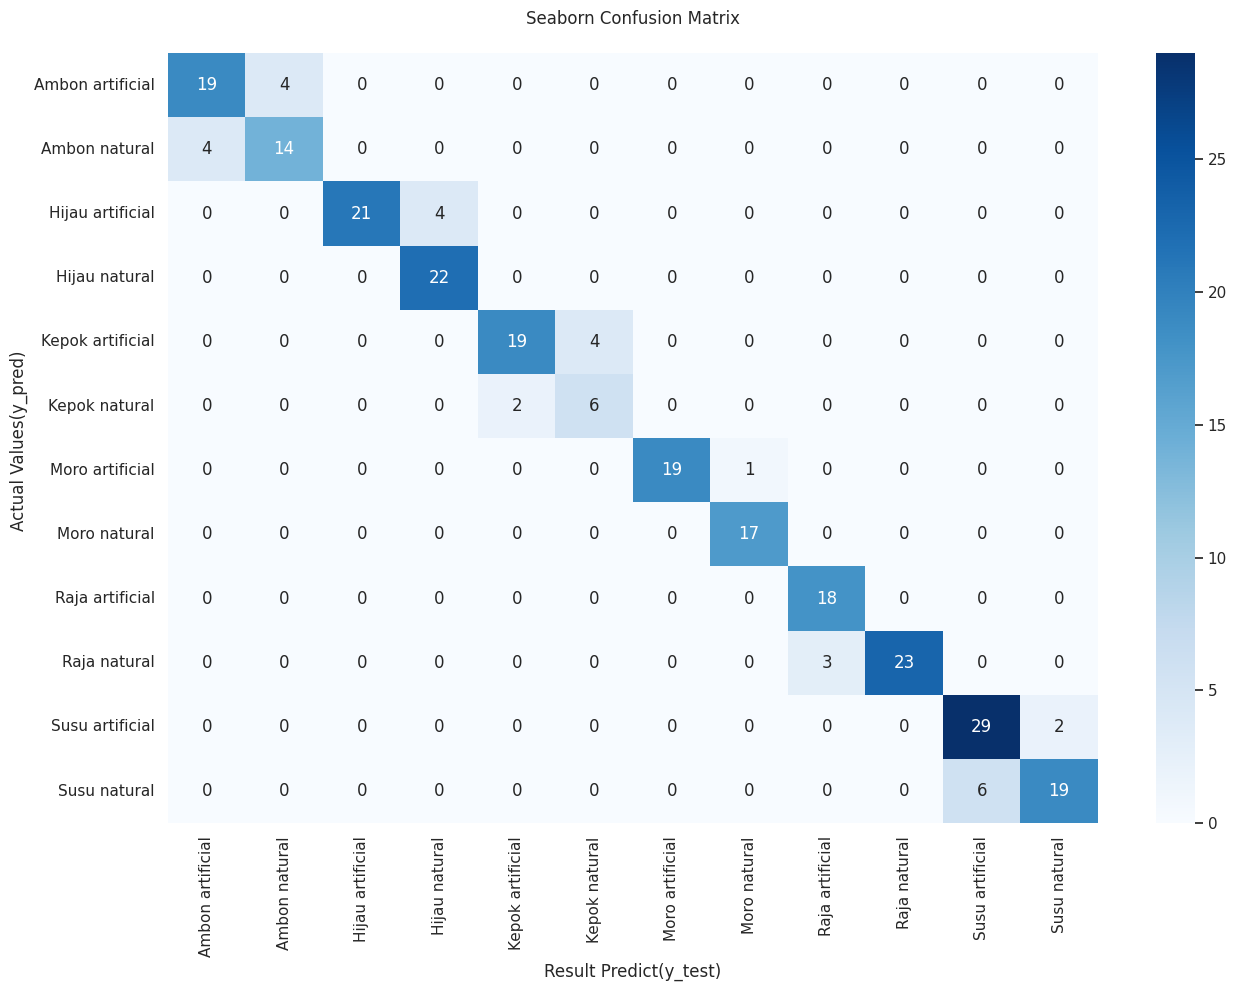

In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [103]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        23
           1       0.78      0.78      0.78        18
           2       1.00      0.84      0.91        25
           3       0.85      1.00      0.92        22
           4       0.90      0.83      0.86        23
           5       0.60      0.75      0.67         8
           6       1.00      0.95      0.97        20
           7       0.94      1.00      0.97        17
           8       0.86      1.00      0.92        18
           9       1.00      0.88      0.94        26
          10       0.83      0.94      0.88        31
          11       0.90      0.76      0.83        25

    accuracy                           0.88       256
   macro avg       0.87      0.88      0.87       256
weighted avg       0.89      0.88      0.88       256



## Pengujian 5 - SGD Dropout 0,3

In [104]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,3-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-dropout-0,3-completed.h5'

### Load ResNet Model

In [105]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [106]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [107]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [108]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [109]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  49  y:  49


### Testing Ensemble Averaging

In [110]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 17ms/step


In [111]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 4s 168ms/step


In [112]:
ensemble_resmob = (pred1+pred2)/2.0

In [113]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [114]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 11ms/step


In [115]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [116]:
predResnet = modelRes.predict(x2)

2/2 [==============================] - 4s 1s/step


In [117]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [118]:
!pip install seaborn

In [119]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.9183673469387755


Text(153.75, 0.5, 'Actual Values(y_pred) ')

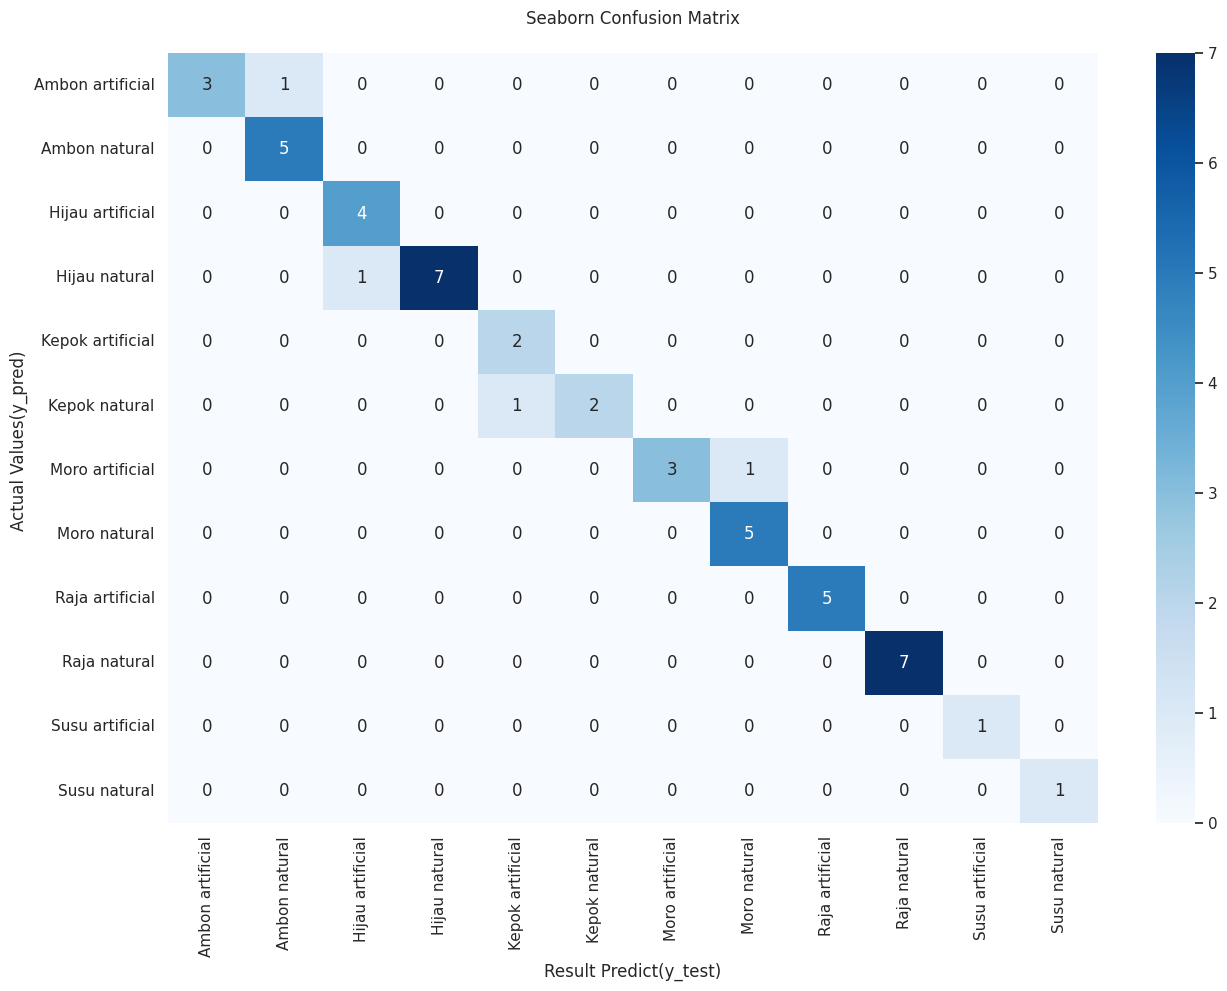

In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [121]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.83      1.00      0.91         5
           2       0.80      1.00      0.89         4
           3       1.00      0.88      0.93         8
           4       0.67      1.00      0.80         2
           5       1.00      0.67      0.80         3
           6       1.00      0.75      0.86         4
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1

    accuracy                           0.92        49
   macro avg       0.93      0.92      0.91        49
weighted avg       0.94      0.92      0.92        49



### MobileNet Evaluation

In [122]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.87890625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

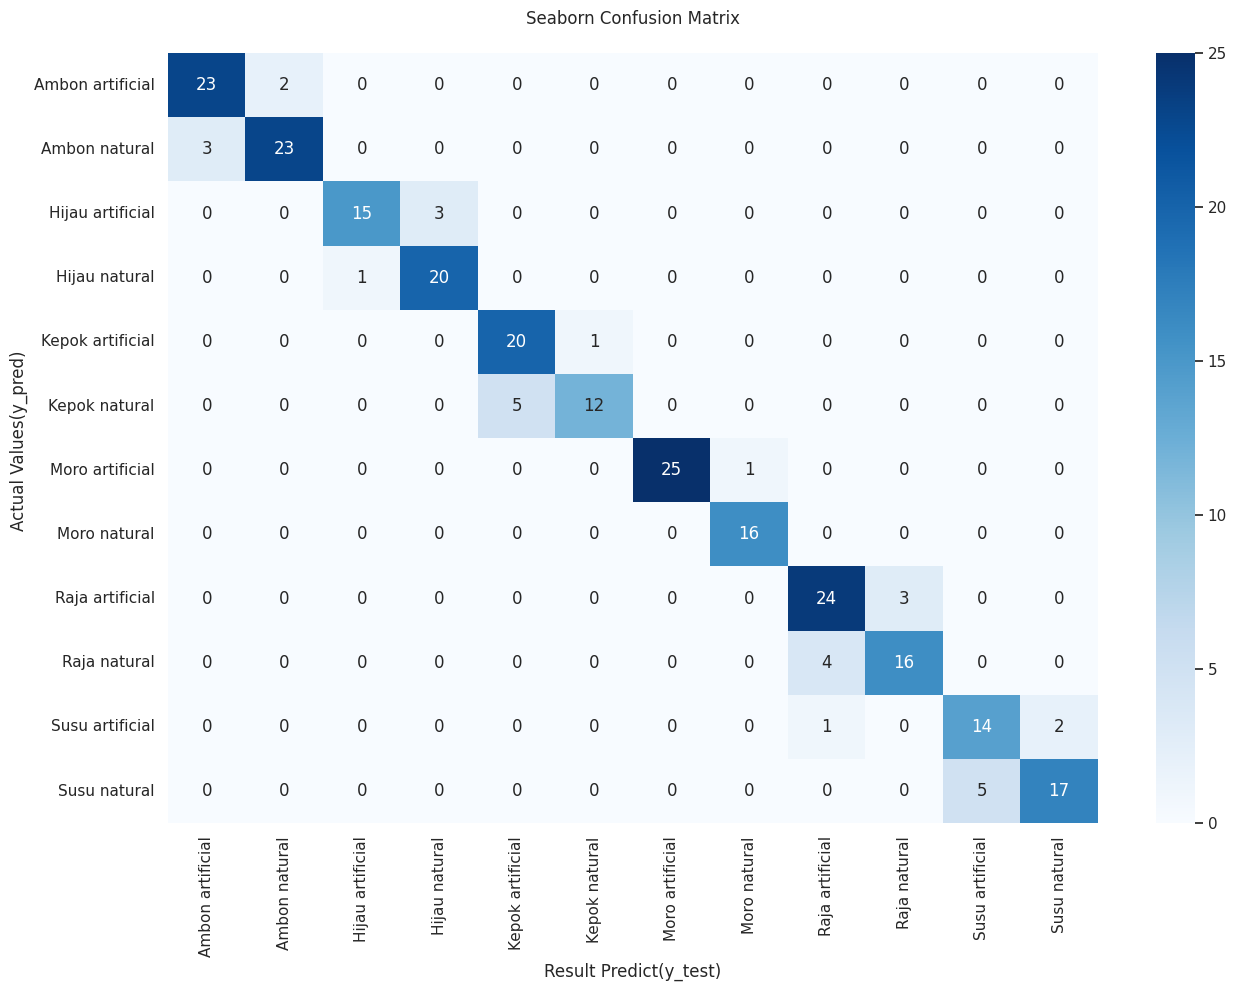

In [123]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [124]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        25
           1       0.92      0.88      0.90        26
           2       0.94      0.83      0.88        18
           3       0.87      0.95      0.91        21
           4       0.80      0.95      0.87        21
           5       0.92      0.71      0.80        17
           6       1.00      0.96      0.98        26
           7       0.94      1.00      0.97        16
           8       0.83      0.89      0.86        27
           9       0.84      0.80      0.82        20
          10       0.74      0.82      0.78        17
          11       0.89      0.77      0.83        22

    accuracy                           0.88       256
   macro avg       0.88      0.87      0.87       256
weighted avg       0.88      0.88      0.88       256



### Ensemble Evaluation

In [125]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.890625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

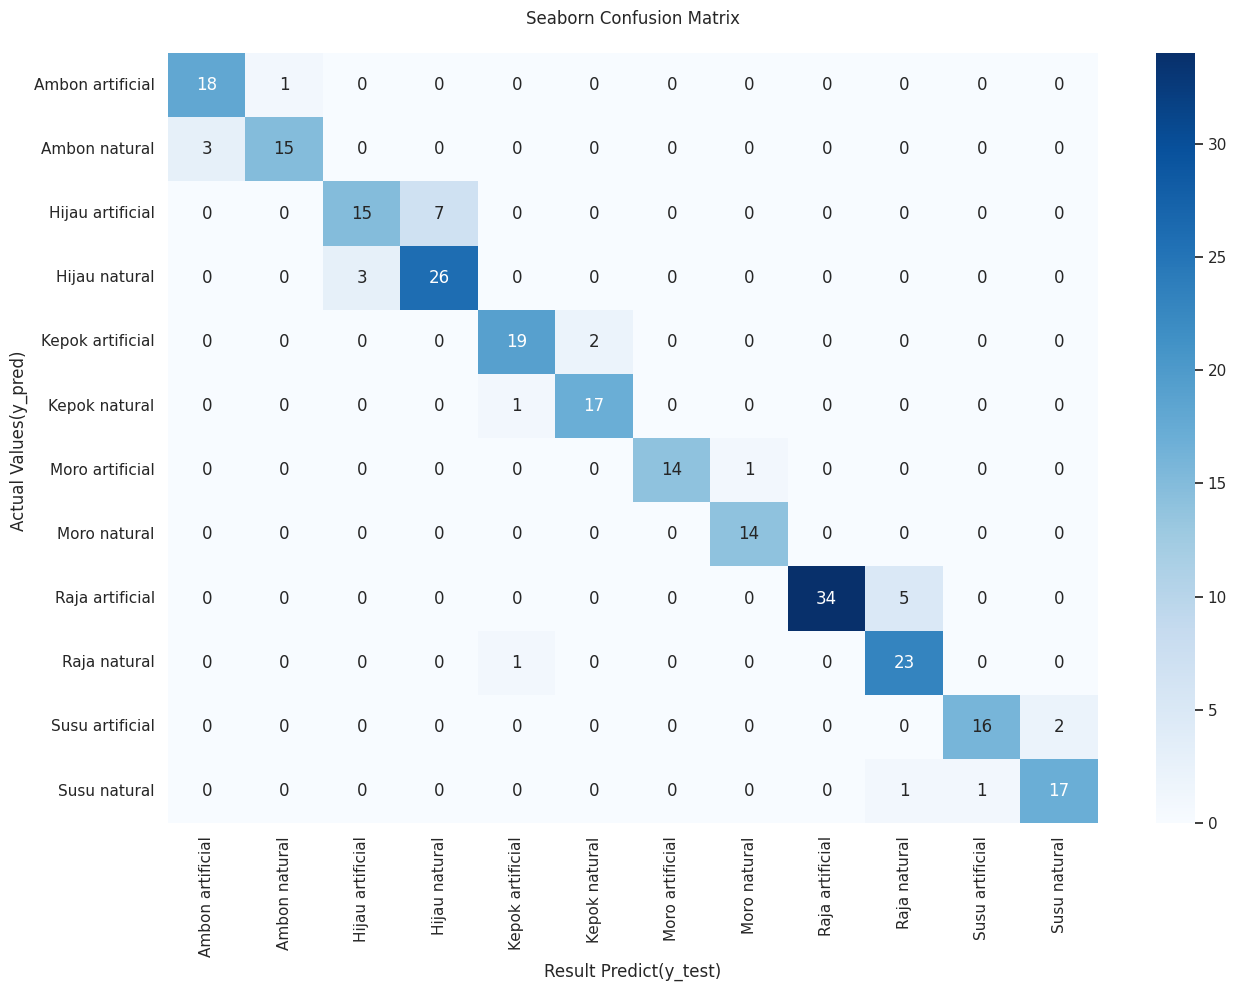

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [127]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.94      0.83      0.88        18
           2       0.83      0.68      0.75        22
           3       0.79      0.90      0.84        29
           4       0.90      0.90      0.90        21
           5       0.89      0.94      0.92        18
           6       1.00      0.93      0.97        15
           7       0.93      1.00      0.97        14
           8       1.00      0.87      0.93        39
           9       0.79      0.96      0.87        24
          10       0.94      0.89      0.91        18
          11       0.89      0.89      0.89        19

    accuracy                           0.89       256
   macro avg       0.90      0.90      0.89       256
weighted avg       0.90      0.89      0.89       256



## Pengujian 6 - SGD Dropout 0,4

In [128]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,4-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-dropout-0,4-completed.h5'

### Load ResNet Model

In [129]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [130]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [131]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [132]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [133]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [134]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 23ms/step


In [135]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 86ms/step


In [136]:
ensemble_resmob = (pred1+pred2)/2.0

In [137]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [138]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 11ms/step


In [139]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [140]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 131ms/step


In [141]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [142]:
!pip install seaborn

In [143]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.7109375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

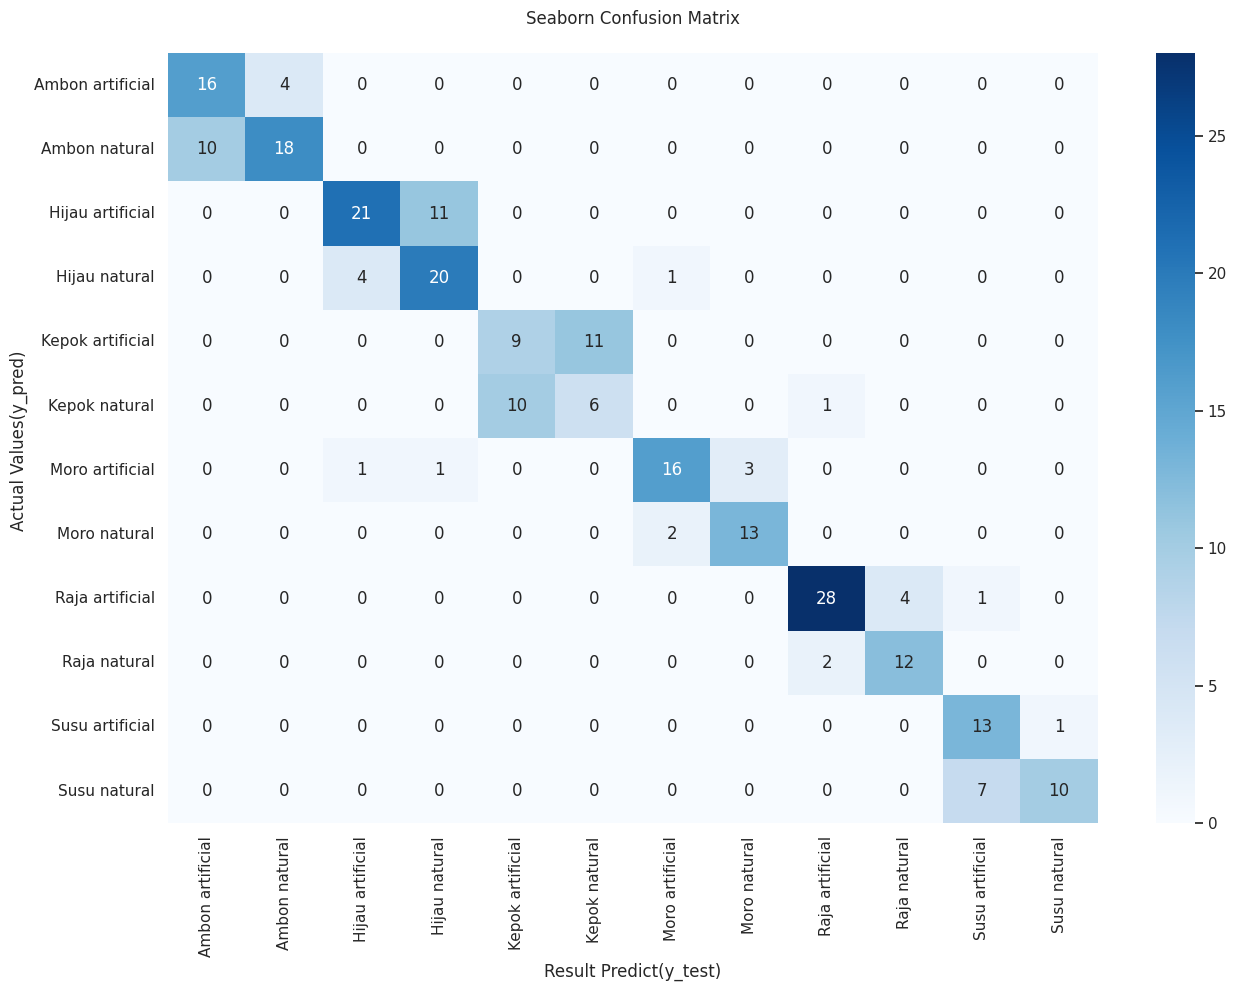

In [144]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [145]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        20
           1       0.82      0.64      0.72        28
           2       0.81      0.66      0.72        32
           3       0.62      0.80      0.70        25
           4       0.47      0.45      0.46        20
           5       0.35      0.35      0.35        17
           6       0.84      0.76      0.80        21
           7       0.81      0.87      0.84        15
           8       0.90      0.85      0.88        33
           9       0.75      0.86      0.80        14
          10       0.62      0.93      0.74        14
          11       0.91      0.59      0.71        17

    accuracy                           0.71       256
   macro avg       0.71      0.71      0.70       256
weighted avg       0.73      0.71      0.71       256



### MobileNet Evaluation

In [146]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.8828125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

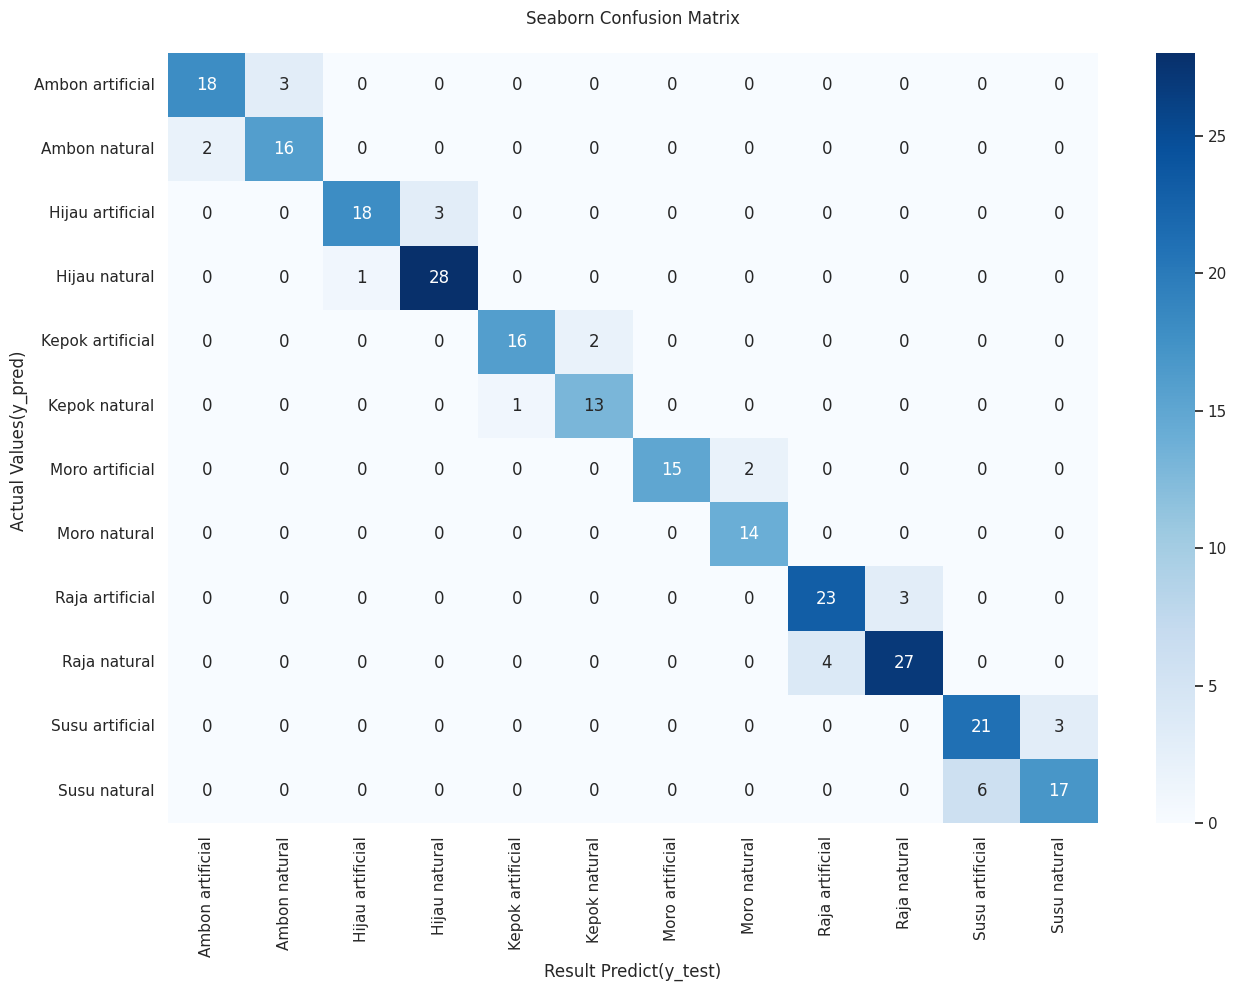

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [148]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.84      0.89      0.86        18
           2       0.95      0.86      0.90        21
           3       0.90      0.97      0.93        29
           4       0.94      0.89      0.91        18
           5       0.87      0.93      0.90        14
           6       1.00      0.88      0.94        17
           7       0.88      1.00      0.93        14
           8       0.85      0.88      0.87        26
           9       0.90      0.87      0.89        31
          10       0.78      0.88      0.82        24
          11       0.85      0.74      0.79        23

    accuracy                           0.88       256
   macro avg       0.89      0.89      0.89       256
weighted avg       0.89      0.88      0.88       256



### Ensemble Evaluation

In [149]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.8828125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

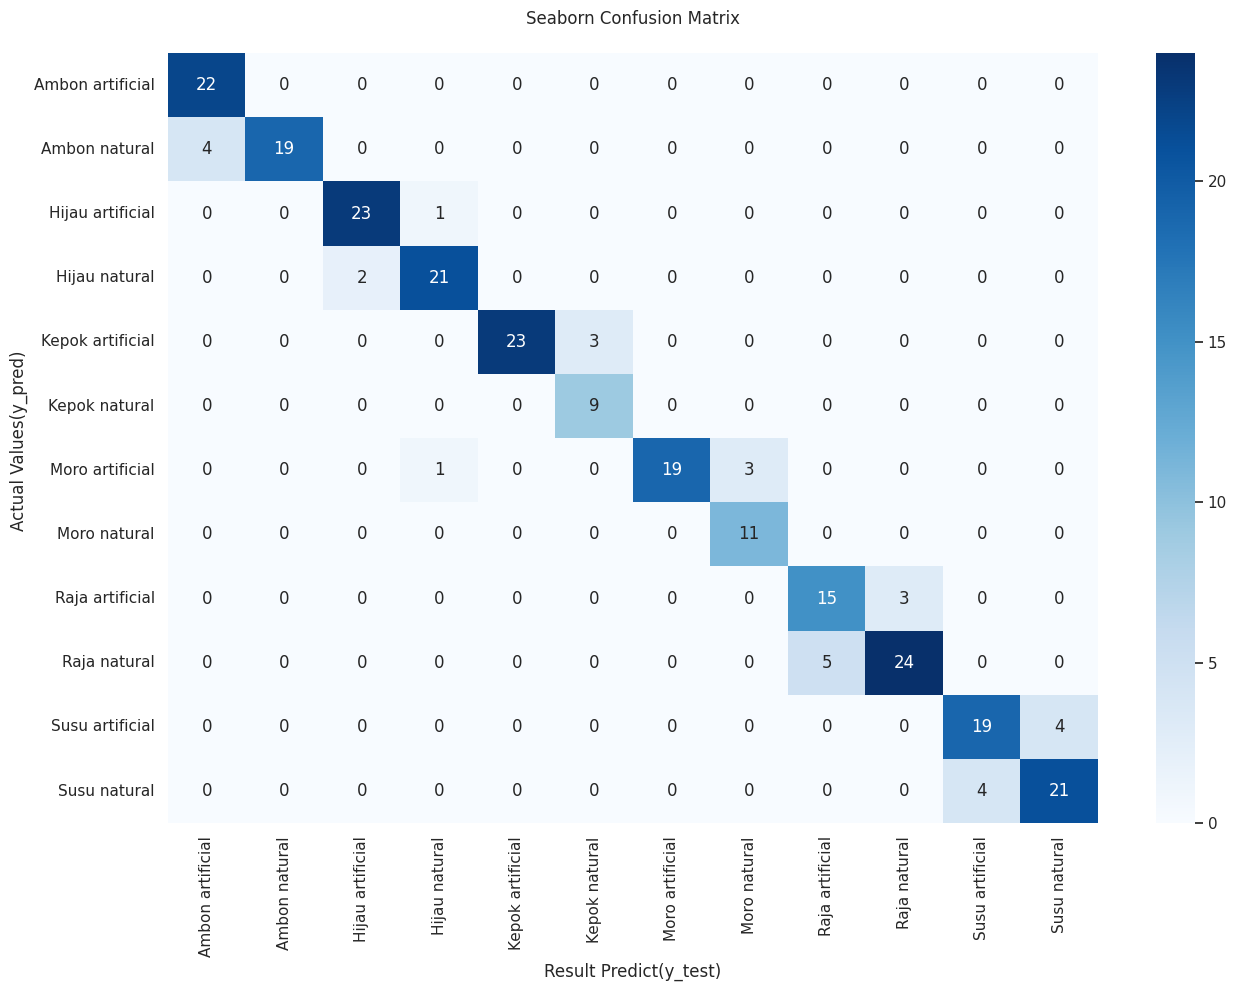

In [150]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [151]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        22
           1       1.00      0.83      0.90        23
           2       0.92      0.96      0.94        24
           3       0.91      0.91      0.91        23
           4       1.00      0.88      0.94        26
           5       0.75      1.00      0.86         9
           6       1.00      0.83      0.90        23
           7       0.79      1.00      0.88        11
           8       0.75      0.83      0.79        18
           9       0.89      0.83      0.86        29
          10       0.83      0.83      0.83        23
          11       0.84      0.84      0.84        25

    accuracy                           0.88       256
   macro avg       0.88      0.89      0.88       256
weighted avg       0.89      0.88      0.88       256



# Pengujian Dropout Learning Rate 0,0001

## Pengujian 3(1) - SGD Dropout 0,1 SGD 0,0001

In [8]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,1-lr-0,0001-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-dropout-0,1-lr-0,0001-completed.h5'

### Load ResNet Model

In [9]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

2024-01-04 16:01:40.832439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15452 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:af:00.0, compute capability: 7.5


### Load MobileNet Model

In [10]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [11]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [12]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [13]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [14]:
pred1 = modelMob.predict(x)

2024-01-04 16:02:04.090995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-01-04 16:02:04.735680: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 16:02:04.857312: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


8/8 [==============================] - 3s 19ms/step


In [15]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 77ms/step


In [16]:
ensemble_resmob = (pred1+pred2)/2.0

In [17]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [18]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 19ms/step


In [19]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [20]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 85ms/step


In [21]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [22]:
!pip install seaborn

In [23]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.7578125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

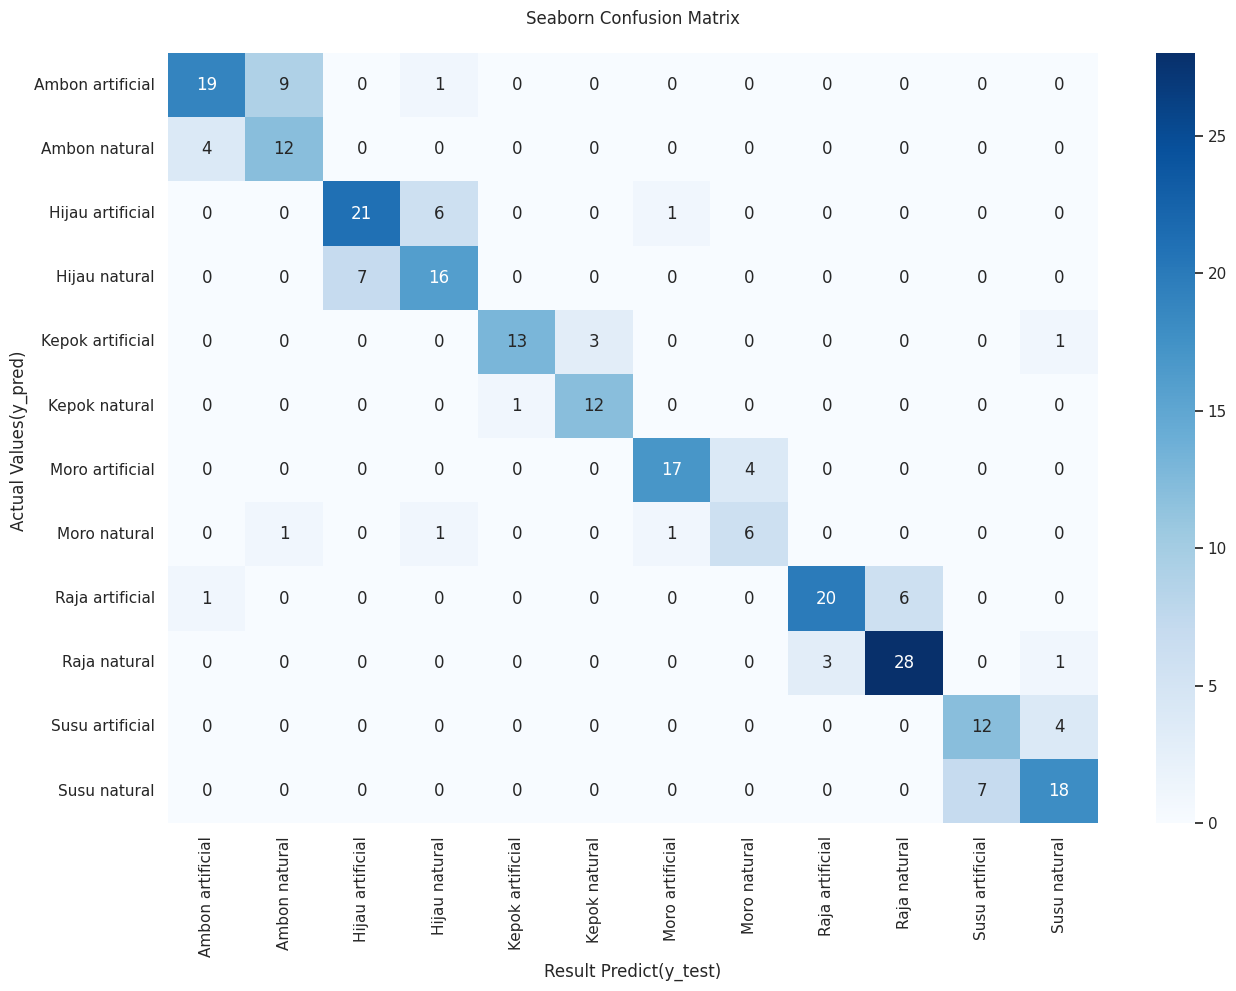

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [25]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.66      0.72        29
           1       0.55      0.75      0.63        16
           2       0.75      0.75      0.75        28
           3       0.67      0.70      0.68        23
           4       0.93      0.76      0.84        17
           5       0.80      0.92      0.86        13
           6       0.89      0.81      0.85        21
           7       0.60      0.67      0.63         9
           8       0.87      0.74      0.80        27
           9       0.82      0.88      0.85        32
          10       0.63      0.75      0.69        16
          11       0.75      0.72      0.73        25

    accuracy                           0.76       256
   macro avg       0.75      0.76      0.75       256
weighted avg       0.77      0.76      0.76       256



### MobileNet Evaluation

In [26]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.46484375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

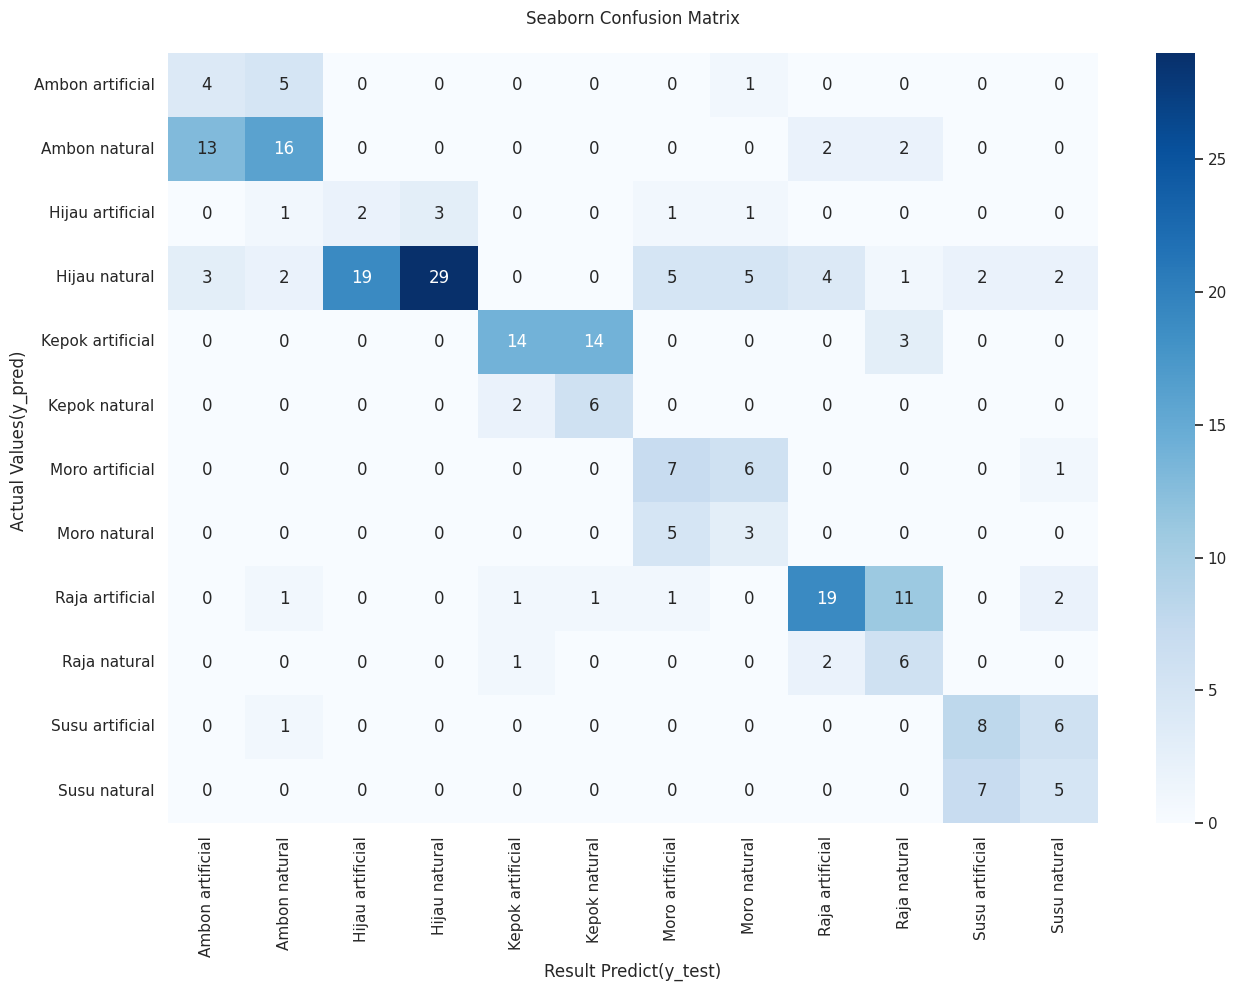

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [28]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.20      0.40      0.27        10
           1       0.62      0.48      0.54        33
           2       0.10      0.25      0.14         8
           3       0.91      0.40      0.56        72
           4       0.78      0.45      0.57        31
           5       0.29      0.75      0.41         8
           6       0.37      0.50      0.42        14
           7       0.19      0.38      0.25         8
           8       0.70      0.53      0.60        36
           9       0.26      0.67      0.38         9
          10       0.47      0.53      0.50        15
          11       0.31      0.42      0.36        12

    accuracy                           0.46       256
   macro avg       0.43      0.48      0.42       256
weighted avg       0.62      0.46      0.50       256



### Ensemble Evaluation

In [29]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.76171875


Text(153.75, 0.5, 'Actual Values(y_pred) ')

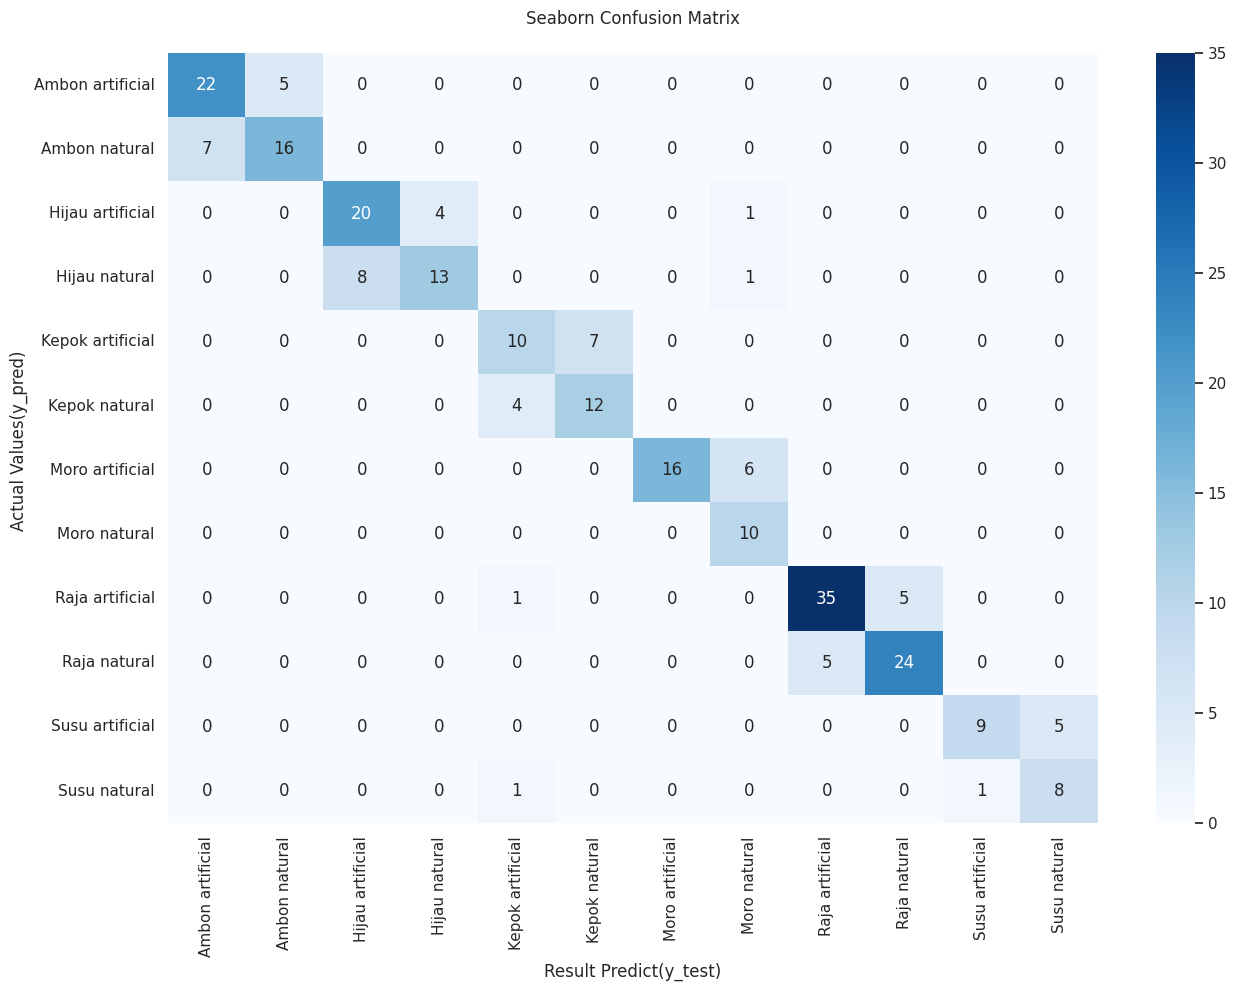

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [31]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.81      0.79        27
           1       0.76      0.70      0.73        23
           2       0.71      0.80      0.75        25
           3       0.76      0.59      0.67        22
           4       0.62      0.59      0.61        17
           5       0.63      0.75      0.69        16
           6       1.00      0.73      0.84        22
           7       0.56      1.00      0.71        10
           8       0.88      0.85      0.86        41
           9       0.83      0.83      0.83        29
          10       0.90      0.64      0.75        14
          11       0.62      0.80      0.70        10

    accuracy                           0.76       256
   macro avg       0.75      0.76      0.74       256
weighted avg       0.78      0.76      0.76       256



## Pengujian 4(1) - SGD Dropout 0,2 LR 0,0001

In [32]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,2-lr-0,0001-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-dropout-0,2-lr-0,0001-completed.h5'

### Load ResNet Model

In [33]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [34]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [35]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [36]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [37]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [38]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 18ms/step


In [39]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 90ms/step


In [40]:
ensemble_resmob = (pred1+pred2)/2.0

In [41]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [42]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 18ms/step


In [43]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [44]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 82ms/step


In [45]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [46]:
!pip install seaborn

In [47]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.796875


Text(153.75, 0.5, 'Actual Values(y_pred) ')

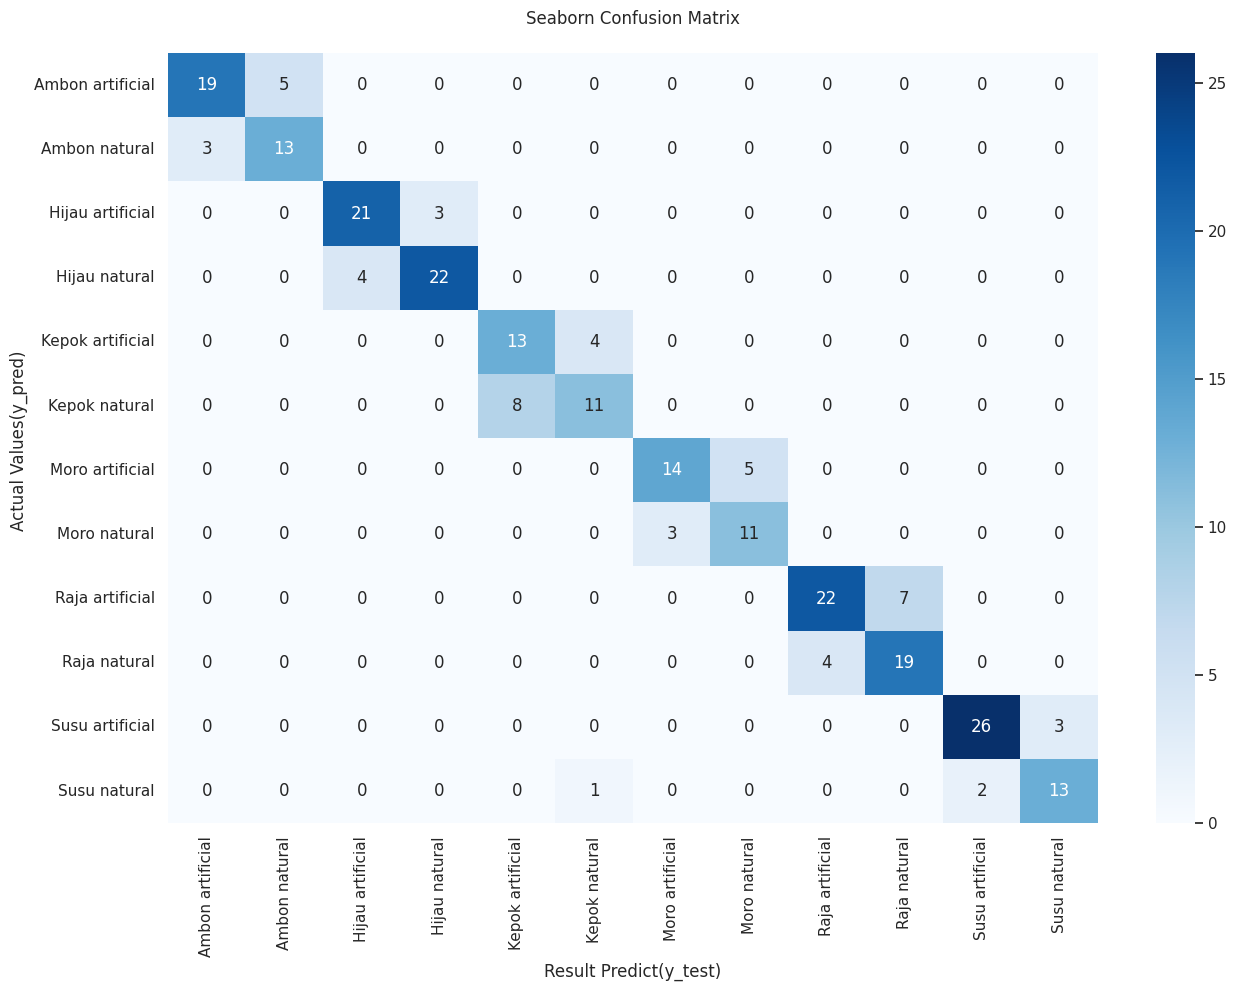

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [49]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.79      0.83        24
           1       0.72      0.81      0.76        16
           2       0.84      0.88      0.86        24
           3       0.88      0.85      0.86        26
           4       0.62      0.76      0.68        17
           5       0.69      0.58      0.63        19
           6       0.82      0.74      0.78        19
           7       0.69      0.79      0.73        14
           8       0.85      0.76      0.80        29
           9       0.73      0.83      0.78        23
          10       0.93      0.90      0.91        29
          11       0.81      0.81      0.81        16

    accuracy                           0.80       256
   macro avg       0.79      0.79      0.79       256
weighted avg       0.80      0.80      0.80       256



### MobileNet Evaluation

In [50]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.4765625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

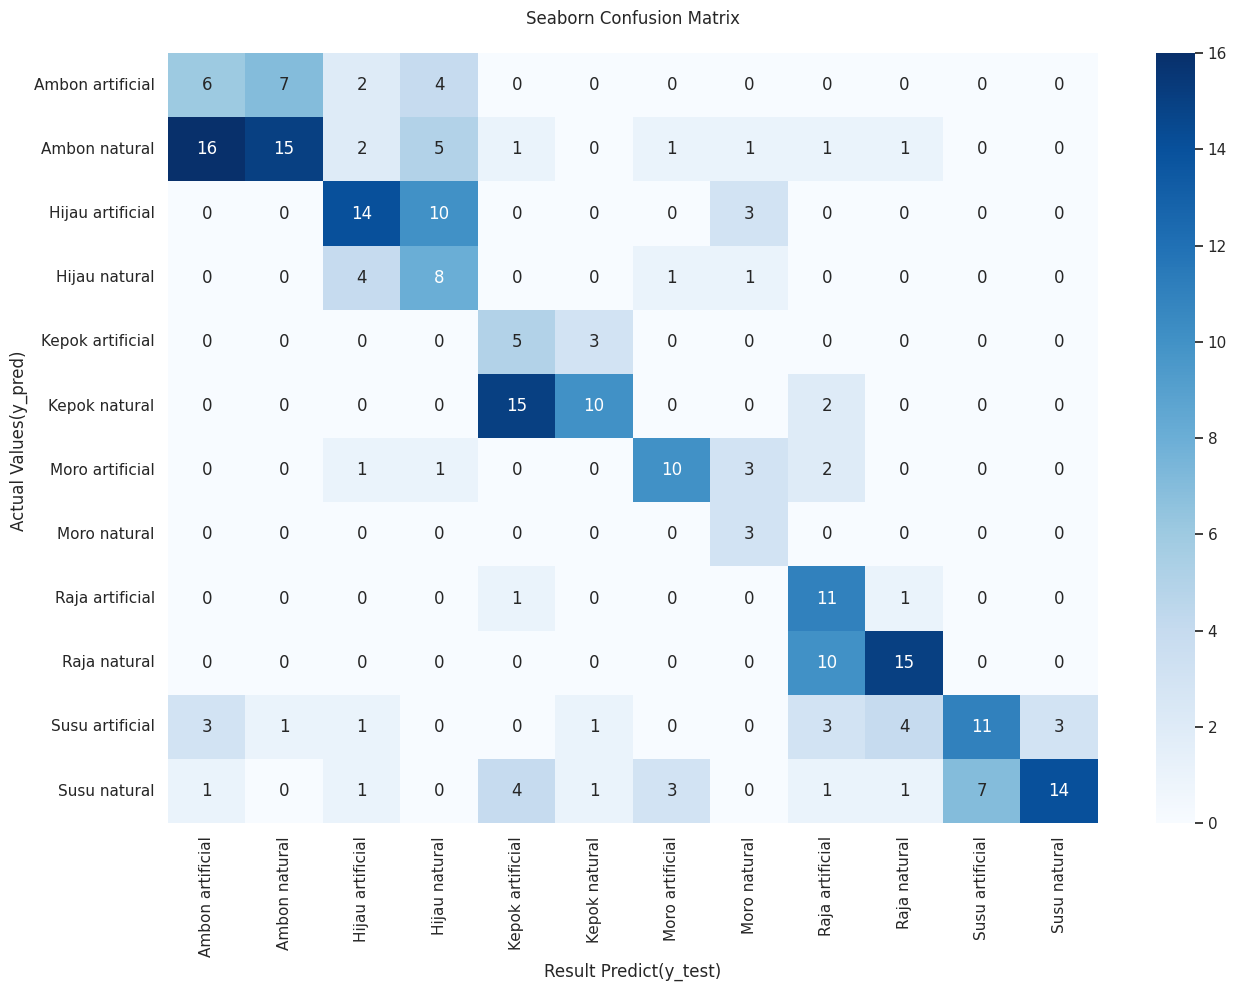

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [52]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.23      0.32      0.27        19
           1       0.65      0.35      0.45        43
           2       0.56      0.52      0.54        27
           3       0.29      0.57      0.38        14
           4       0.19      0.62      0.29         8
           5       0.67      0.37      0.48        27
           6       0.67      0.59      0.62        17
           7       0.27      1.00      0.43         3
           8       0.37      0.85      0.51        13
           9       0.68      0.60      0.64        25
          10       0.61      0.41      0.49        27
          11       0.82      0.42      0.56        33

    accuracy                           0.48       256
   macro avg       0.50      0.55      0.47       256
weighted avg       0.58      0.48      0.49       256



### Ensemble Evaluation

In [53]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.78515625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

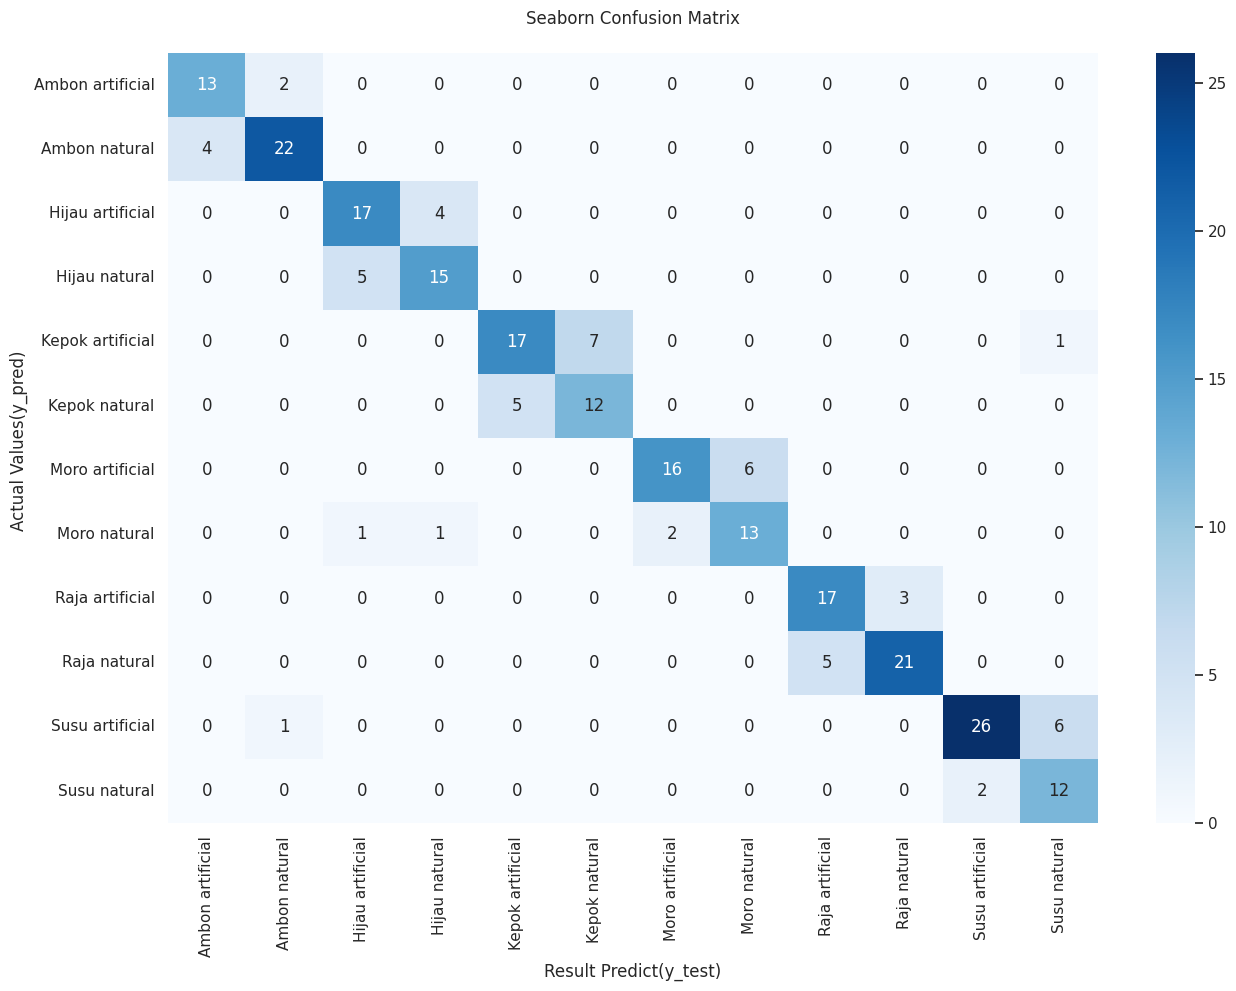

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [55]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.88      0.85      0.86        26
           2       0.74      0.81      0.77        21
           3       0.75      0.75      0.75        20
           4       0.77      0.68      0.72        25
           5       0.63      0.71      0.67        17
           6       0.89      0.73      0.80        22
           7       0.68      0.76      0.72        17
           8       0.77      0.85      0.81        20
           9       0.88      0.81      0.84        26
          10       0.93      0.79      0.85        33
          11       0.63      0.86      0.73        14

    accuracy                           0.79       256
   macro avg       0.78      0.79      0.78       256
weighted avg       0.80      0.79      0.79       256



## Pengujian 5(1) - SGD Dropout 0,3 LR 0,0001

In [56]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,3-lr-0,0001-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-dropout-0,3-lr-0,0001-completed.h5'

### Load ResNet Model

In [57]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [58]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [59]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [60]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [61]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [62]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 20ms/step


In [63]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 87ms/step


In [64]:
ensemble_resmob = (pred1+pred2)/2.0

In [65]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [66]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 19ms/step


In [67]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [68]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 84ms/step


In [69]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [70]:
!pip install seaborn

In [71]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.80078125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

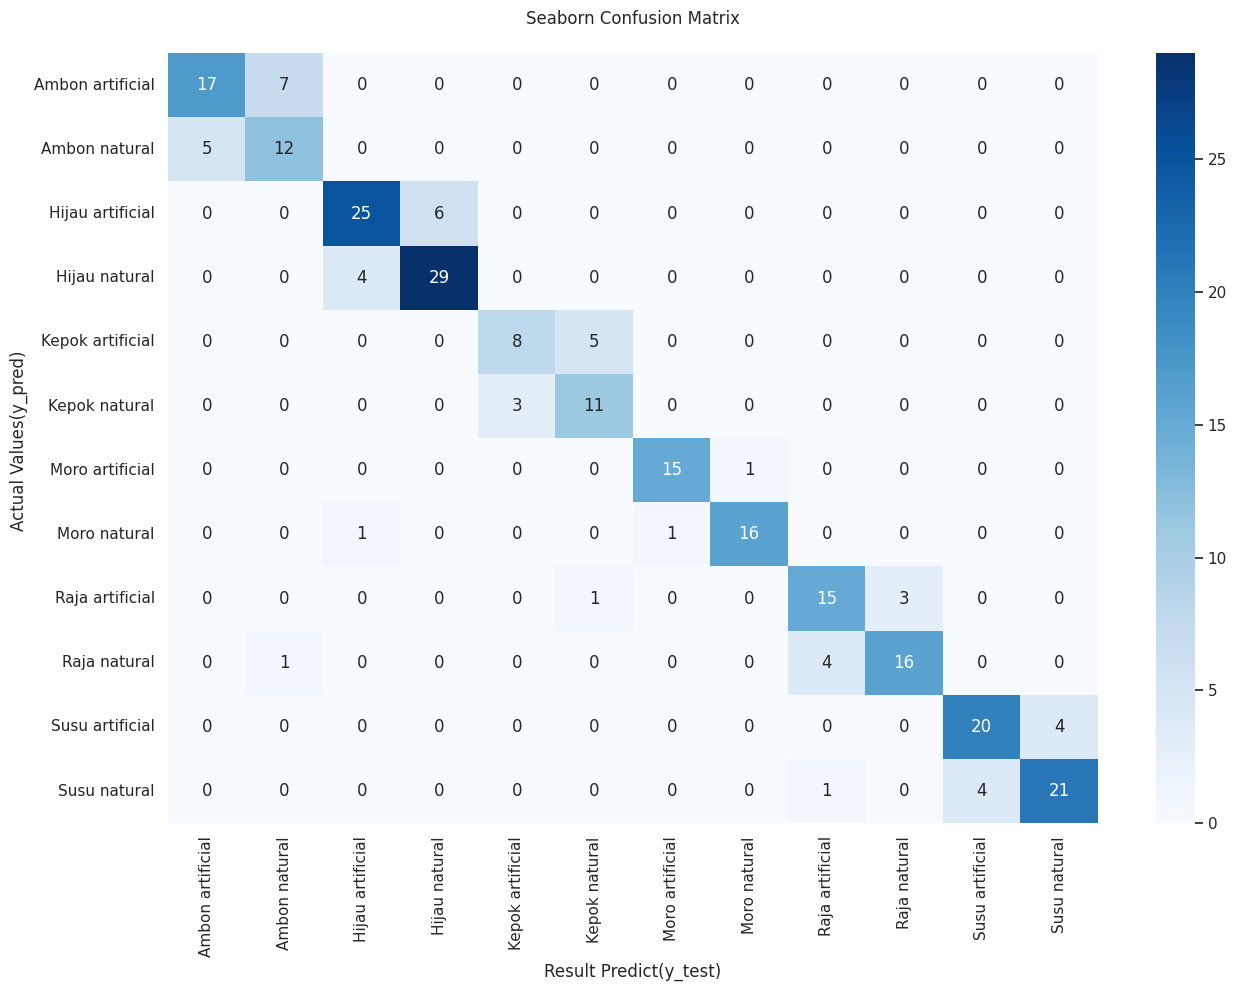

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [73]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        24
           1       0.60      0.71      0.65        17
           2       0.83      0.81      0.82        31
           3       0.83      0.88      0.85        33
           4       0.73      0.62      0.67        13
           5       0.65      0.79      0.71        14
           6       0.94      0.94      0.94        16
           7       0.94      0.89      0.91        18
           8       0.75      0.79      0.77        19
           9       0.84      0.76      0.80        21
          10       0.83      0.83      0.83        24
          11       0.84      0.81      0.82        26

    accuracy                           0.80       256
   macro avg       0.80      0.79      0.79       256
weighted avg       0.81      0.80      0.80       256



### MobileNet Evaluation

In [74]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.53515625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

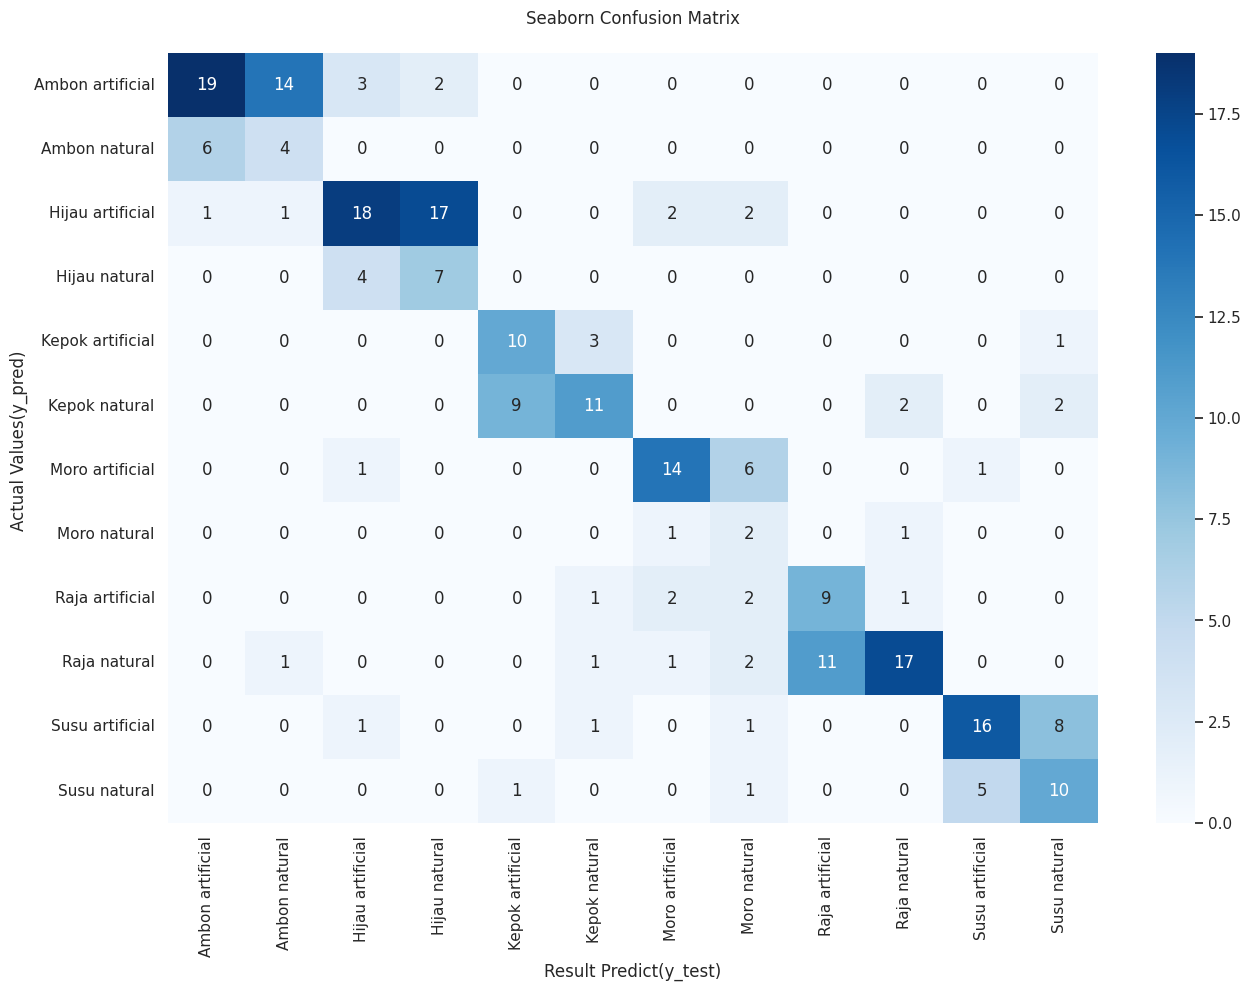

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [76]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.50      0.59        38
           1       0.20      0.40      0.27        10
           2       0.67      0.44      0.53        41
           3       0.27      0.64      0.38        11
           4       0.50      0.71      0.59        14
           5       0.65      0.46      0.54        24
           6       0.70      0.64      0.67        22
           7       0.12      0.50      0.20         4
           8       0.45      0.60      0.51        15
           9       0.81      0.52      0.63        33
          10       0.73      0.59      0.65        27
          11       0.48      0.59      0.53        17

    accuracy                           0.54       256
   macro avg       0.53      0.55      0.51       256
weighted avg       0.62      0.54      0.56       256



### Ensemble Evaluation

In [77]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.80859375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

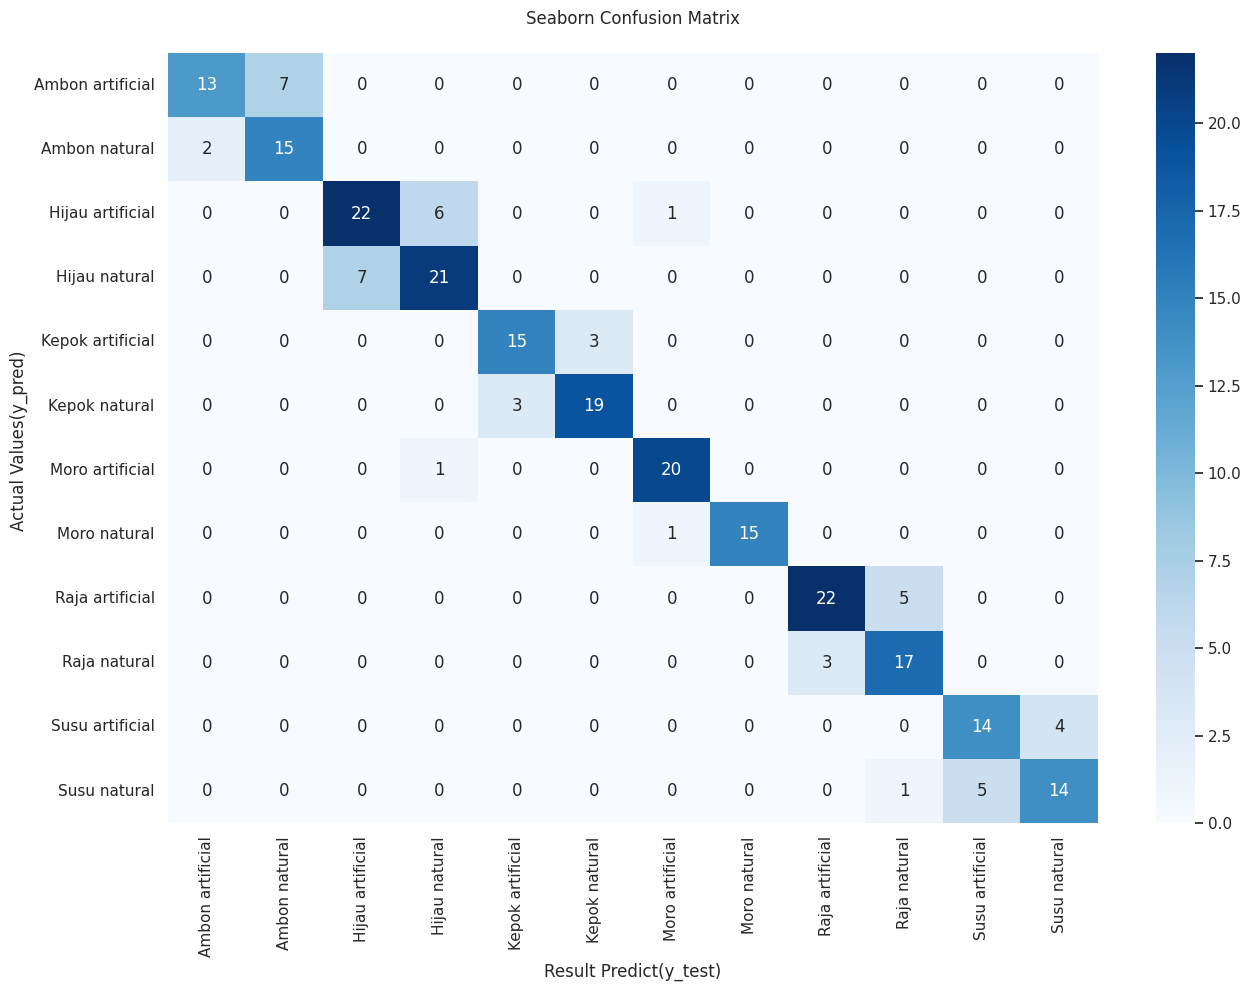

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [79]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.65      0.74        20
           1       0.68      0.88      0.77        17
           2       0.76      0.76      0.76        29
           3       0.75      0.75      0.75        28
           4       0.83      0.83      0.83        18
           5       0.86      0.86      0.86        22
           6       0.91      0.95      0.93        21
           7       1.00      0.94      0.97        16
           8       0.88      0.81      0.85        27
           9       0.74      0.85      0.79        20
          10       0.74      0.78      0.76        18
          11       0.78      0.70      0.74        20

    accuracy                           0.81       256
   macro avg       0.82      0.81      0.81       256
weighted avg       0.81      0.81      0.81       256



## Pengujian 6(1) - SGD Dropout 0,4 LR 0,0001

In [80]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,4-lr-0,0001-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-dropout-0,4-lr-0,0001-completed.h5'

### Load ResNet Model

In [81]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [82]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [83]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [84]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [85]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [86]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 18ms/step


In [87]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 86ms/step


In [88]:
ensemble_resmob = (pred1+pred2)/2.0

In [89]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [90]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 18ms/step


In [91]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [92]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 85ms/step


In [93]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [94]:
!pip install seaborn

In [95]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.76953125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

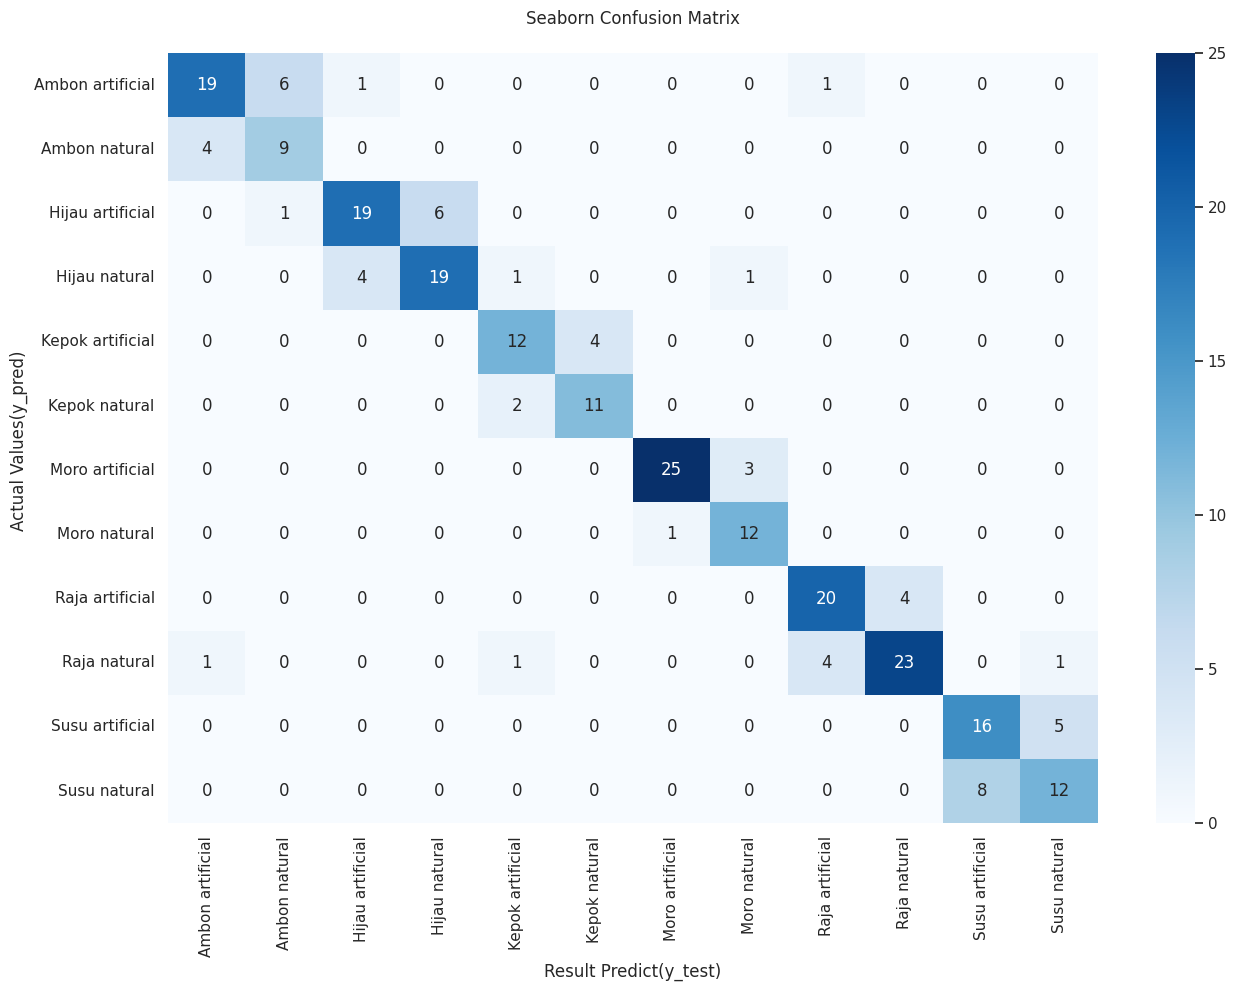

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [97]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.70      0.75        27
           1       0.56      0.69      0.62        13
           2       0.79      0.73      0.76        26
           3       0.76      0.76      0.76        25
           4       0.75      0.75      0.75        16
           5       0.73      0.85      0.79        13
           6       0.96      0.89      0.93        28
           7       0.75      0.92      0.83        13
           8       0.80      0.83      0.82        24
           9       0.85      0.77      0.81        30
          10       0.67      0.76      0.71        21
          11       0.67      0.60      0.63        20

    accuracy                           0.77       256
   macro avg       0.76      0.77      0.76       256
weighted avg       0.78      0.77      0.77       256



### MobileNet Evaluation

In [98]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.5390625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

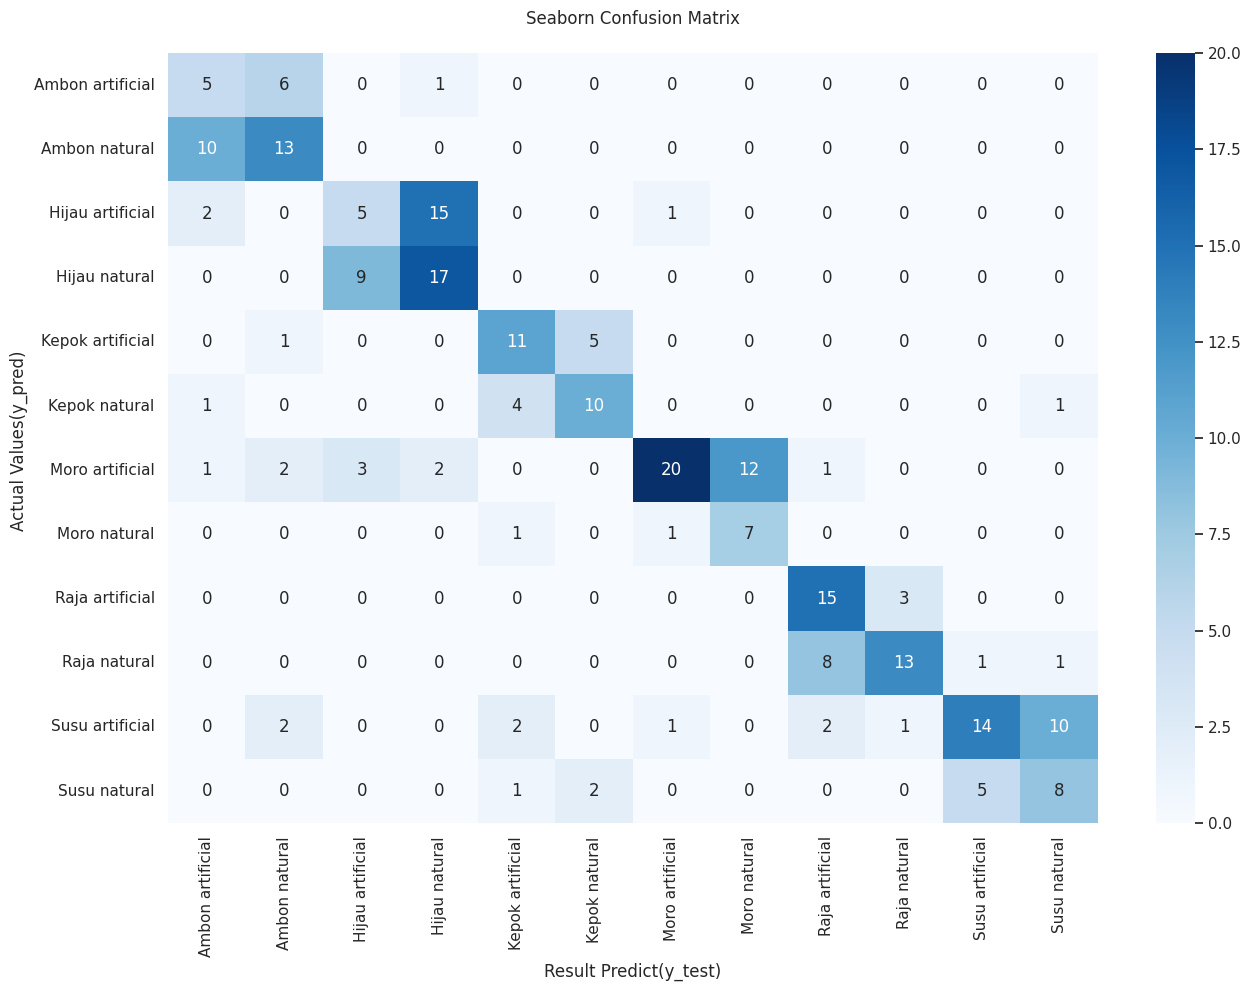

In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [100]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.26      0.42      0.32        12
           1       0.54      0.57      0.55        23
           2       0.29      0.22      0.25        23
           3       0.49      0.65      0.56        26
           4       0.58      0.65      0.61        17
           5       0.59      0.62      0.61        16
           6       0.87      0.49      0.62        41
           7       0.37      0.78      0.50         9
           8       0.58      0.83      0.68        18
           9       0.76      0.57      0.65        23
          10       0.70      0.44      0.54        32
          11       0.40      0.50      0.44        16

    accuracy                           0.54       256
   macro avg       0.54      0.56      0.53       256
weighted avg       0.59      0.54      0.54       256



### Ensemble Evaluation

In [101]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.77734375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

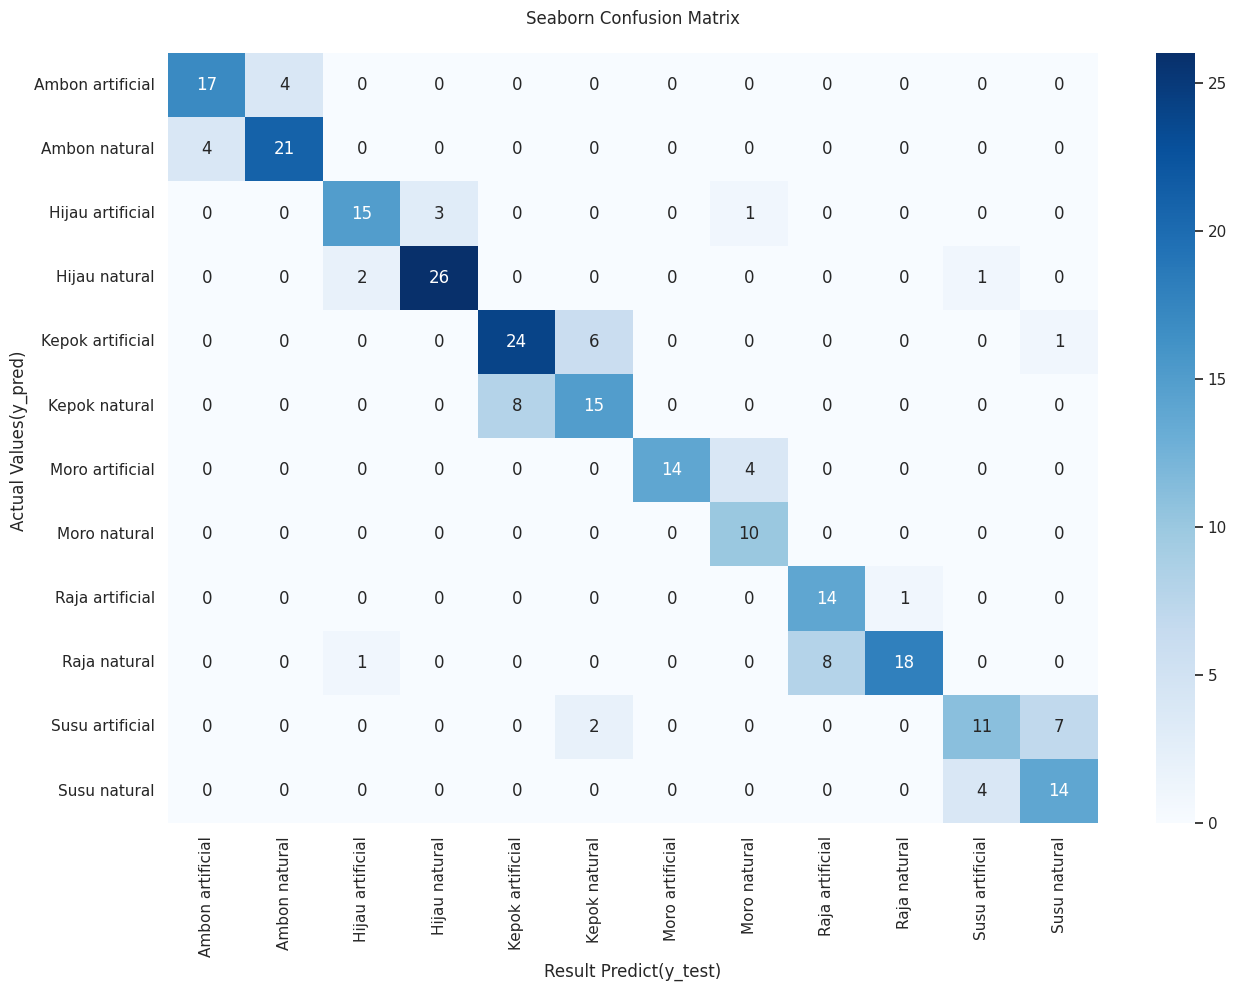

In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [103]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.84      0.84      0.84        25
           2       0.83      0.79      0.81        19
           3       0.90      0.90      0.90        29
           4       0.75      0.77      0.76        31
           5       0.65      0.65      0.65        23
           6       1.00      0.78      0.88        18
           7       0.67      1.00      0.80        10
           8       0.64      0.93      0.76        15
           9       0.95      0.67      0.78        27
          10       0.69      0.55      0.61        20
          11       0.64      0.78      0.70        18

    accuracy                           0.78       256
   macro avg       0.78      0.79      0.77       256
weighted avg       0.79      0.78      0.78       256



# Pengujian Learning Rate SGD

## Pengujian 7 - SGD 0,1

In [104]:
model_resnet = 'new_test/new-test-resnet-sgd-0,1-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-0,1-completed.h5'

### Load ResNet Model

In [105]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [106]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [107]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [108]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [109]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  49  y:  49


### Testing Ensemble Averaging

In [110]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 18ms/step


In [111]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 88ms/step


In [112]:
ensemble_resmob = (pred1+pred2)/2.0

In [113]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [114]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 17ms/step


In [115]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [116]:
predResnet = modelRes.predict(x2)

2/2 [==============================] - 3s 516ms/step


In [117]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [118]:
!pip install seaborn

In [119]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.6938775510204082


Text(153.75, 0.5, 'Actual Values(y_pred) ')

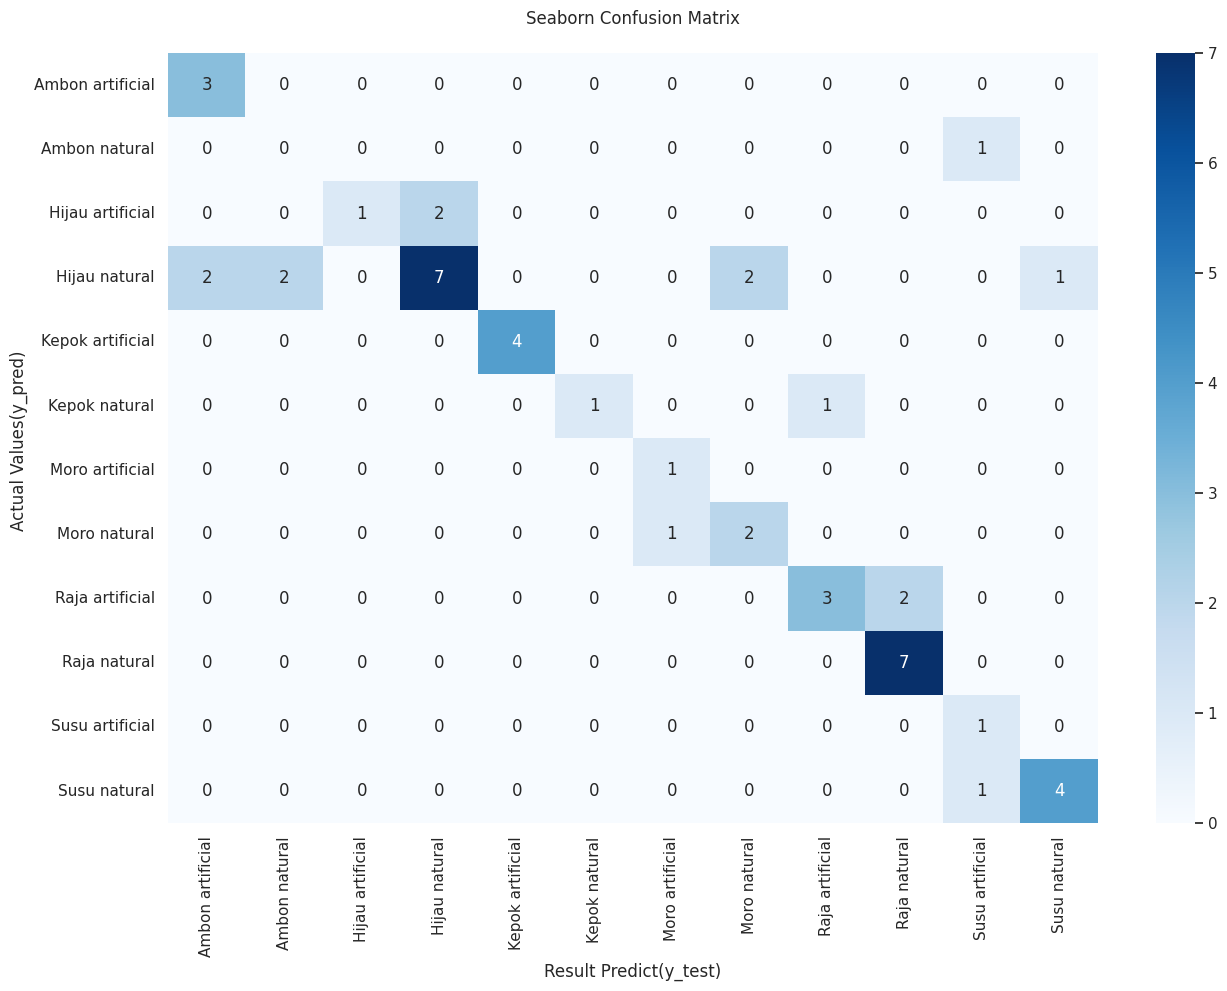

In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [121]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         1
           2       1.00      0.33      0.50         3
           3       0.78      0.50      0.61        14
           4       1.00      1.00      1.00         4
           5       1.00      0.50      0.67         2
           6       0.50      1.00      0.67         1
           7       0.50      0.67      0.57         3
           8       0.75      0.60      0.67         5
           9       0.78      1.00      0.88         7
          10       0.33      1.00      0.50         1
          11       0.80      0.80      0.80         5

    accuracy                           0.69        49
   macro avg       0.67      0.70      0.63        49
weighted avg       0.76      0.69      0.69        49



### MobileNet Evaluation

In [122]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.07421875


Text(153.75, 0.5, 'Actual Values(y_pred) ')

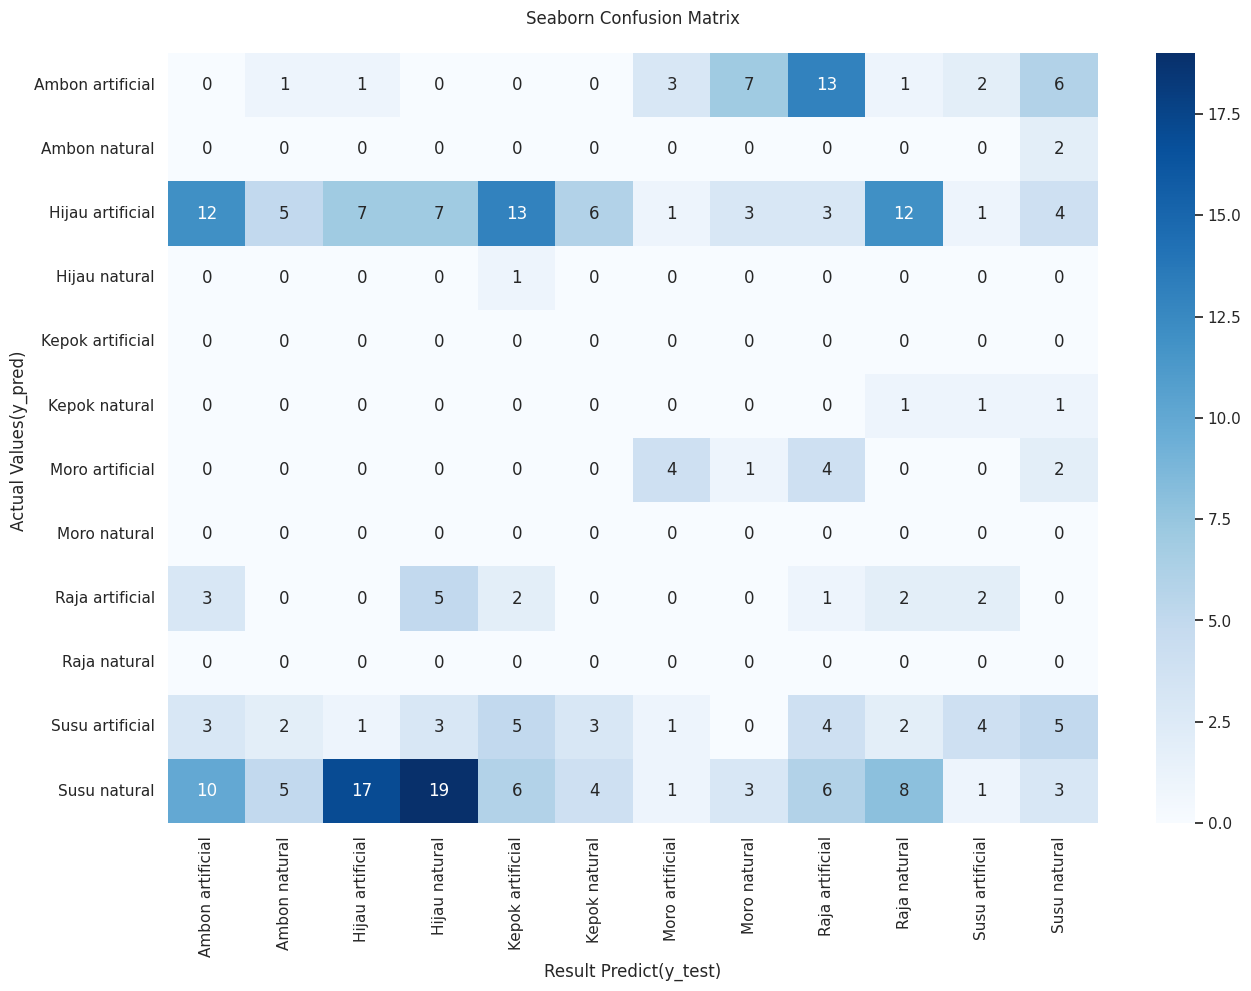

In [123]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [124]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.00      0.00      0.00         2
           2       0.27      0.09      0.14        74
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         3
           6       0.40      0.36      0.38        11
           7       0.00      0.00      0.00         0
           8       0.03      0.07      0.04        15
           9       0.00      0.00      0.00         0
          10       0.36      0.12      0.18        33
          11       0.13      0.04      0.06        83

    accuracy                           0.07       256
   macro avg       0.10      0.06      0.07       256
weighted avg       0.19      0.07      0.10       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Evaluation

In [125]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.1640625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

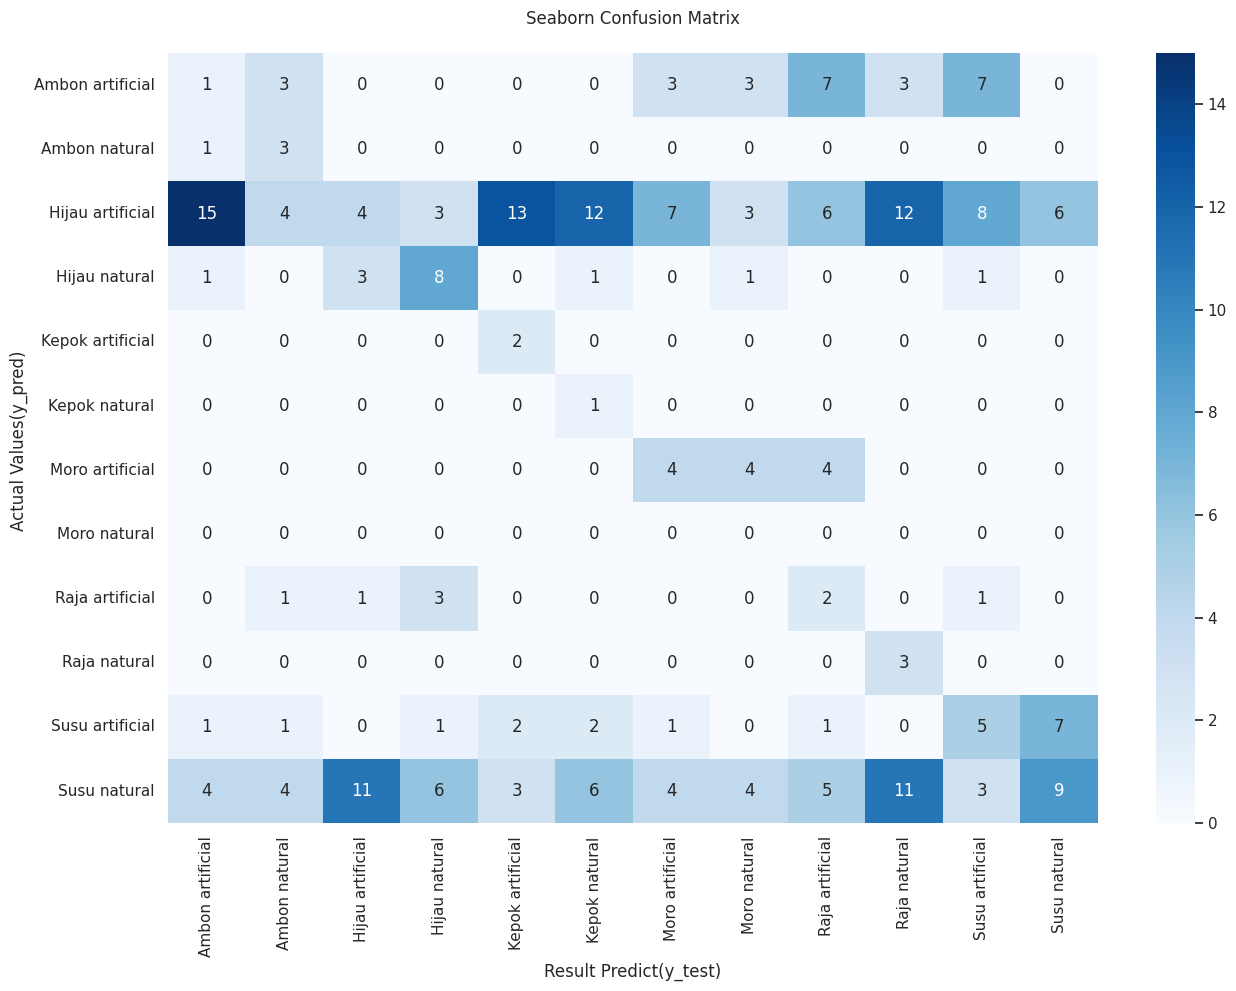

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [127]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.04      0.04      0.04        27
           1       0.19      0.75      0.30         4
           2       0.21      0.04      0.07        93
           3       0.38      0.53      0.44        15
           4       0.10      1.00      0.18         2
           5       0.05      1.00      0.09         1
           6       0.21      0.33      0.26        12
           7       0.00      0.00      0.00         0
           8       0.08      0.25      0.12         8
           9       0.10      1.00      0.19         3
          10       0.20      0.24      0.22        21
          11       0.41      0.13      0.20        70

    accuracy                           0.16       256
   macro avg       0.16      0.44      0.18       256
weighted avg       0.25      0.16      0.15       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Pengujian 8 - SGD 0,2

In [128]:
model_resnet = 'new_test/new-test-resnet-sgd-0,2-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-0,2-completed.h5'

### Load ResNet Model

In [129]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [130]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [131]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [132]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [133]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [134]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 19ms/step


In [135]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 88ms/step


In [136]:
ensemble_resmob = (pred1+pred2)/2.0

In [137]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [138]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 18ms/step


In [139]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [140]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 84ms/step


In [141]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [142]:
!pip install seaborn

In [143]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.71484375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

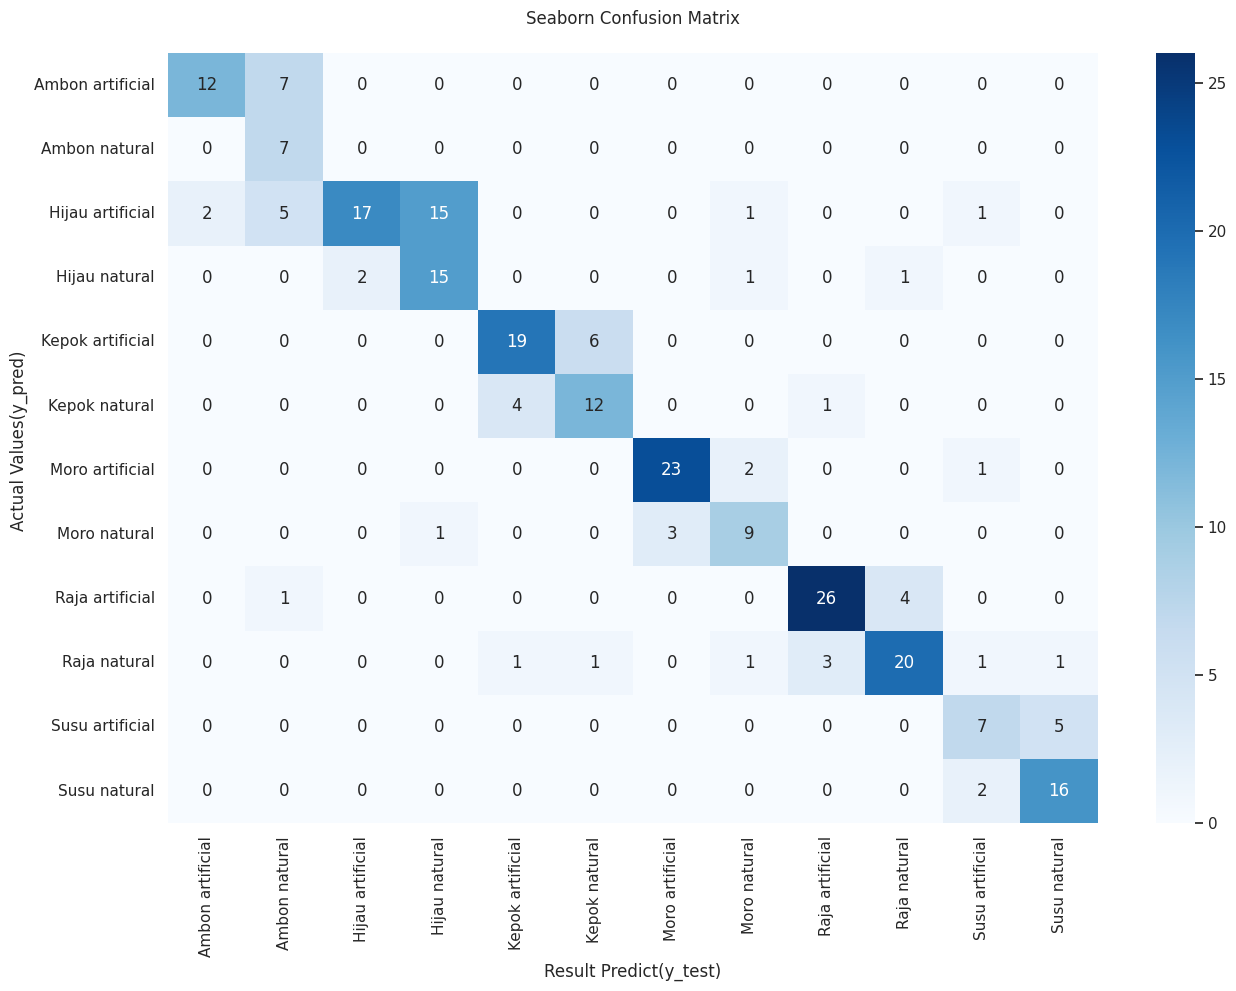

In [144]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [145]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.63      0.73        19
           1       0.35      1.00      0.52         7
           2       0.89      0.41      0.57        41
           3       0.48      0.79      0.60        19
           4       0.79      0.76      0.78        25
           5       0.63      0.71      0.67        17
           6       0.88      0.88      0.88        26
           7       0.64      0.69      0.67        13
           8       0.87      0.84      0.85        31
           9       0.80      0.71      0.75        28
          10       0.58      0.58      0.58        12
          11       0.73      0.89      0.80        18

    accuracy                           0.71       256
   macro avg       0.71      0.74      0.70       256
weighted avg       0.77      0.71      0.72       256



### MobileNet Evaluation

In [146]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.09375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

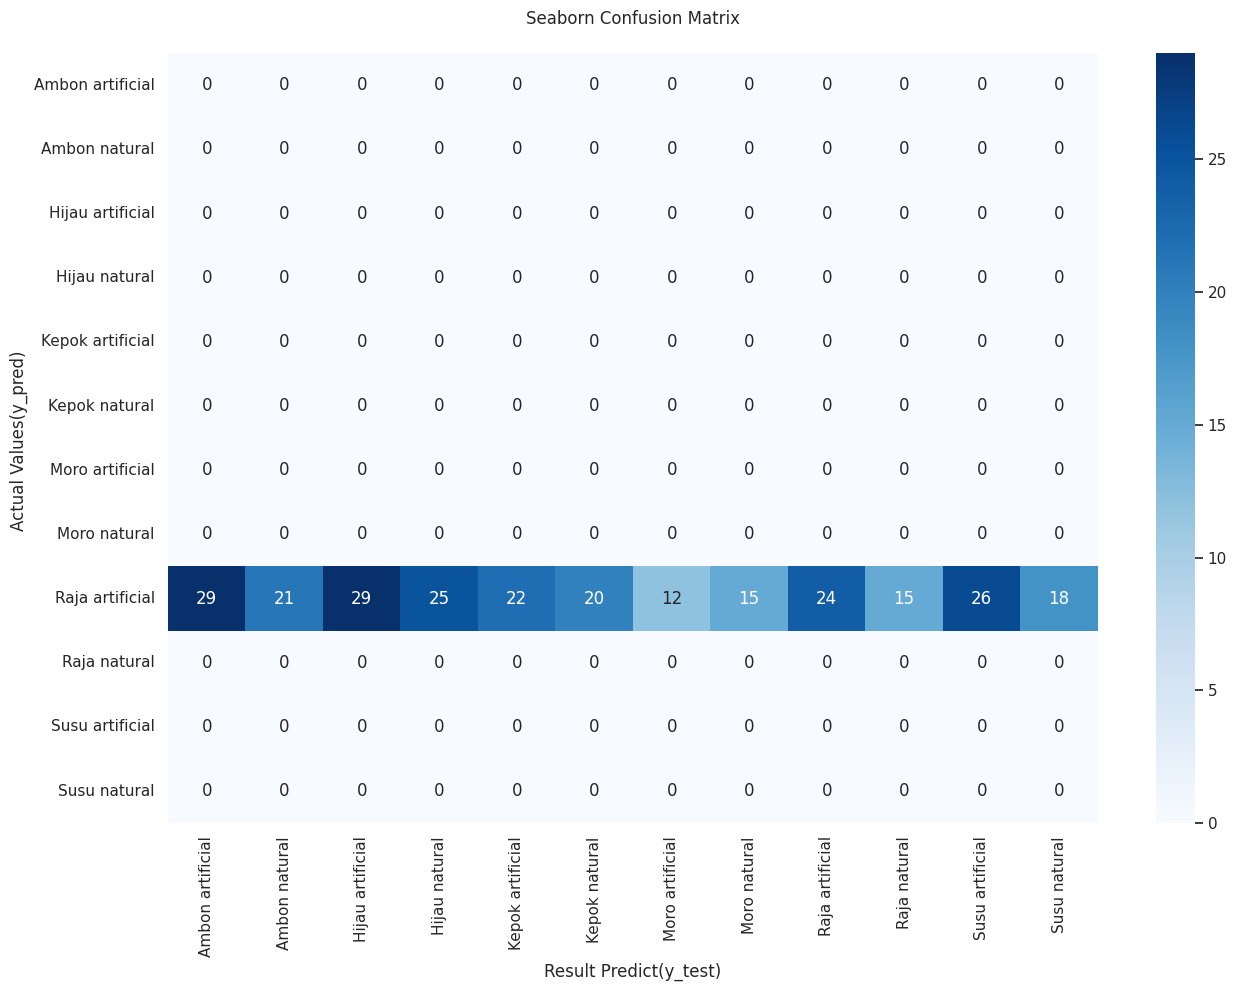

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [148]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       1.00      0.09      0.17       256
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0

    accuracy                           0.09       256
   macro avg       0.08      0.01      0.01       256
weighted avg       1.00      0.09      0.17       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Evaluation

In [149]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.36328125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

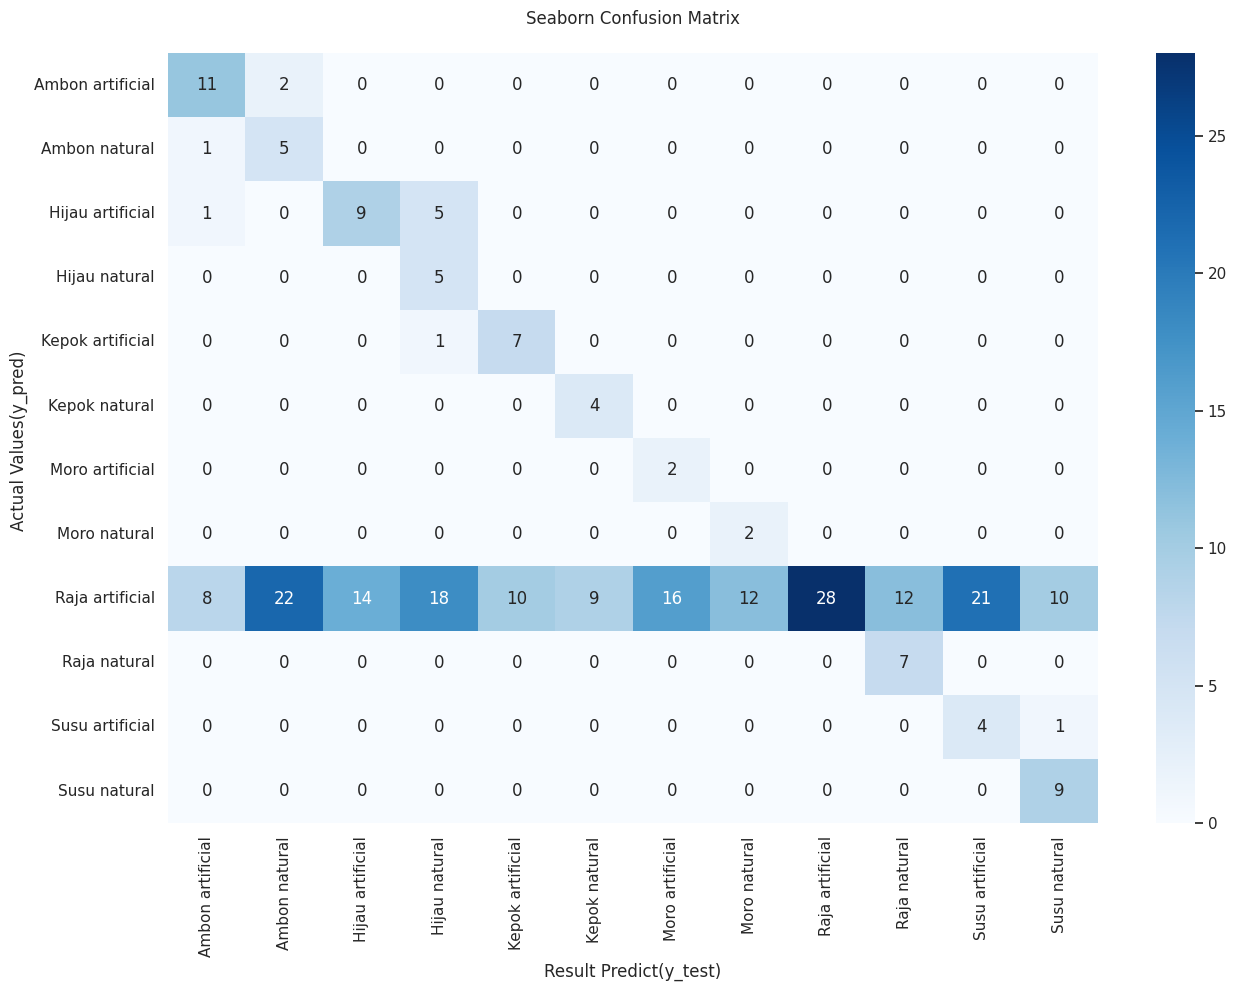

In [150]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [151]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.52      0.85      0.65        13
           1       0.17      0.83      0.29         6
           2       0.39      0.60      0.47        15
           3       0.17      1.00      0.29         5
           4       0.41      0.88      0.56         8
           5       0.31      1.00      0.47         4
           6       0.11      1.00      0.20         2
           7       0.14      1.00      0.25         2
           8       1.00      0.16      0.27       180
           9       0.37      1.00      0.54         7
          10       0.16      0.80      0.27         5
          11       0.45      1.00      0.62         9

    accuracy                           0.36       256
   macro avg       0.35      0.84      0.41       256
weighted avg       0.81      0.36      0.33       256



## Pengujian 9 - SGD 0,3

In [152]:
model_resnet = 'new_test/new-test-resnet-sgd-0,3-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-0,3-completed.h5'

### Load ResNet Model

In [153]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [154]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [155]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [156]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [157]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [158]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 18ms/step


In [159]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 89ms/step


In [160]:
ensemble_resmob = (pred1+pred2)/2.0

In [161]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [162]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 18ms/step


In [163]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [164]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 85ms/step


In [165]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [166]:
!pip install seaborn

In [167]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.7890625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

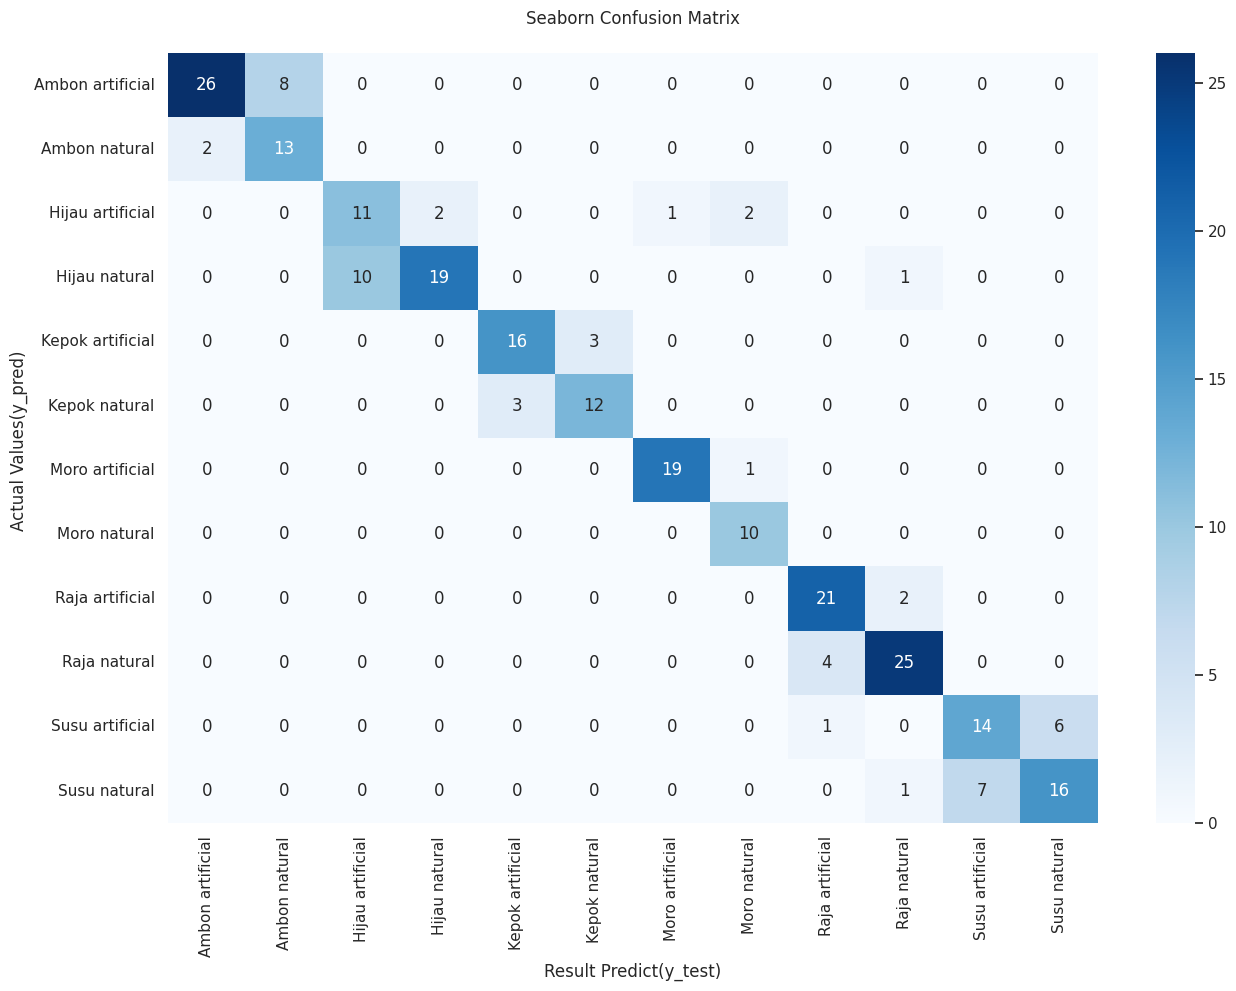

In [168]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [169]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.76      0.84        34
           1       0.62      0.87      0.72        15
           2       0.52      0.69      0.59        16
           3       0.90      0.63      0.75        30
           4       0.84      0.84      0.84        19
           5       0.80      0.80      0.80        15
           6       0.95      0.95      0.95        20
           7       0.77      1.00      0.87        10
           8       0.81      0.91      0.86        23
           9       0.86      0.86      0.86        29
          10       0.67      0.67      0.67        21
          11       0.73      0.67      0.70        24

    accuracy                           0.79       256
   macro avg       0.78      0.80      0.79       256
weighted avg       0.81      0.79      0.79       256



### MobileNet Evaluation

In [170]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.1484375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

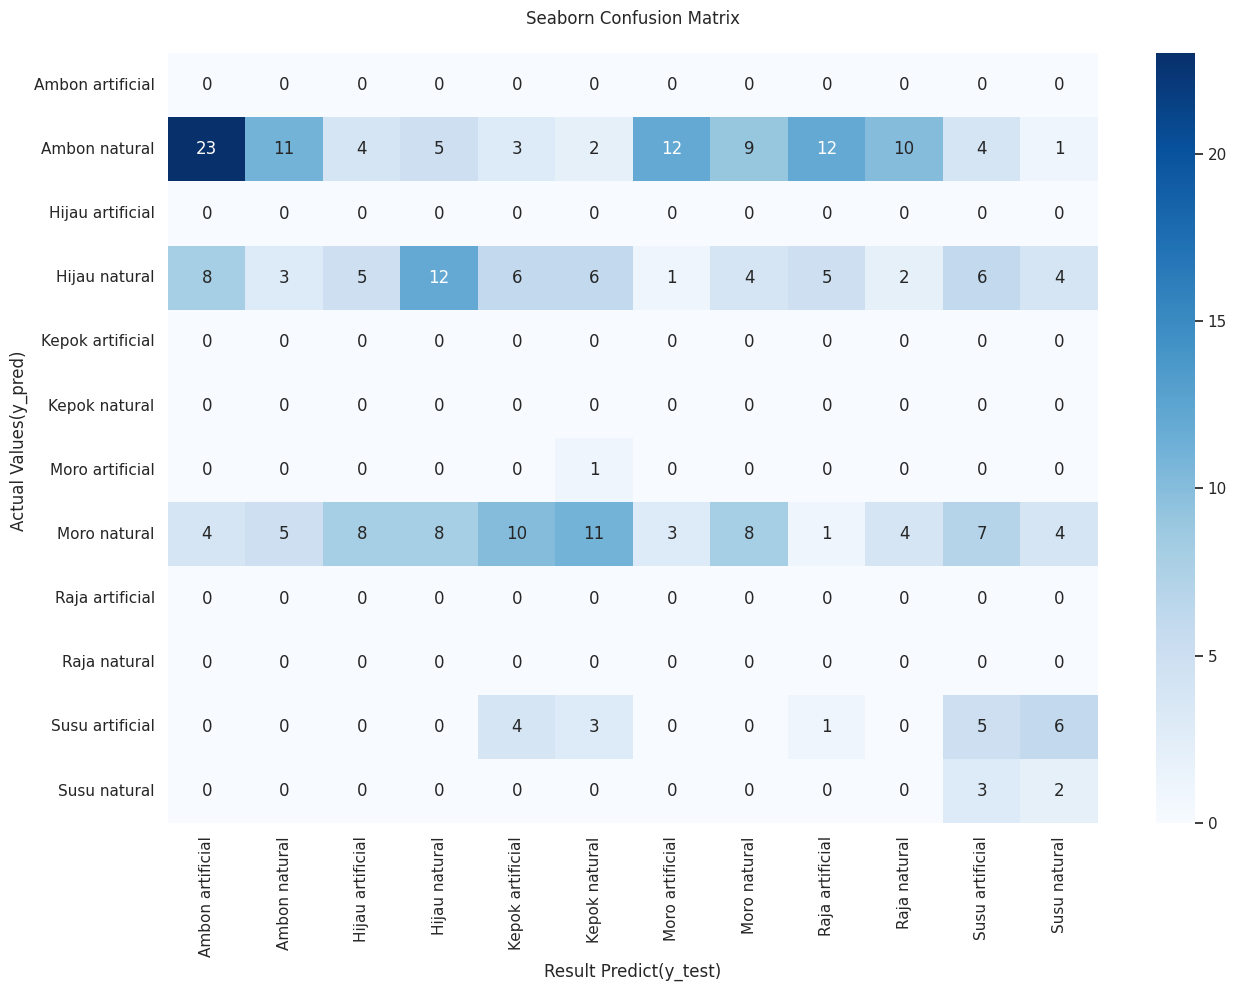

In [171]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [172]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.58      0.11      0.19        96
           2       0.00      0.00      0.00         0
           3       0.48      0.19      0.28        62
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         1
           7       0.38      0.11      0.17        73
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.20      0.26      0.23        19
          11       0.12      0.40      0.18         5

    accuracy                           0.15       256
   macro avg       0.15      0.09      0.09       256
weighted avg       0.46      0.15      0.21       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Evaluation

In [173]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.75390625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

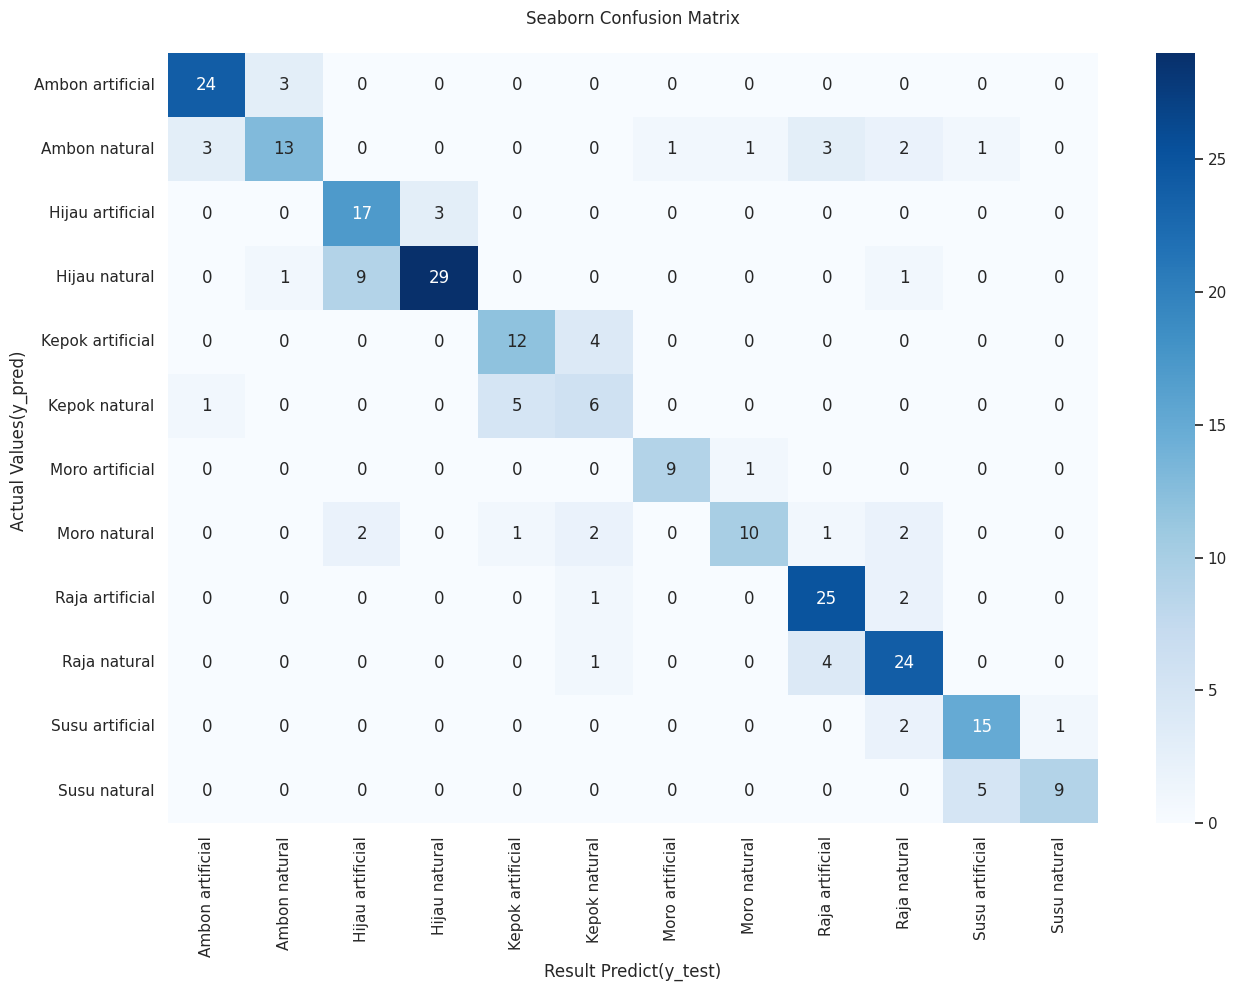

In [174]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [175]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87        27
           1       0.76      0.54      0.63        24
           2       0.61      0.85      0.71        20
           3       0.91      0.72      0.81        40
           4       0.67      0.75      0.71        16
           5       0.43      0.50      0.46        12
           6       0.90      0.90      0.90        10
           7       0.83      0.56      0.67        18
           8       0.76      0.89      0.82        28
           9       0.73      0.83      0.77        29
          10       0.71      0.83      0.77        18
          11       0.90      0.64      0.75        14

    accuracy                           0.75       256
   macro avg       0.76      0.74      0.74       256
weighted avg       0.77      0.75      0.75       256



## Pengujian 10 - SGD 0,4

In [176]:
model_resnet = 'new_test/new-test-resnet-sgd-0,4-completed.h5'
model_mobile = 'new_test/new-test-mobile-sgd-0,4-completed.h5'

### Load ResNet Model

In [177]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [178]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [179]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [180]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [181]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [182]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 19ms/step


In [183]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 89ms/step


In [184]:
ensemble_resmob = (pred1+pred2)/2.0

In [185]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [186]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 19ms/step


In [187]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [188]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 85ms/step


In [189]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [190]:
!pip install seaborn

In [191]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.7890625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

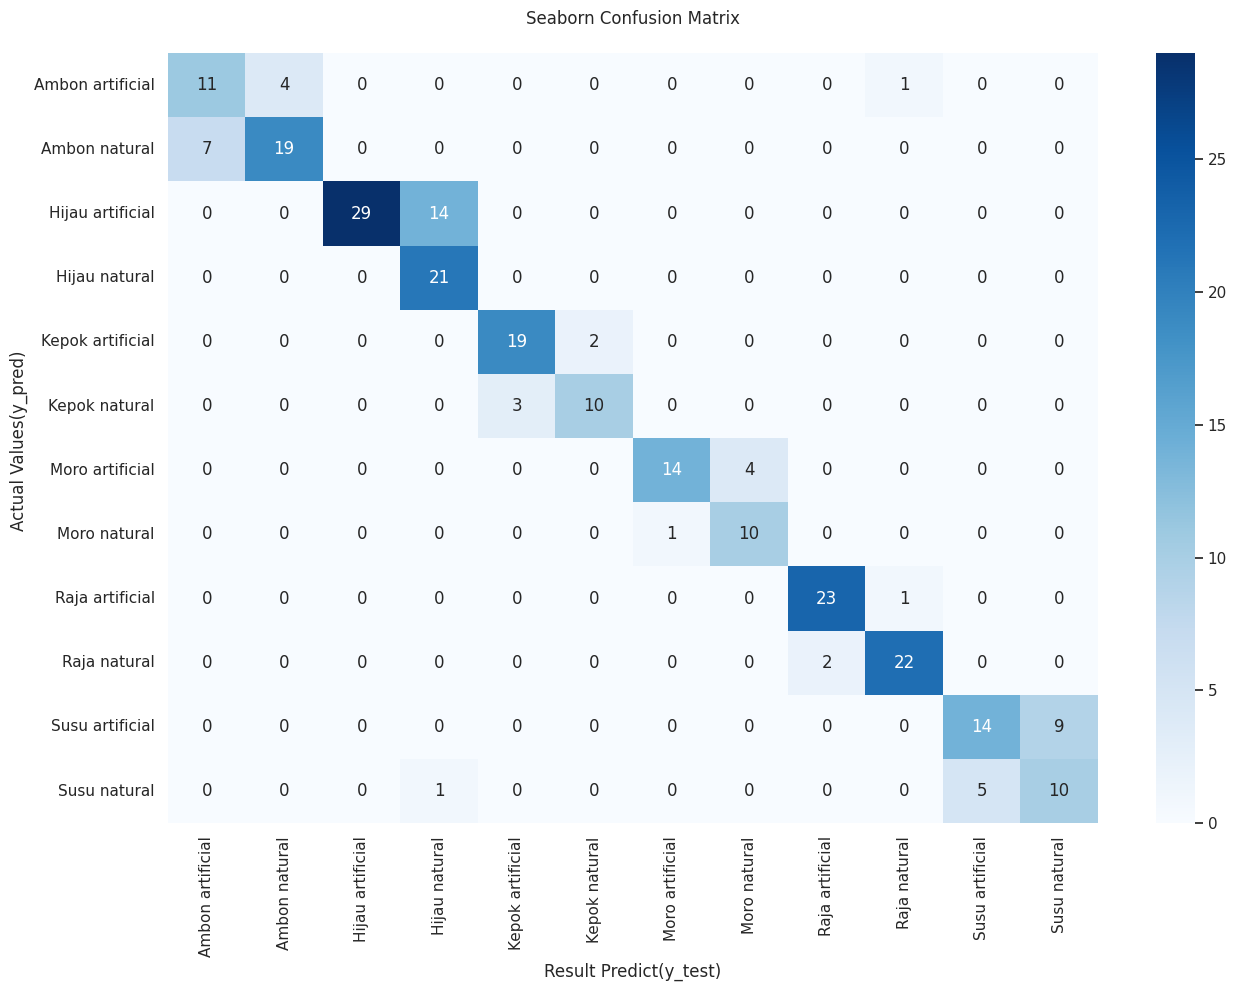

In [192]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [193]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.69      0.65        16
           1       0.83      0.73      0.78        26
           2       1.00      0.67      0.81        43
           3       0.58      1.00      0.74        21
           4       0.86      0.90      0.88        21
           5       0.83      0.77      0.80        13
           6       0.93      0.78      0.85        18
           7       0.71      0.91      0.80        11
           8       0.92      0.96      0.94        24
           9       0.92      0.92      0.92        24
          10       0.74      0.61      0.67        23
          11       0.53      0.62      0.57        16

    accuracy                           0.79       256
   macro avg       0.79      0.80      0.78       256
weighted avg       0.82      0.79      0.79       256



### MobileNet Evaluation

In [194]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.09375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

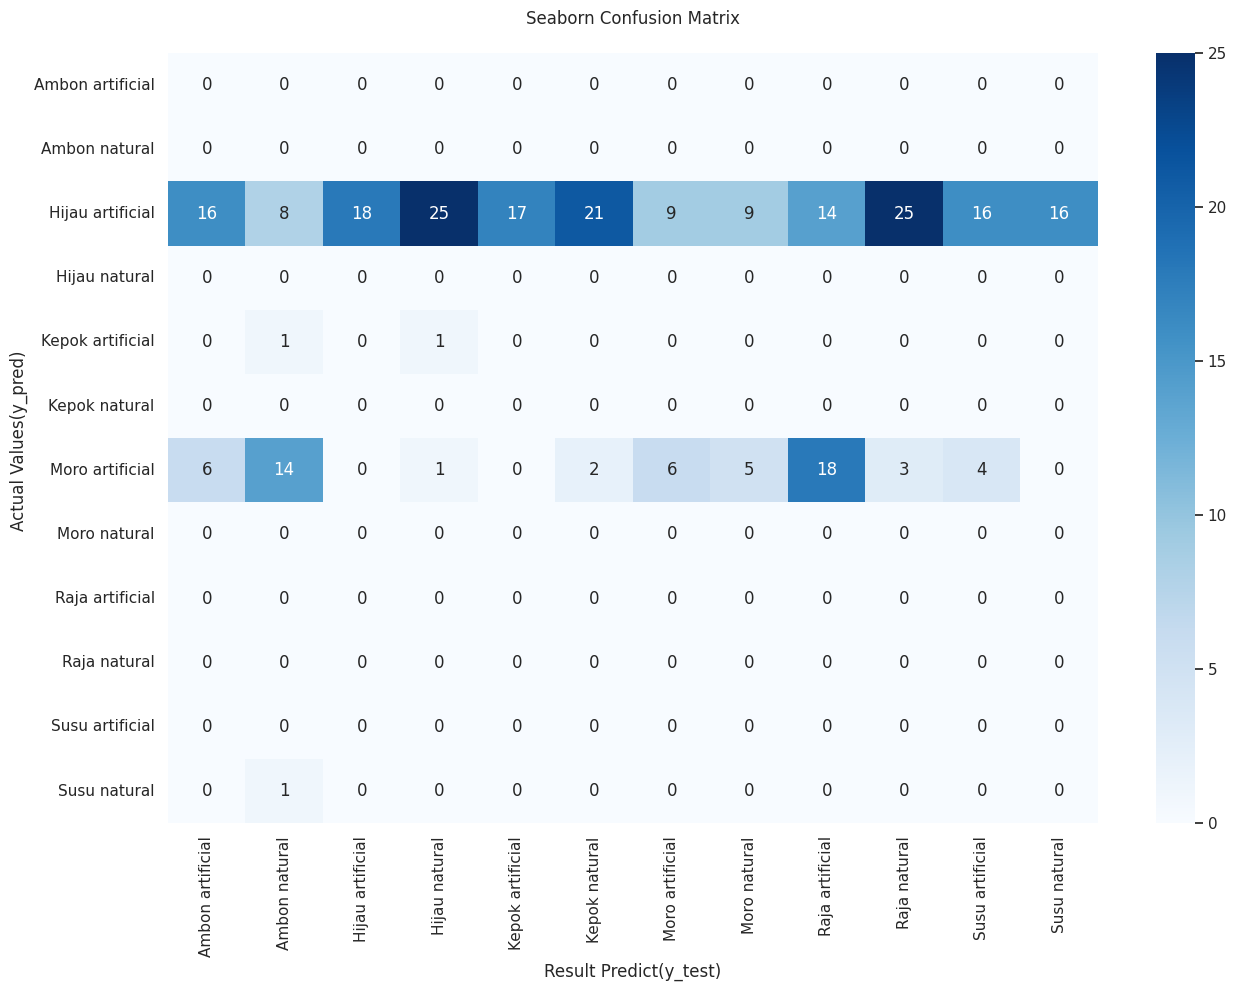

In [195]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [196]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.09      0.17       194
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         0
           6       0.40      0.10      0.16        59
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1

    accuracy                           0.09       256
   macro avg       0.12      0.02      0.03       256
weighted avg       0.85      0.09      0.17       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Evaluation

In [197]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.203125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

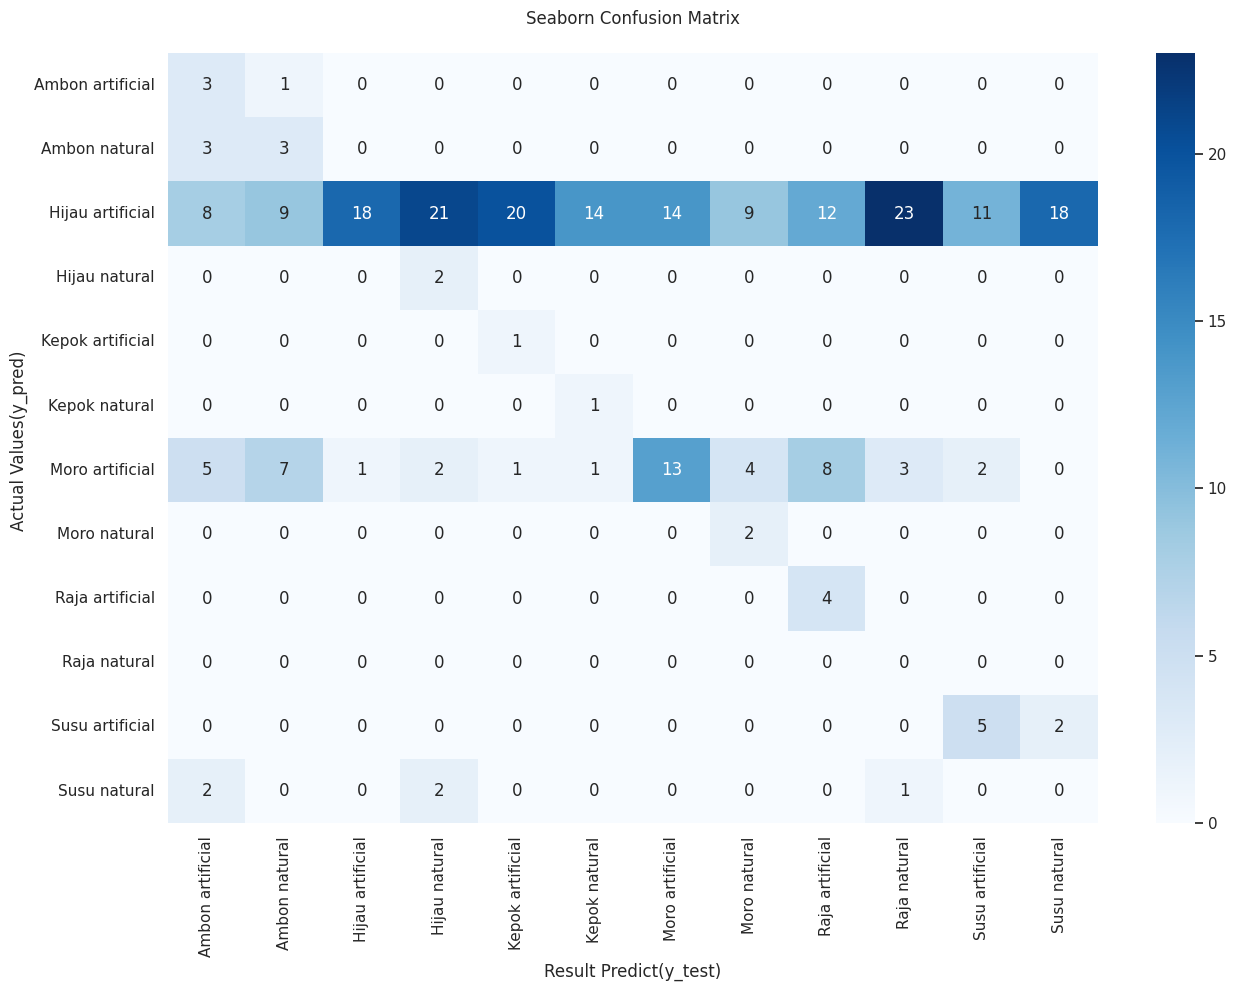

In [198]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [199]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.14      0.75      0.24         4
           1       0.15      0.50      0.23         6
           2       0.95      0.10      0.18       177
           3       0.07      1.00      0.14         2
           4       0.05      1.00      0.09         1
           5       0.06      1.00      0.12         1
           6       0.48      0.28      0.35        47
           7       0.13      1.00      0.24         2
           8       0.17      1.00      0.29         4
           9       0.00      0.00      0.00         0
          10       0.28      0.71      0.40         7
          11       0.00      0.00      0.00         5

    accuracy                           0.20       256
   macro avg       0.21      0.61      0.19       256
weighted avg       0.76      0.20      0.22       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Pengujian Learning Rate Adam

## Pengujian 11 - Adam 0,1

In [200]:
model_resnet = 'new_test/new-test-resnet-adam-0,1-completed.h5'
model_mobile = 'new_test/new-test-mobile-adam-0,1-completed.h5'

### Load ResNet Model

In [201]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [202]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [203]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [204]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [205]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [206]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 18ms/step


In [207]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 88ms/step


In [208]:
ensemble_resmob = (pred1+pred2)/2.0

In [209]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [210]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 17ms/step


In [211]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [212]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 83ms/step


In [213]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [214]:
!pip install seaborn

In [215]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.3984375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

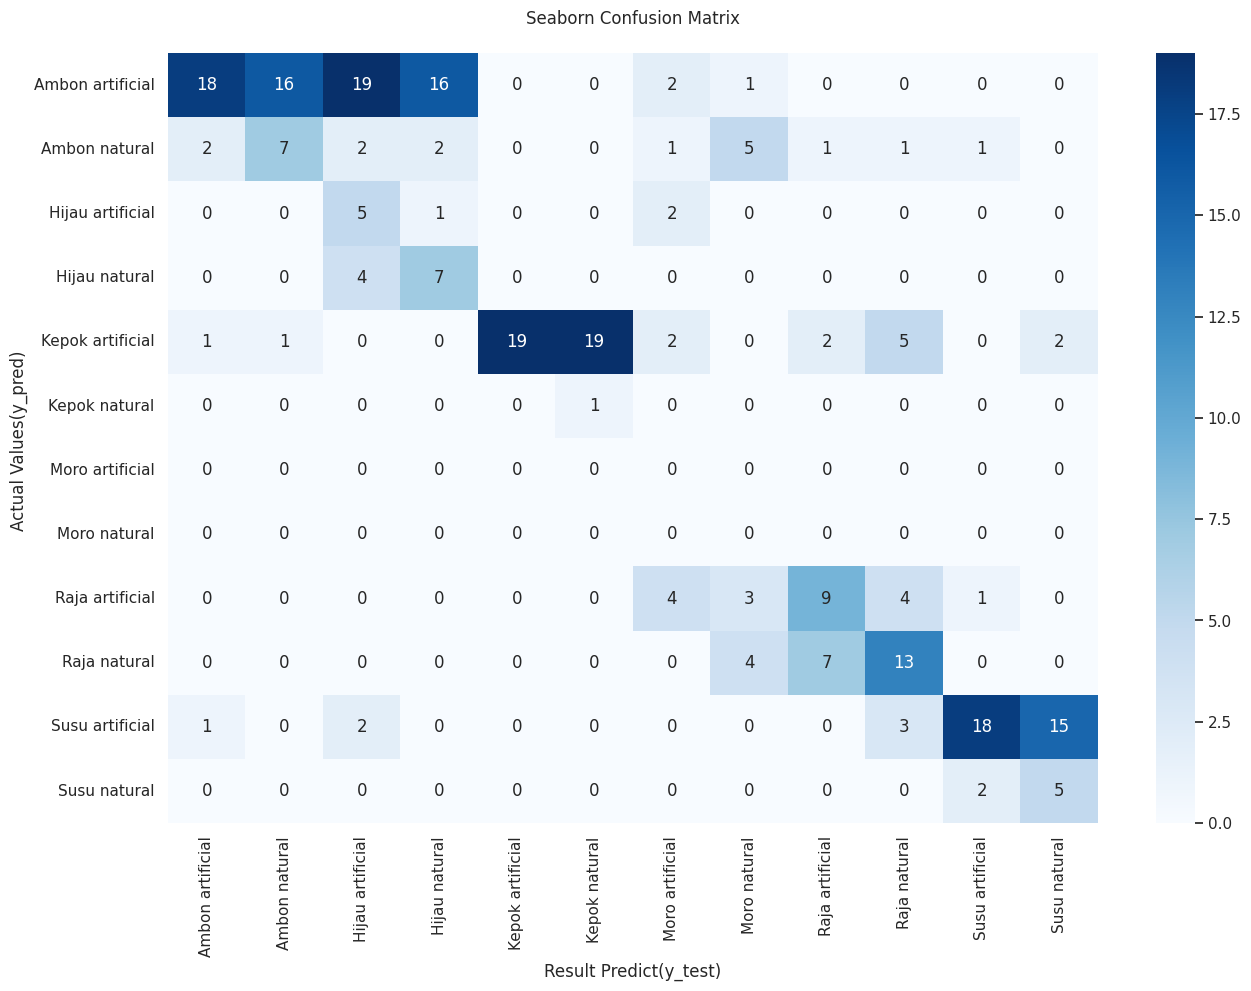

In [216]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [217]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.25      0.38        72
           1       0.29      0.32      0.30        22
           2       0.16      0.62      0.25         8
           3       0.27      0.64      0.38        11
           4       1.00      0.37      0.54        51
           5       0.05      1.00      0.10         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.47      0.43      0.45        21
           9       0.50      0.54      0.52        24
          10       0.82      0.46      0.59        39
          11       0.23      0.71      0.34         7

    accuracy                           0.40       256
   macro avg       0.38      0.45      0.32       256
weighted avg       0.69      0.40      0.45       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### MobileNet Evaluation

In [218]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.08203125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

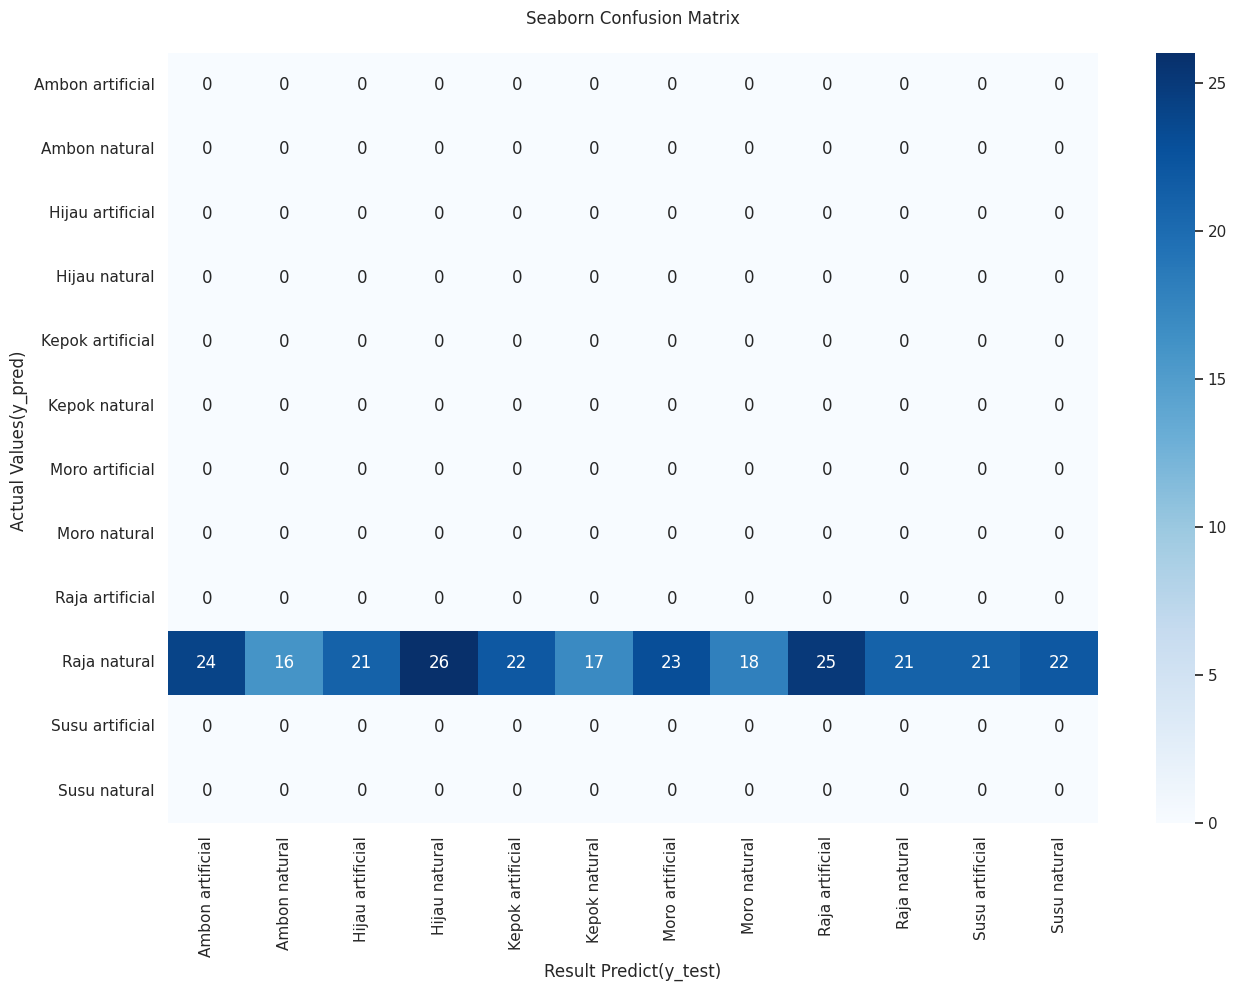

In [219]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [220]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.08      0.15       256
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0

    accuracy                           0.08       256
   macro avg       0.08      0.01      0.01       256
weighted avg       1.00      0.08      0.15       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Evaluation

In [221]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.19140625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

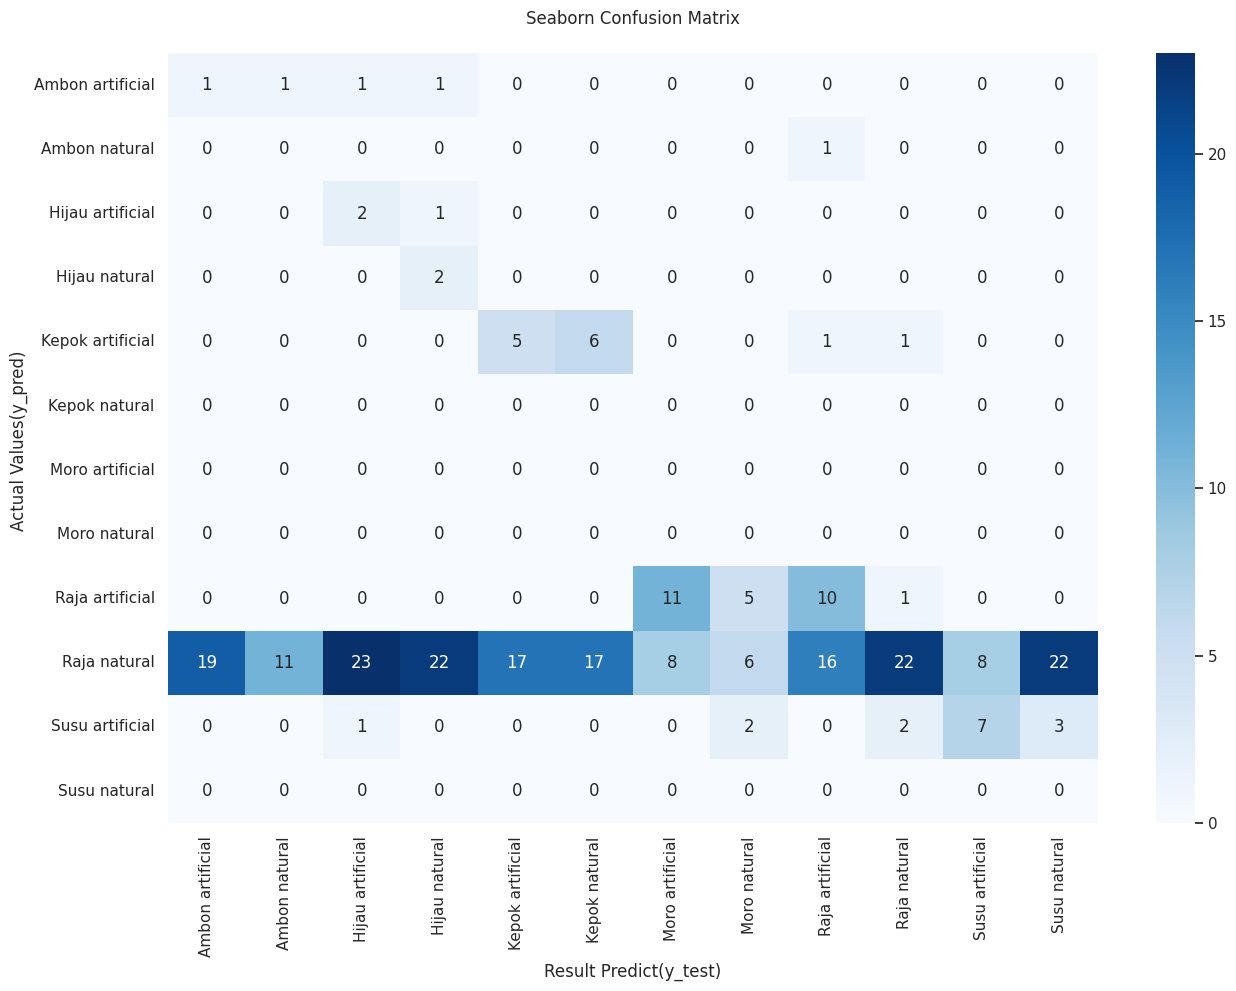

In [222]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [223]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.05      0.25      0.08         4
           1       0.00      0.00      0.00         1
           2       0.07      0.67      0.13         3
           3       0.08      1.00      0.14         2
           4       0.23      0.38      0.29        13
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.36      0.37      0.36        27
           9       0.85      0.12      0.20       191
          10       0.47      0.47      0.47        15
          11       0.00      0.00      0.00         0

    accuracy                           0.19       256
   macro avg       0.17      0.27      0.14       256
weighted avg       0.71      0.19      0.24       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Pengujian 12 - Adam 0,2

In [224]:
model_resnet = 'new_test/new-test-resnet-adam-0,2-completed.h5'
model_mobile = 'new_test/new-test-mobile-adam-0,2-completed.h5'

### Load ResNet Model

In [225]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [226]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [227]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [228]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [229]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  49  y:  49


### Testing Ensemble Averaging

In [230]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 19ms/step


In [231]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 89ms/step


In [232]:
ensemble_resmob = (pred1+pred2)/2.0

In [233]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [234]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 19ms/step


In [235]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [236]:
predResnet = modelRes.predict(x2)

2/2 [==============================] - 2s 105ms/step


In [237]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [238]:
!pip install seaborn

In [239]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.5510204081632653


Text(153.75, 0.5, 'Actual Values(y_pred) ')

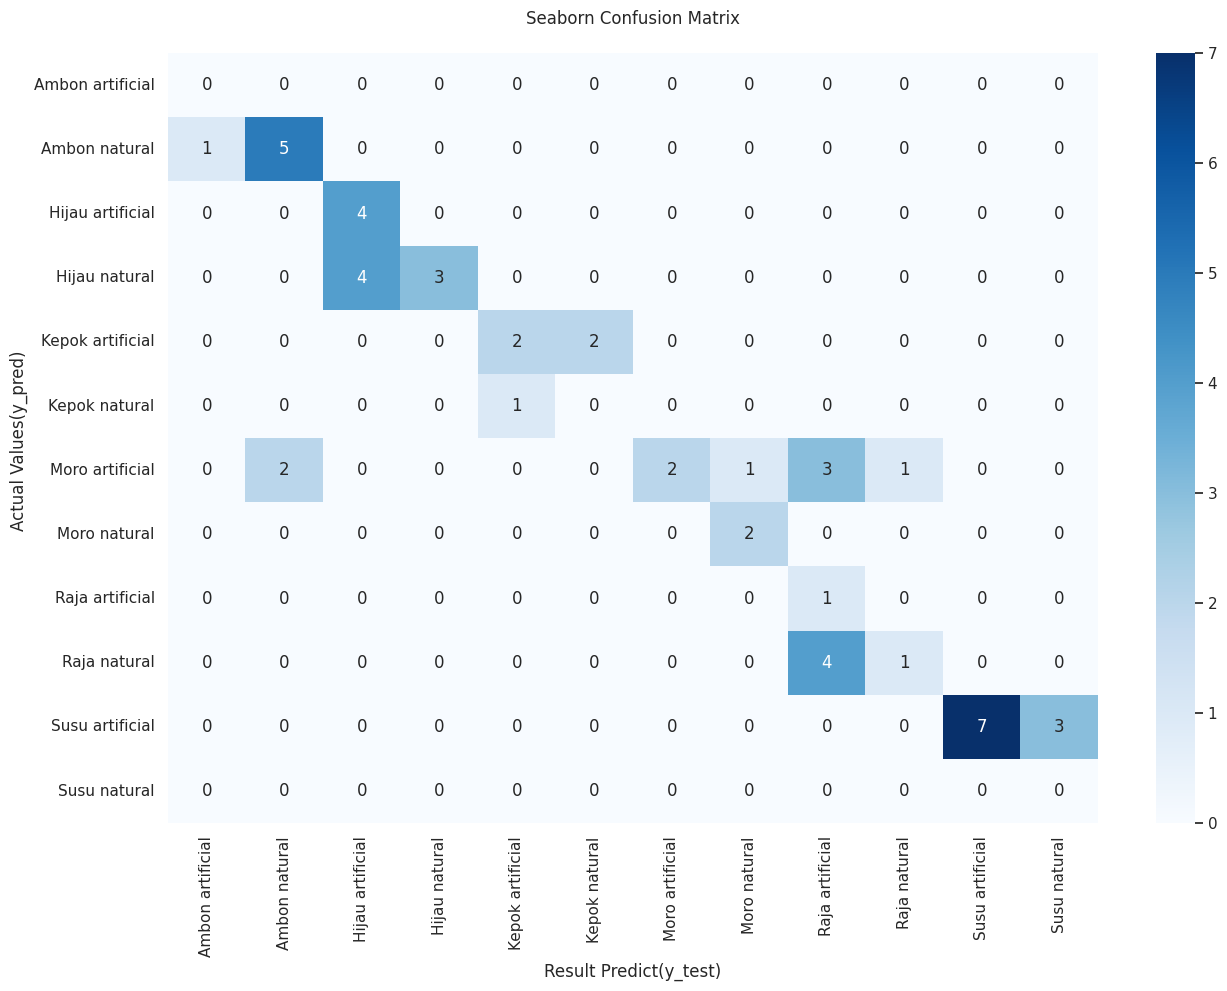

In [240]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [241]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.71      0.83      0.77         6
           2       0.50      1.00      0.67         4
           3       1.00      0.43      0.60         7
           4       0.67      0.50      0.57         4
           5       0.00      0.00      0.00         1
           6       1.00      0.22      0.36         9
           7       0.67      1.00      0.80         2
           8       0.12      1.00      0.22         1
           9       0.50      0.20      0.29         5
          10       1.00      0.70      0.82        10
          11       0.00      0.00      0.00         0

    accuracy                           0.55        49
   macro avg       0.51      0.49      0.43        49
weighted avg       0.79      0.55      0.58        49



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### MobileNet Evaluation

In [242]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.05859375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

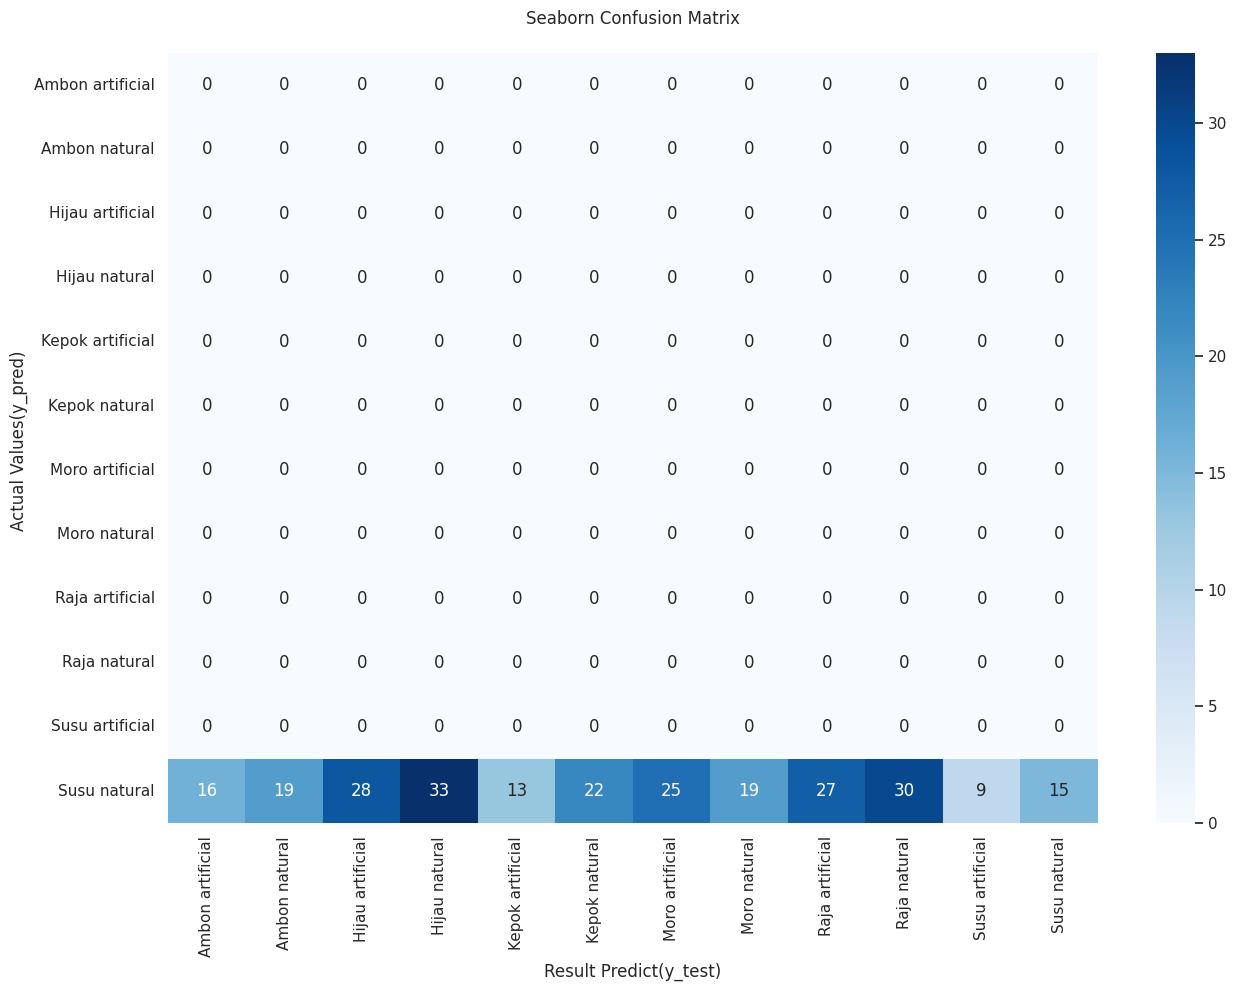

In [243]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [244]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       1.00      0.06      0.11       256

    accuracy                           0.06       256
   macro avg       0.08      0.00      0.01       256
weighted avg       1.00      0.06      0.11       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Evaluation

In [245]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.2734375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

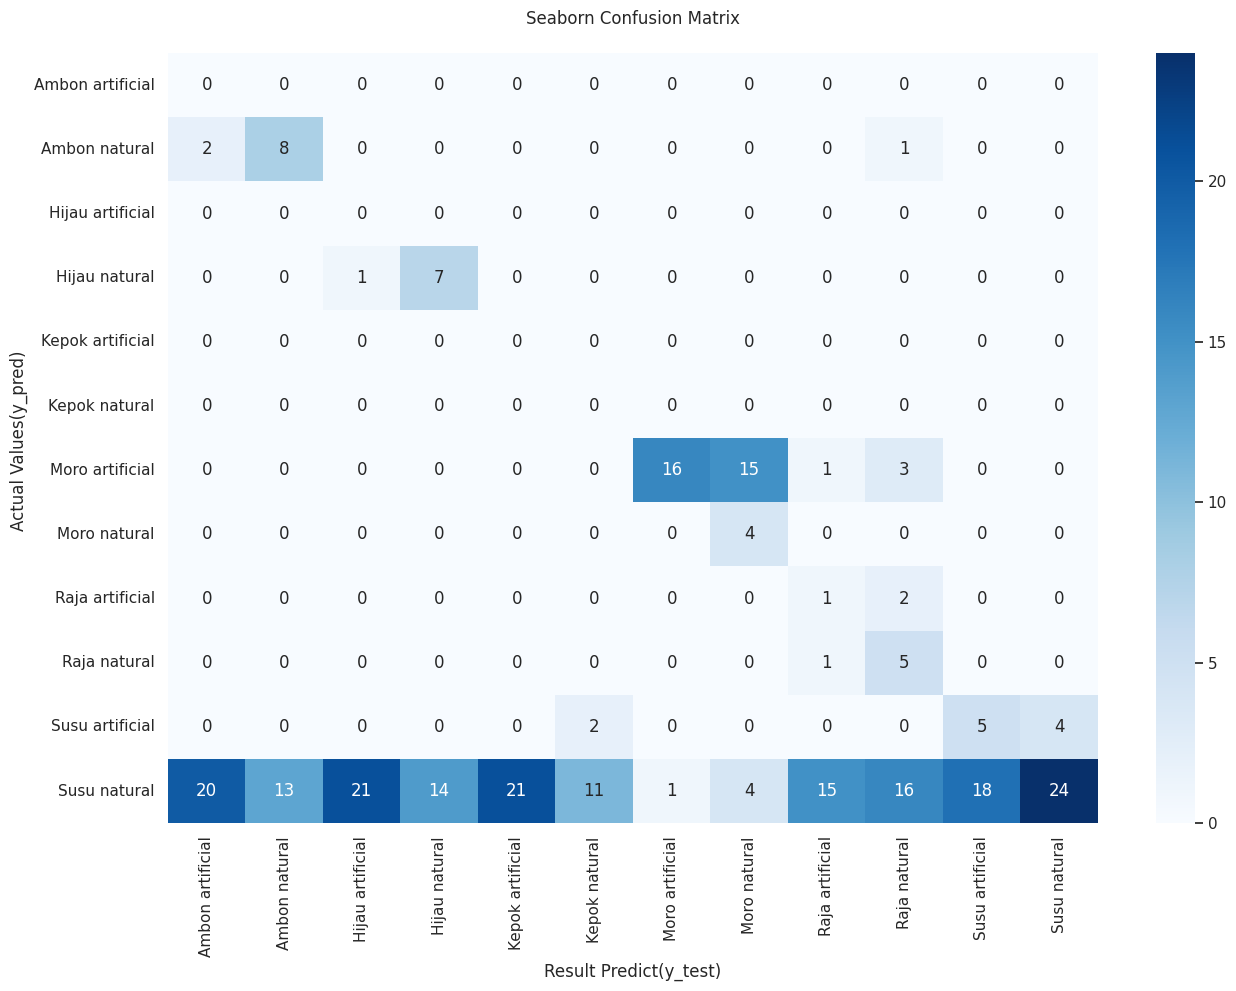

In [246]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [247]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.38      0.73      0.50        11
           2       0.00      0.00      0.00         0
           3       0.33      0.88      0.48         8
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.94      0.46      0.62        35
           7       0.17      1.00      0.30         4
           8       0.06      0.33      0.10         3
           9       0.19      0.83      0.30         6
          10       0.22      0.45      0.29        11
          11       0.86      0.13      0.23       178

    accuracy                           0.27       256
   macro avg       0.26      0.40      0.23       256
weighted avg       0.77      0.27      0.31       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Pengujian 13 - Adam 0,3

In [248]:
model_resnet = 'new_test/new-test-resnet-adam-0,3-completed.h5'
model_mobile = 'new_test/new-test-mobile-adam-0,3-completed.h5'

### Load ResNet Model

In [249]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [250]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [251]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [252]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [253]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [254]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 19ms/step


In [255]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 89ms/step


In [256]:
ensemble_resmob = (pred1+pred2)/2.0

In [257]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [258]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 18ms/step


In [259]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [260]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 86ms/step


In [261]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [262]:
!pip install seaborn

In [263]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.3515625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

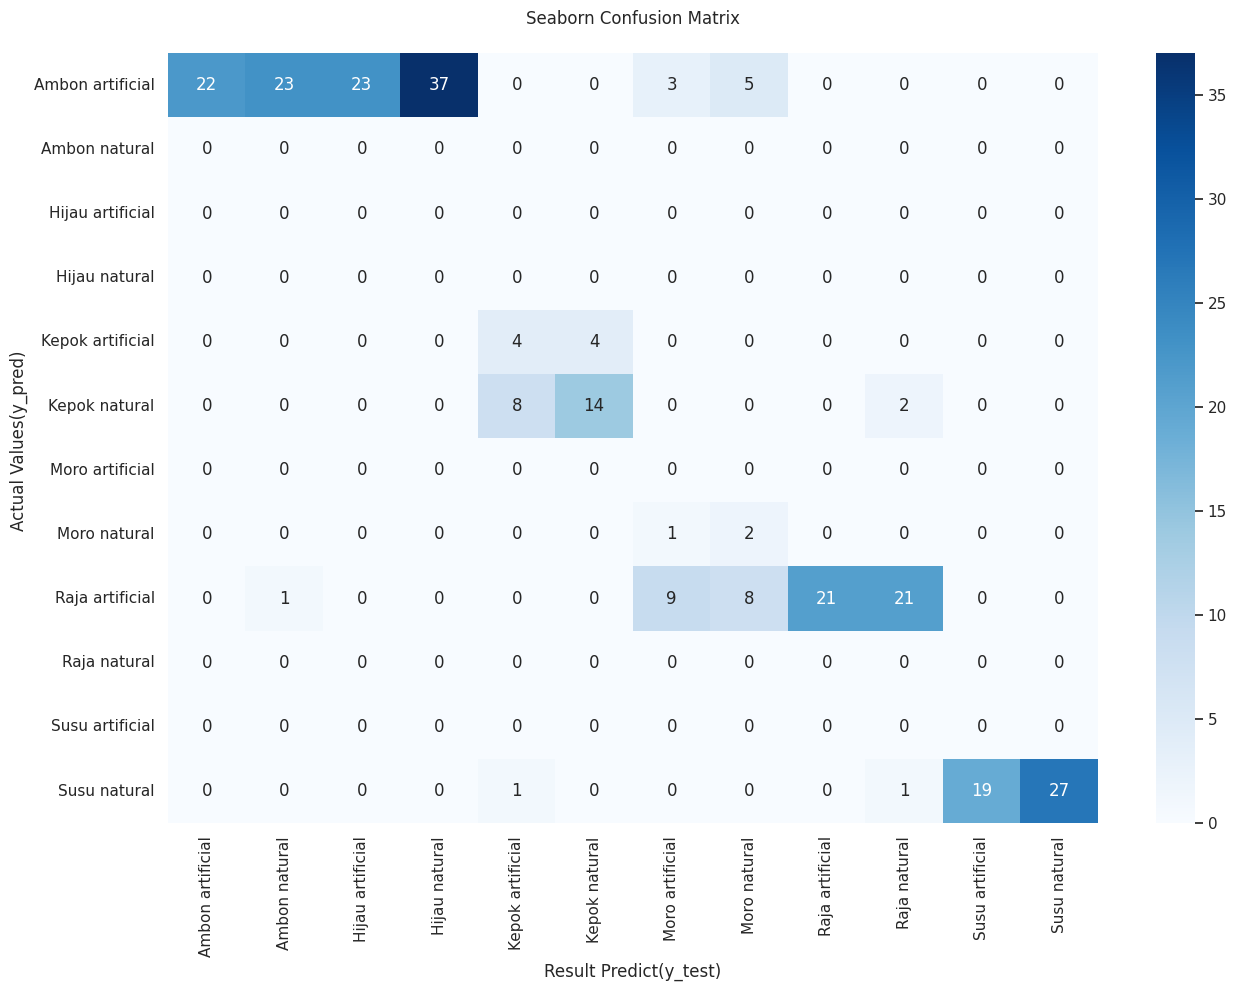

In [264]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [265]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.19      0.33       113
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.31      0.50      0.38         8
           5       0.78      0.58      0.67        24
           6       0.00      0.00      0.00         0
           7       0.13      0.67      0.22         3
           8       1.00      0.35      0.52        60
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       1.00      0.56      0.72        48

    accuracy                           0.35       256
   macro avg       0.35      0.24      0.24       256
weighted avg       0.95      0.35      0.48       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### MobileNet Evaluation

In [266]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.0703125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

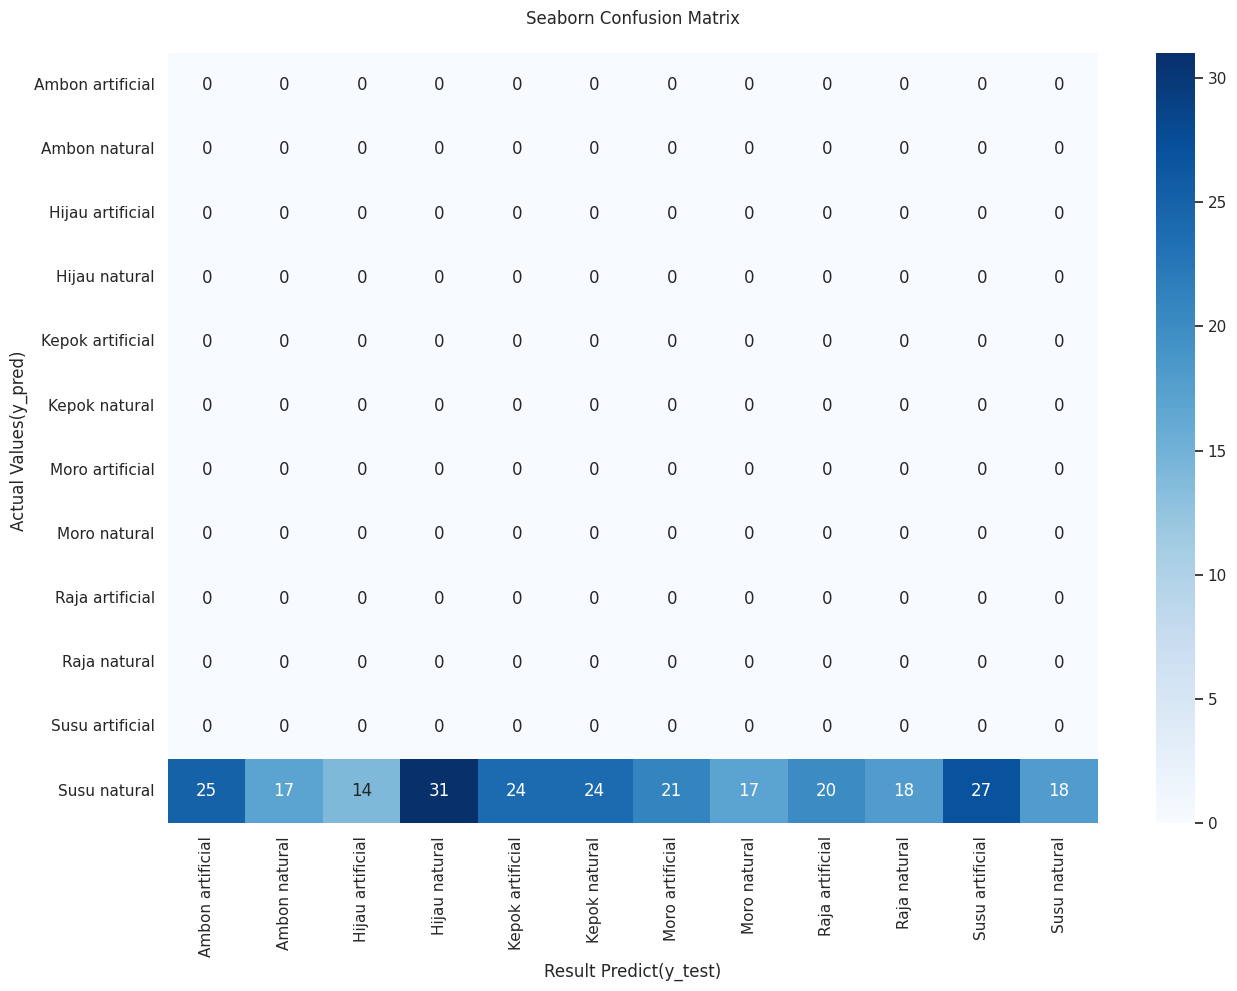

In [267]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [268]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       1.00      0.07      0.13       256

    accuracy                           0.07       256
   macro avg       0.08      0.01      0.01       256
weighted avg       1.00      0.07      0.13       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Evaluation

In [269]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.2421875


Text(153.75, 0.5, 'Actual Values(y_pred) ')

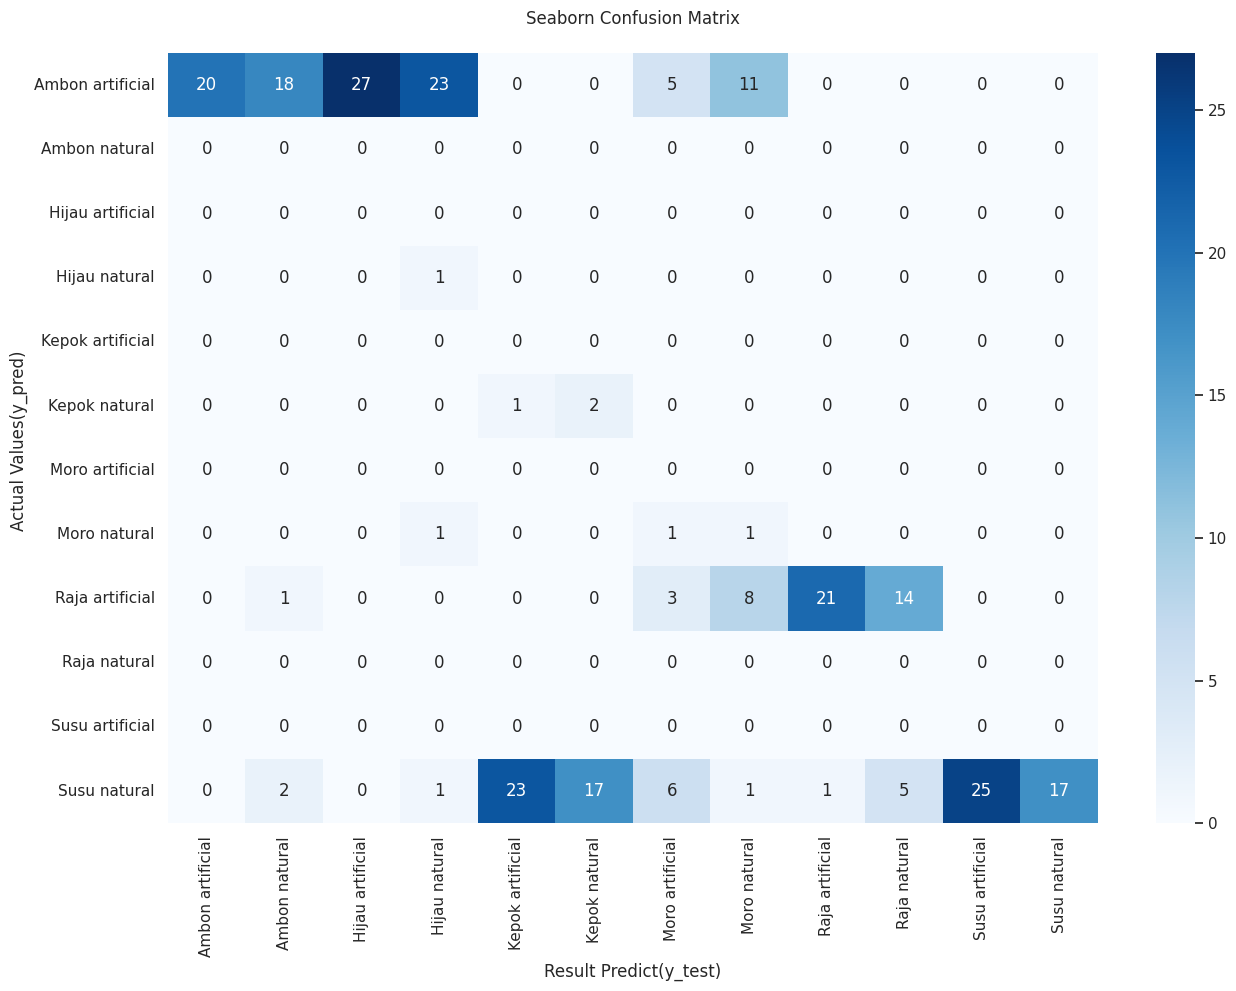

In [270]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [271]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.19      0.32       104
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.04      1.00      0.07         1
           4       0.00      0.00      0.00         0
           5       0.11      0.67      0.18         3
           6       0.00      0.00      0.00         0
           7       0.05      0.33      0.08         3
           8       0.95      0.45      0.61        47
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       1.00      0.17      0.30        98

    accuracy                           0.24       256
   macro avg       0.26      0.23      0.13       256
weighted avg       0.97      0.24      0.36       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Pengujian 14 - Adam 0,4

In [272]:
model_resnet = 'new_test/new-test-resnet-adam-0,4-completed.h5'
model_mobile = 'new_test/new-test-mobile-adam-0,4-completed.h5'

### Load ResNet Model

In [273]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

### Load MobileNet Model

In [274]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [275]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [276]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [277]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [278]:
pred1 = modelMob.predict(x)

8/8 [==============================] - 1s 17ms/step


In [279]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 89ms/step


In [280]:
ensemble_resmob = (pred1+pred2)/2.0

In [281]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

#### Testing MobileNet

In [282]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 19ms/step


In [283]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [284]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 83ms/step


In [285]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [286]:
!pip install seaborn

In [287]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.08203125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

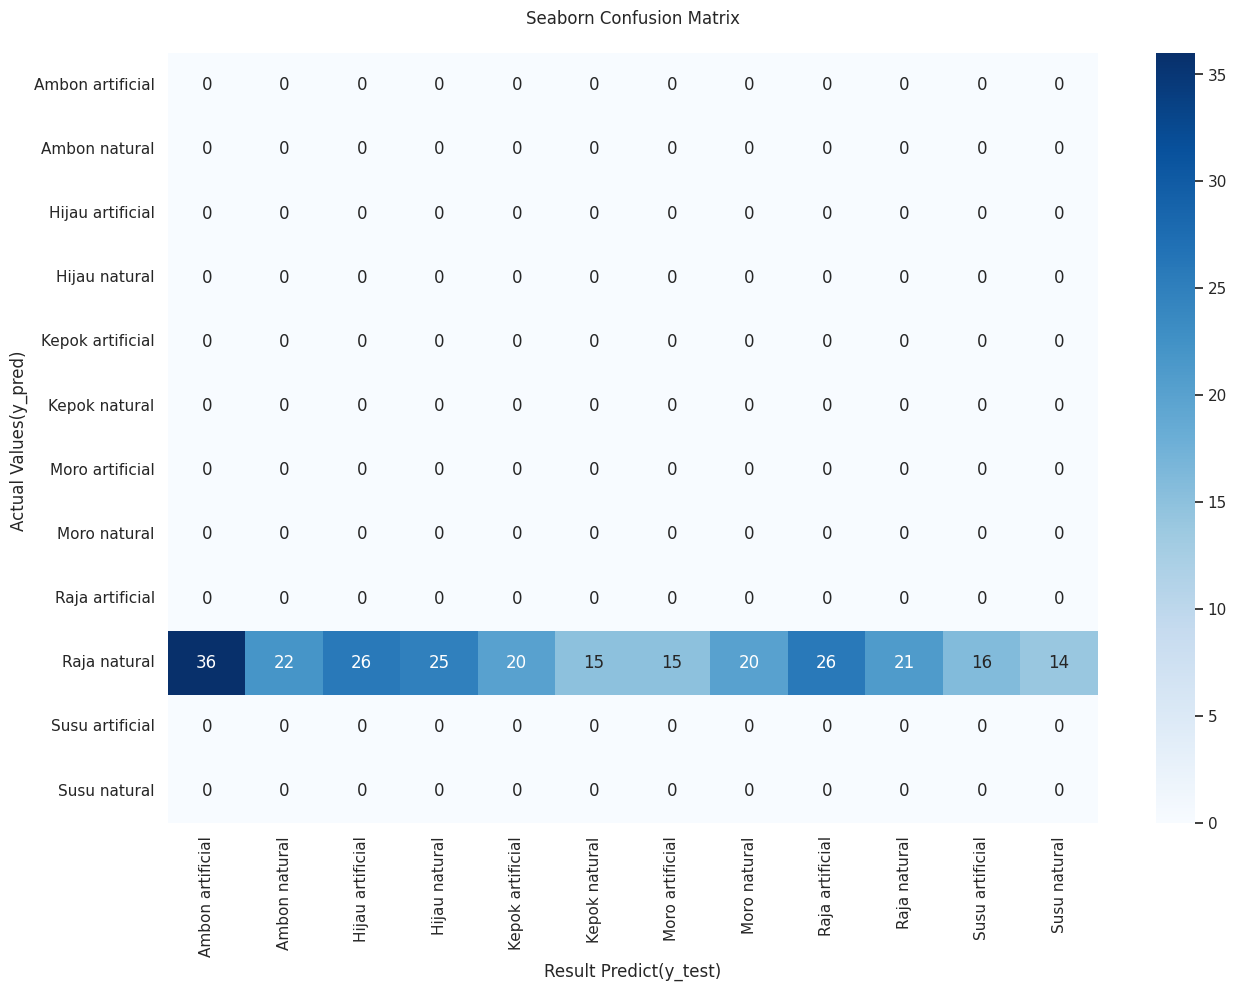

In [288]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [289]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.08      0.15       256
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0

    accuracy                           0.08       256
   macro avg       0.08      0.01      0.01       256
weighted avg       1.00      0.08      0.15       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### MobileNet Evaluation

In [290]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.0859375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

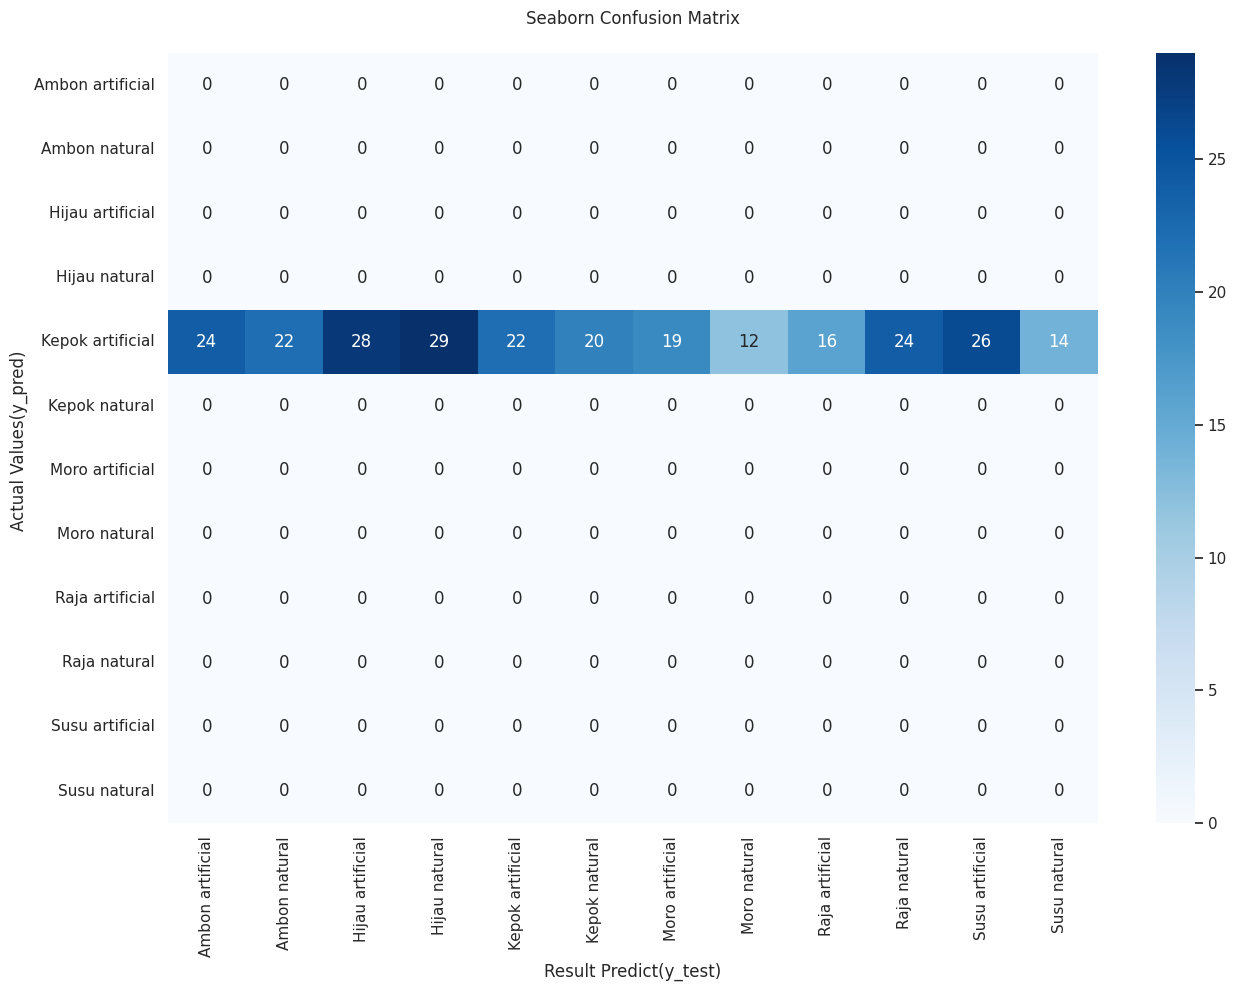

In [291]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [292]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.09      0.16       256
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0

    accuracy                           0.09       256
   macro avg       0.08      0.01      0.01       256
weighted avg       1.00      0.09      0.16       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Evaluation

In [293]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.07421875


Text(153.75, 0.5, 'Actual Values(y_pred) ')

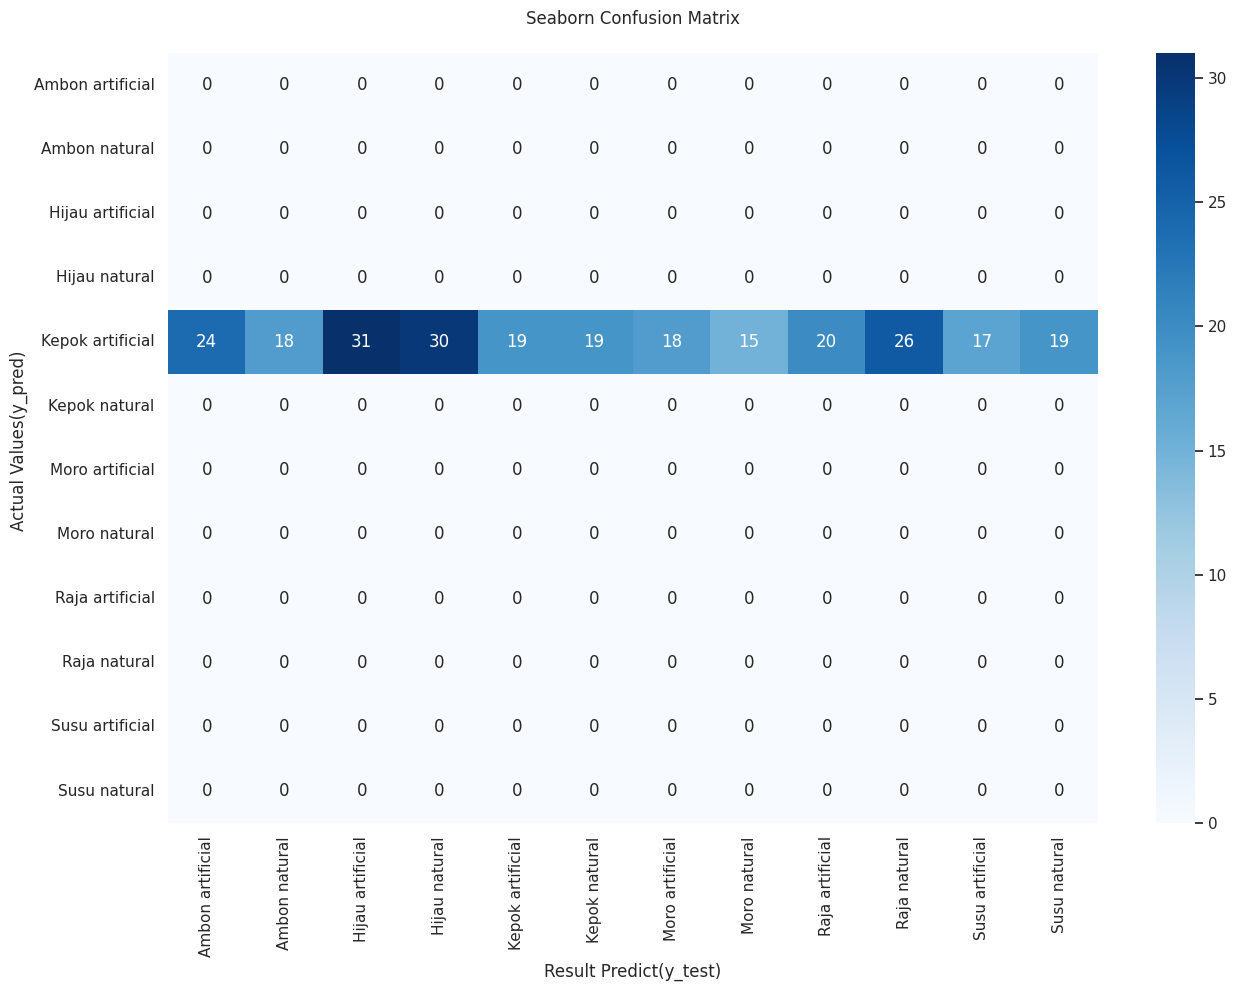

In [294]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [295]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.07      0.14       256
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0

    accuracy                           0.07       256
   macro avg       0.08      0.01      0.01       256
weighted avg       1.00      0.07      0.14       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# nyoba

In [8]:
model_resnet = 'new_test/new-test-resnet-adam-0,4-completed.h5'
model_mobile = 'new_test/new-test-mobile-adam-0,4-completed.h5'

### Load ResNet Model

In [9]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

2023-12-27 20:29:14.969538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21332 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:af:00.0, compute capability: 7.5


### Load MobileNet Model

In [10]:
modelMob = keras.models.load_model(model_mobile)

### Set Test Data Generator

In [11]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [12]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [13]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


### Testing Ensemble Averaging

In [14]:
pred1 = modelMob.predict(x)

2023-12-27 20:29:57.746682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-27 20:30:09.526969: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-27 20:30:13.159708: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


8/8 [==============================] - 35s 31ms/step


In [15]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 11s 252ms/step


In [16]:
ensemble_resmob = (pred1+pred2)/2.0

In [17]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

In [18]:
print(pred1)

[[4.89217322e-03 8.78343917e-03 9.83496383e-02 ... 2.99201747e-05
  3.72787695e-12 5.61896536e-12]
 [4.92587080e-03 8.83630849e-03 9.93586332e-02 ... 2.94418187e-05
  3.54585285e-12 5.35225553e-12]
 [4.94021783e-03 8.85879807e-03 9.97895375e-02 ... 2.92409313e-05
  3.47126212e-12 5.24285389e-12]
 ...
 [5.13037248e-03 9.15573072e-03 1.05575055e-01 ... 2.67234445e-05
  2.62665736e-12 3.99889974e-12]
 [4.84325085e-03 8.70655943e-03 9.68923643e-02 ... 3.06310030e-05
  4.01023702e-12 6.03195185e-12]
 [5.04125701e-03 9.01684072e-03 1.02846436e-01 ... 2.78704956e-05
  2.99128907e-12 4.53717099e-12]]


In [19]:
print(pred2)

[[1.14153464e-10 1.08904041e-09 5.48218787e-01 ... 1.25919938e-25
  0.00000000e+00 0.00000000e+00]
 [5.28929697e-04 1.15787564e-03 2.02378061e-08 ... 2.76313692e-01
  2.42566034e-01 3.33133340e-01]
 [2.34874012e-03 1.04094977e-02 5.12055695e-01 ... 4.16164081e-09
  3.21094267e-18 1.26955939e-18]
 ...
 [3.05085592e-08 2.27556384e-07 6.43645048e-01 ... 3.03582652e-20
  4.85556617e-36 7.65897814e-37]
 [1.02006516e-03 4.72439546e-03 5.87289751e-01 ... 5.34961520e-10
  1.12290608e-19 4.10776244e-20]
 [6.07245788e-03 1.42044323e-02 1.00269767e-06 ... 5.07253587e-01
  6.27160892e-02 7.66186193e-02]]


In [20]:
print(ensemble_resmob)

[[2.44608661e-03 4.39172005e-03 3.23284209e-01 ... 1.49600874e-05
  1.86393847e-12 2.80948268e-12]
 [2.72740028e-03 4.99709230e-03 4.96793278e-02 ... 1.38171569e-01
  1.21283017e-01 1.66566670e-01]
 [3.64447897e-03 9.63414833e-03 3.05922627e-01 ... 1.46225466e-05
  1.73563269e-12 2.62142760e-12]
 ...
 [2.56520160e-03 4.57797898e-03 3.74610066e-01 ... 1.33617223e-05
  1.31332868e-12 1.99944987e-12]
 [2.93165795e-03 6.71547744e-03 3.42091054e-01 ... 1.53157689e-05
  2.00511851e-12 3.01597592e-12]
 [5.55685721e-03 1.16106365e-02 5.14237210e-02 ... 2.53640741e-01
  3.13580446e-02 3.83093096e-02]]


In [22]:
y_res = []
for i in pred2:
    y_res.append(np.argmax(i))
print(y_res)

[2, 11, 2, 9, 2, 2, 2, 2, 9, 1, 2, 4, 1, 9, 9, 1, 7, 7, 2, 9, 2, 2, 1, 2, 1, 1, 9, 7, 2, 1, 2, 2, 2, 2, 9, 7, 2, 9, 2, 2, 2, 2, 2, 1, 2, 11, 7, 7, 2, 2, 2, 1, 9, 2, 9, 2, 4, 5, 2, 1, 2, 9, 1, 2, 9, 5, 9, 1, 2, 1, 2, 4, 7, 1, 2, 7, 2, 4, 1, 1, 2, 9, 1, 2, 2, 1, 7, 2, 7, 7, 2, 2, 1, 1, 4, 3, 2, 7, 7, 1, 7, 2, 9, 4, 2, 7, 1, 2, 1, 2, 7, 11, 1, 7, 9, 1, 11, 2, 9, 2, 3, 7, 1, 1, 2, 7, 9, 9, 1, 7, 7, 9, 2, 1, 2, 7, 7, 1, 9, 9, 1, 7, 7, 9, 1, 1, 1, 2, 2, 7, 1, 2, 7, 1, 8, 1, 1, 7, 2, 1, 7, 8, 2, 7, 2, 9, 11, 2, 2, 2, 1, 2, 2, 1, 2, 7, 1, 1, 7, 2, 2, 1, 7, 1, 1, 11, 7, 9, 2, 2, 1, 1, 2, 9, 2, 2, 9, 9, 1, 2, 9, 9, 7, 9, 2, 2, 7, 9, 1, 7, 4, 1, 2, 1, 9, 2, 9, 7, 4, 7, 1, 9, 7, 1, 7, 2, 2, 9, 11, 2, 2, 1, 1, 2, 2, 1, 7, 7, 2, 1, 7, 1, 1, 2, 1, 1, 9, 1, 2, 7, 4, 2, 2, 2, 2, 9]


In [23]:
y_mob = []
for i in pred1:
    y_mob.append(np.argmax(i))
print(y_mob)

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


In [21]:
print(y_test)

[2, 6, 6, 6, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 2, 6, 2, 2, 6, 2, 6, 6, 6, 7, 2, 6, 2, 2, 2, 2, 6, 7, 2, 6, 6, 2, 6, 2, 6, 6, 6, 6, 7, 7, 2, 2, 2, 6, 6, 2, 6, 2, 6, 6, 2, 6, 2, 6, 6, 2, 6, 6, 6, 6, 2, 6, 2, 6, 7, 6, 2, 7, 2, 6, 6, 6, 2, 6, 6, 2, 2, 6, 6, 2, 7, 7, 2, 6, 6, 6, 6, 2, 2, 7, 7, 6, 7, 2, 6, 6, 2, 7, 6, 6, 6, 2, 7, 6, 6, 7, 6, 6, 6, 2, 6, 2, 2, 7, 6, 6, 6, 7, 6, 6, 6, 7, 7, 6, 2, 7, 6, 7, 7, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 2, 6, 7, 7, 2, 7, 6, 6, 7, 6, 7, 2, 6, 7, 6, 2, 7, 2, 6, 6, 2, 6, 2, 6, 6, 2, 6, 2, 7, 6, 7, 7, 2, 2, 6, 7, 6, 6, 6, 7, 6, 2, 2, 6, 6, 2, 6, 6, 6, 6, 6, 6, 2, 6, 6, 7, 6, 2, 6, 7, 6, 6, 7, 6, 6, 2, 6, 6, 2, 6, 7, 6, 7, 6, 6, 7, 6, 7, 2, 2, 6, 6, 2, 2, 6, 6, 2, 2, 6, 7, 7, 2, 6, 7, 6, 6, 2, 6, 6, 6, 6, 6, 7, 6, 2, 2, 2, 2, 6]


#### Testing MobileNet

In [24]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 23ms/step


In [25]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

#### Testing ResNet

In [26]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 2s 255ms/step


In [27]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

### ResNet Evaluation

In [28]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.18359375


Text(153.75, 0.5, 'Actual Values(y_pred) ')

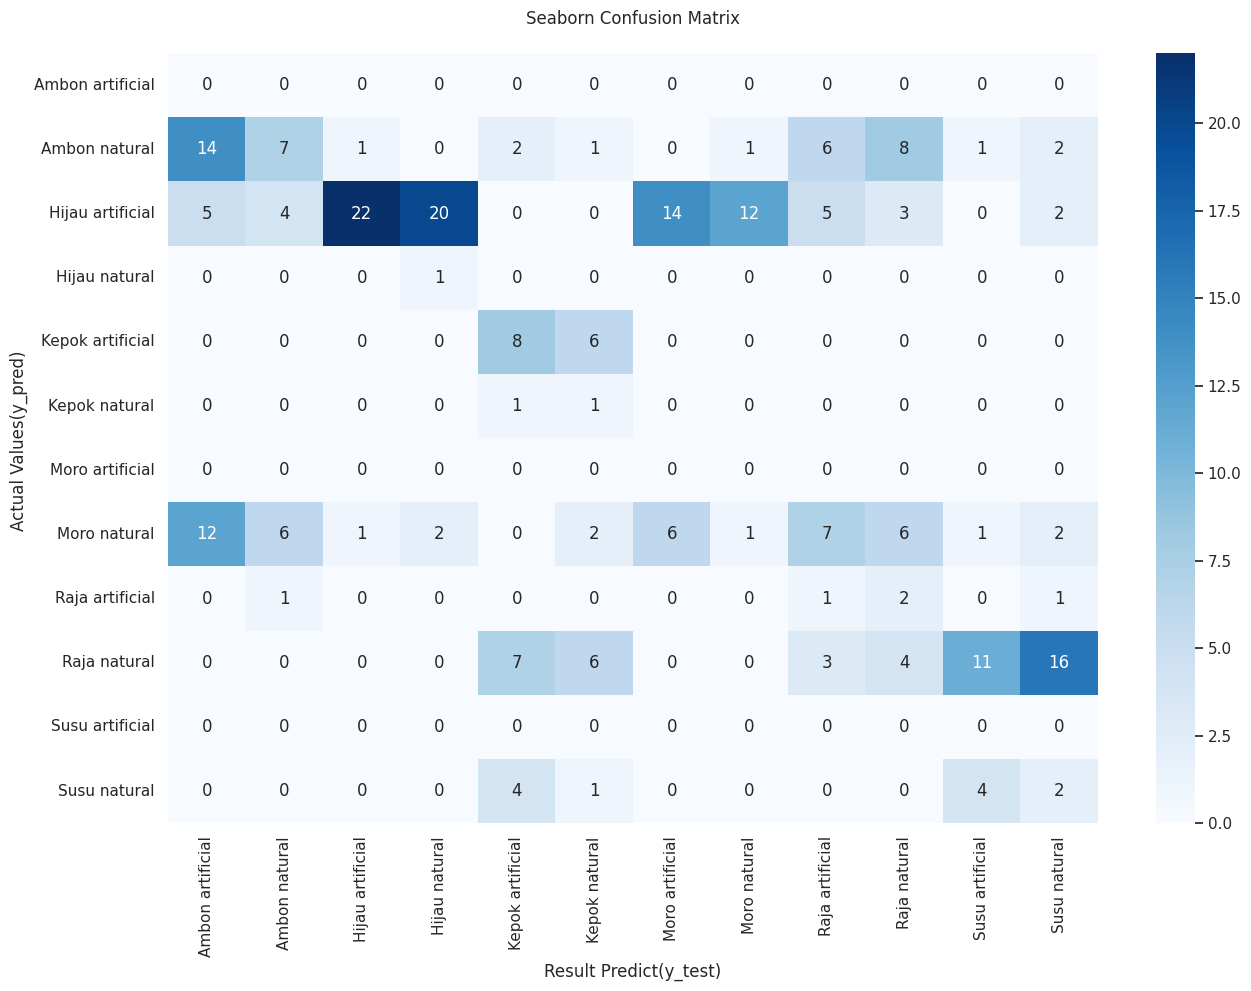

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [30]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.39      0.16      0.23        43
           2       0.92      0.25      0.40        87
           3       0.04      1.00      0.08         1
           4       0.36      0.57      0.44        14
           5       0.06      0.50      0.11         2
           6       0.00      0.00      0.00         0
           7       0.07      0.02      0.03        46
           8       0.05      0.20      0.07         5
           9       0.17      0.09      0.11        47
          10       0.00      0.00      0.00         0
          11       0.08      0.18      0.11        11

    accuracy                           0.18       256
   macro avg       0.18      0.25      0.13       256
weighted avg       0.45      0.18      0.23       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### MobileNet Evaluation

In [31]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.0703125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

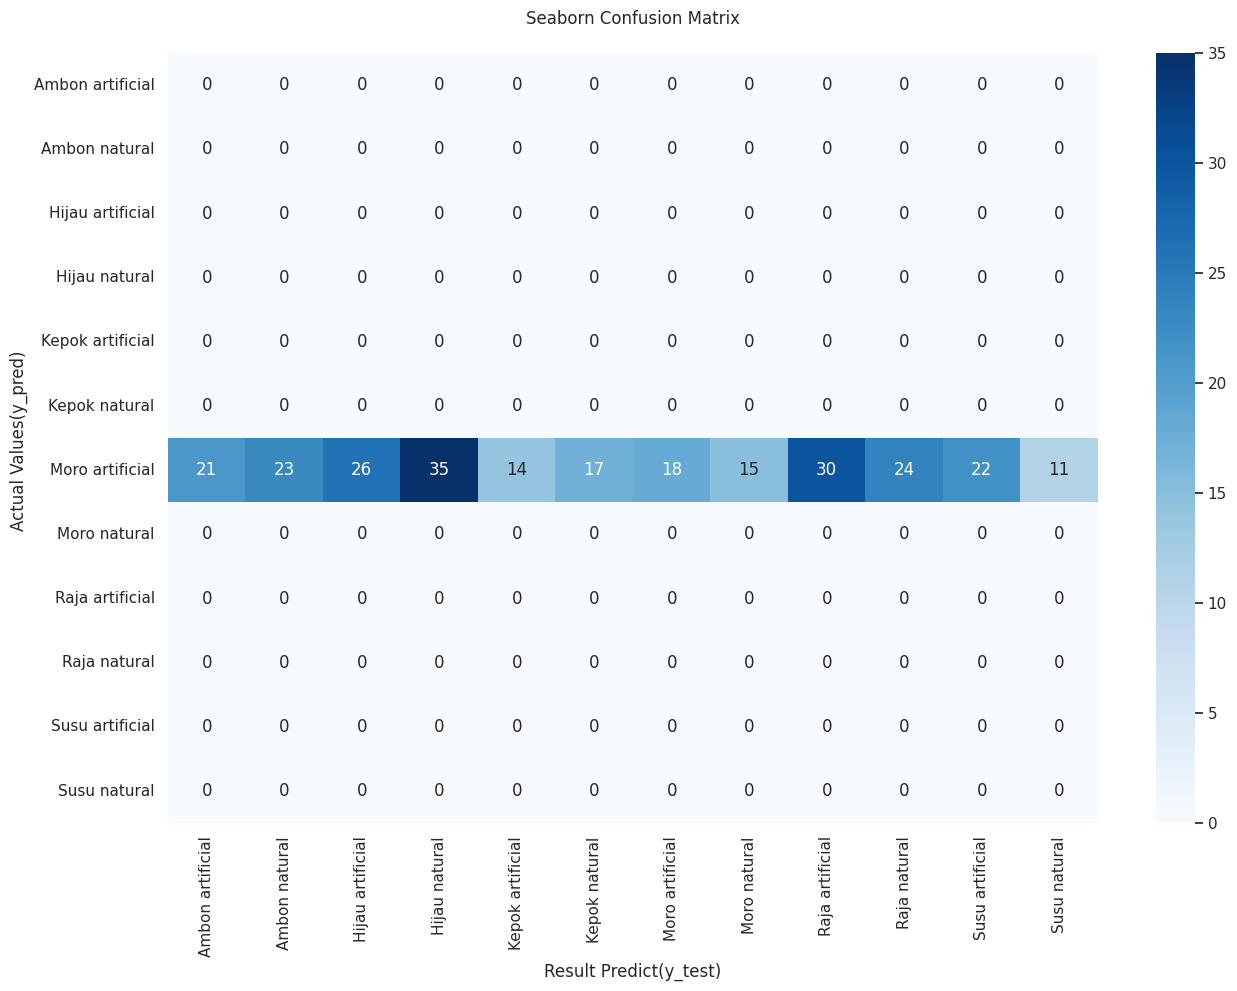

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [33]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.07      0.13       256
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0

    accuracy                           0.07       256
   macro avg       0.08      0.01      0.01       256
weighted avg       1.00      0.07      0.13       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Evaluation

In [34]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.10546875


Text(153.75, 0.5, 'Actual Values(y_pred) ')

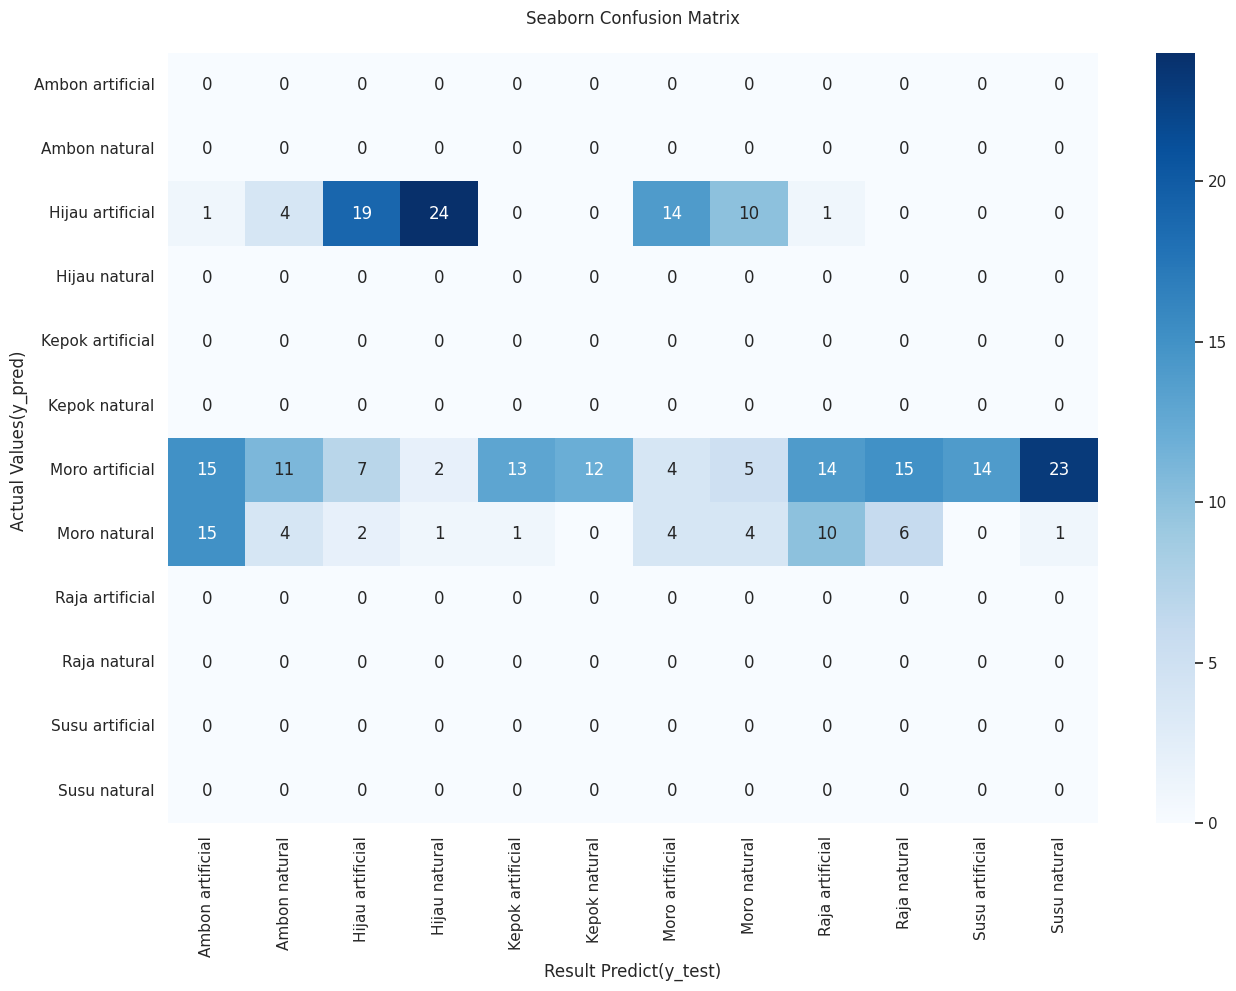

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [36]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.68      0.26      0.38        73
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.18      0.03      0.05       135
           7       0.21      0.08      0.12        48
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0

    accuracy                           0.11       256
   macro avg       0.09      0.03      0.05       256
weighted avg       0.33      0.11      0.16       256



/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
